#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e30*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.7794395 ,  0.45302043,  0.43271995],
       [-0.48486446,  0.87361664, -0.04123608],
       [-0.39671214, -0.1776695 ,  0.90058483]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.006691


In [26]:
Ret

array([[[ 7.79439501e-01,  4.53020427e-01,  4.32719952e-01],
        [-4.84864460e-01,  8.73616644e-01, -4.12360759e-02],
        [-3.96712137e-01, -1.77669500e-01,  9.00584826e-01]],

       [[ 4.13733827e-02,  1.43921381e-02,  9.99040094e-01],
        [-9.97648141e-01, -5.40943242e-02,  4.20950185e-02],
        [ 5.46482361e-02, -9.98432106e-01,  1.21202247e-02]],

       [[ 6.65702227e-01, -7.42512553e-01,  7.42674388e-02],
        [ 4.86895031e-01,  5.07623956e-01,  7.10810206e-01],
        [-5.65485432e-01, -4.37027490e-01,  6.99452071e-01]],

       [[-7.50833402e-02,  4.45515773e-02, -9.96181534e-01],
        [-8.53280343e-01,  5.14092060e-01,  8.73041183e-02],
        [ 5.16018554e-01,  8.56577206e-01, -5.84763886e-04]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [30]:
np.abs(dx)*dx

array([-1.67884744, -0.58165396,  2.74022873,  2.93198613])

In [31]:
C1(dx,dy,dz,Ret)

array([[-2.91164388,  0.46861604,  0.73820071, -2.15664427],
       [ 1.54121203,  8.70040287,  0.56937421, -3.44325324],
       [-0.2769968 , -0.73247078, -2.65501326, -0.80372677]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000398


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-16710.02303241,   8845.06812724,  -1589.69406242])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[-16710.02303241,   2689.40334766,   4236.55894323,
        -12377.05464327],
       [  8845.06812724,  49931.90732944,   3267.65789035,
        -19760.94717838],
       [ -1589.69406242,  -4203.67465011, -15237.21121692,
         -4612.61523326]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[-16710.02303241,   8845.06812724,  -1589.69406242],
       [  2689.40334766,  49931.90732944,  -4203.67465011],
       [  4236.55894323,   3267.65789035, -15237.21121692],
       [-12377.05464327, -19760.94717838,  -4612.61523326]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000429


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000421


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000235


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [62]:
phi(x,y,z,Ret,None)

array([[ -42.10033395,  -45.73947145, -165.76400842],
       [ -53.80840378,    6.33223151,  -66.32373518],
       [  42.84676264,  112.0745535 ,  146.14312016],
       [  95.37066264,  156.11569598,   33.51024911]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000191


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000532


In [68]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [69]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000652


In [70]:
ωe(φ,θ,ψ,None,None)

array([[-0.18633427,  0.47158945, -0.49394945],
       [-0.14906458,  1.2052793 ,  1.28515751],
       [-0.74751057,  0.67299056,  0.64638948],
       [-0.14012846, -2.19372579,  1.55781275]])

In [71]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [72]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-100.76554337,  -88.07654368,   25.90913184, -316.71131514],
       [ -10.09207782,  -79.03879342,  136.9392297 ,  153.26536781],
       [  28.37690415,   63.91024301, -112.61238137,  187.34082268]])

In [73]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [74]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [75]:
# d_s(phi,x,y,z,Ret)

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001213


In [77]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [78]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [79]:
# sigma(x,y,z)

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[ 16710.02303241,  -2689.40334766,  -4236.55894323,
         12377.05464327],
       [ -8845.06812724, -49931.90732944,  -3267.65789035,
         19760.94717838],
       [  1461.52952019,   4075.51010788,  15109.04667469,
          4484.45069103]])

In [81]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [82]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.002752


In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-6.16912124e+10, -7.33228303e+09,  2.33369294e+10],
       [-1.50836439e+08, -2.28363687e+08,  9.38037690e+06],
       [ 1.11868645e+10,  3.51613214e+10, -5.48170597e+10],
       [-1.78503929e+09,  4.07321162e+10,  6.38845160e+04]])

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000258


In [85]:
Re_b(Ret).shape

(4, 3, 3)

In [86]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [87]:
Irho_e(Ret)

array([[[6.07525935e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.63206041e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.62210606e+02]],

       [[1.71175679e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.92619591e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.93799692e-02]],

       [[4.43159456e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.57682081e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.78466398e+01]],

       [[5.63750798e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.64290647e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.83897605e-05]]])

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.002273


In [89]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [90]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [91]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [92]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [93]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [94]:
# ωe(φ,θ,ψ,None)

In [95]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [96]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [97]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [98]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001338


In [99]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [100]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [101]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [102]:
ne_(dx,dy,dz,DT,Ret)

array([[ 16710.02303241,  -2689.40334766,  -4236.55894323,
         12377.05464327],
       [ -8845.06812724, -49931.90732944,  -3267.65789035,
         19760.94717838],
       [  1461.52952019,   4075.51010788,  15109.04667469,
          4484.45069103]])

In [103]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [104]:
Re_b(Ret).shape

(4, 3, 3)

In [105]:
ne_(dx,dy,dz,DT, Ret).T

array([[ 16710.02303241,  -8845.06812724,   1461.52952019],
       [ -2689.40334766, -49931.90732944,   4075.51010788],
       [ -4236.55894323,  -3267.65789035,  15109.04667469],
       [ 12377.05464327,  19760.94717838,   4484.45069103]])

In [106]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-29.57986613,  65.10279326, -38.79109013, 113.21087186]),
 array([-165.61609232,  -54.29405488,  185.06595673,  -81.39654773]),
 array([-1.29570345, -0.76266241,  1.65536363,  1.71230433]),
 numpy.ndarray,
 array([-1.5866089 , -2.93562247, -0.21041681, -1.695081  ]))

In [107]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[ 26359.91170398, -24734.63130231,  -2279.80939723],
       [   552.29795131, -44376.23771125,  53831.553375  ],
       [ -3508.45849093,   3750.50580062,  29500.86959611],
       [  7860.79844356,  19750.30681516,  27795.39520701]])

In [108]:
ne_(dx,dy,dz,DT,Ret).T

array([[ 16710.02303241,  -8845.06812724,   1461.52952019],
       [ -2689.40334766, -49931.90732944,   4075.51010788],
       [ -4236.55894323,  -3267.65789035,  15109.04667469],
       [ 12377.05464327,  19760.94717838,   4484.45069103]])

### Vessel

In [109]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [110]:
V=VesselSemisub()

In [111]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [112]:
tau_force = V.tau(η,dη, ddη)

In [113]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [114]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [115]:
V=VesselOtter()

In [116]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [117]:
tau_force = V.tau(η,dη, ddη)

In [118]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [119]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [120]:
V=VesselSemisub()

In [121]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [122]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [123]:
Hs = 2.5 # significant wave height in m

In [124]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [125]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [126]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [127]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [128]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [129]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [130]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [131]:
Fx_0=82945396

In [132]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [133]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [134]:
delta_x=horizontal_length/(node_N-1)

In [135]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [136]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

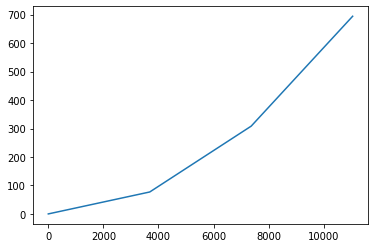

In [137]:
plt.plot(x0, z0)
plt.show()

In [138]:
rng = np.random.default_rng(seed=1)
q0=np.zeros(12*node_N)

In [139]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [140]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [141]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [142]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [144]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [145]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [146]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [147]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [148]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

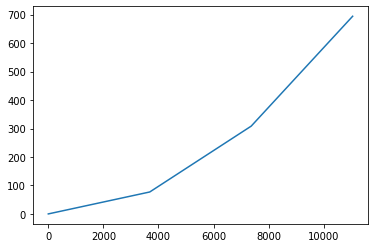

In [149]:
plt.plot(x0_, z0_)
plt.show()

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
# q0[10*node_N]=q0[8*node_N]=0

In [152]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.45584192e-01,  8.21618144e-01,  3.30437076e-01, -1.30315723e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

### Dynamics

In [153]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
# #     y[-1]+=5*np.cos(t)
# #     z[-1]=z0[-1]+2.5*np.sin(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =0.0005
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
#                         - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
    tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
#     Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    hack2=1e-1
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i]
#                               +hack2*np.identity(3)
                              , Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i]
                              +hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    ddφ*=np.exp(-t)
    ddθ*=np.exp(-t)
    ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [154]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [155]:
# us=ode15s.integrate(10)

In [156]:
tspan = (0., 5)
# tspan = (0., 10)

In [157]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
             method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
1.1947269773862568e-15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.194726977386257e-13
1.194726977386257e-13
2.389453954772514e-13
2.389453954772514e-13
1.4336723728635082e-12
1.4336723728635082e-12
2.628399350249765e-12
2.628399350249765e-12
1.457566912411233e-11
1.457566912411233e-11
2.6522938897974897e-11
2.6522938897974897e-11
1.4599563663660055e-10
1.4599563663660055e-10
2.654683343752262e-10
2.654683343752262e-10
7.837369110077569e-10
7.837369110077569e-10
1.3020054876402877e-09
1.3020054876402877e-09
2.038827152527005e-09
2.038827152527005e-09
2.775648817413722e-09
2.775648817413722e-09
3.512470482300439e-09
3.512470482300439e-09
5.281980866753484e-09
5.281980866753484e-09
7.051491251206529e-09
7.051491251206529e-09
8.821001635659575e-09
8.821001635659575e-09
1.059051202011262e-08
1.059051202011262e-08
9.593443395514032

6.46095132919937e-08
6.494816836100213e-08
6.494816836100213e-08
6.528682343001056e-08
6.528682343001056e-08
6.612025263894485e-08
6.612025263894485e-08
6.695368184787915e-08
6.695368184787915e-08
6.778711105681344e-08
6.778711105681344e-08
7.05287137128366e-08
7.05287137128366e-08
6.930392018834782e-08
6.930392018834782e-08
6.880564143214391e-08
6.880564143214391e-08
6.856641310904689e-08
6.856641310904689e-08
6.934571516128033e-08
6.934571516128033e-08
7.012501721351378e-08
7.012501721351378e-08
7.131142162152673e-08
7.131142162152673e-08
7.249782602953969e-08
7.249782602953969e-08
7.209706577832575e-08
7.209706577832575e-08
7.191127826400052e-08
7.191127826400052e-08
7.251113490647431e-08
7.251113490647431e-08
7.238535011211475e-08
7.238535011211475e-08
7.285942196022897e-08
7.285942196022897e-08
7.276572465212714e-08
7.276572465212714e-08
7.314609919213954e-08
7.314609919213954e-08
7.352647373215193e-08
7.352647373215193e-08
7.390684827216433e-08
7.390684827216433e-08
7.48402504126

1.5591082247677956e-07
1.5591082247677956e-07
1.5542348091417698e-07
1.5542348091417698e-07
1.5554531630482764e-07
1.5554531630482764e-07
1.556671516954783e-07
1.556671516954783e-07
1.5676346054611254e-07
1.5676346054611254e-07
1.5588974540724008e-07
1.5588974540724008e-07
1.5574797417544565e-07
1.5574797417544565e-07
1.55828796655413e-07
1.55828796655413e-07
1.5590961913538037e-07
1.5590961913538037e-07
1.558730696859568e-07
1.558730696859568e-07
1.5585848729297714e-07
1.5585848729297714e-07
1.5585156004640354e-07
1.5585156004640354e-07
1.5587432343739407e-07
1.5587432343739407e-07
1.558970868283846e-07
1.558970868283846e-07
1.5593291856681964e-07
1.5593291856681964e-07
1.559687503052547e-07
1.559687503052547e-07
1.5632706768960518e-07
1.5632706768960518e-07
1.5668538507395566e-07
1.5668538507395566e-07
1.5650790158082918e-07
1.5650790158082918e-07
1.5668873547205318e-07
1.5668873547205318e-07
1.57185600757879e-07
1.57185600757879e-07
1.576824660437048e-07
1.576824660437048e-07
1.5817

2.019410154517736e-07
2.019410154517736e-07
2.019665206033875e-07
2.019665206033875e-07
2.019920257550014e-07
2.019920257550014e-07
2.020175309066153e-07
2.020175309066153e-07
2.020826699490275e-07
2.020826699490275e-07
2.021478089914397e-07
2.021478089914397e-07
2.0221294803385192e-07
2.0221294803385192e-07
2.0242938693784384e-07
2.0242938693784384e-07
2.0264582584183577e-07
2.0264582584183577e-07
2.0336799463003502e-07
2.0336799463003502e-07
2.0308249863695186e-07
2.0308249863695186e-07
2.0295654187564086e-07
2.0295654187564086e-07
2.0289298159405242e-07
2.0289298159405242e-07
2.0314013734626908e-07
2.0314013734626908e-07
2.0338729309848574e-07
2.0338729309848574e-07
2.037686292560846e-07
2.037686292560846e-07
2.0414996541368344e-07
2.0414996541368344e-07
2.045313015712823e-07
2.045313015712823e-07
2.0491263772888115e-07
2.0491263772888115e-07
2.0568027894532297e-07
2.0568027894532297e-07
2.064479201617648e-07
2.064479201617648e-07
2.072155613782066e-07
2.072155613782066e-07
2.087395

2.472533604075296e-07
2.472533604075296e-07
2.4687620452199437e-07
2.4687620452199437e-07
2.4668214331276917e-07
2.4668214331276917e-07
2.4749500508218946e-07
2.4749500508218946e-07
2.4830786685160975e-07
2.4830786685160975e-07
2.490870261823721e-07
2.490870261823721e-07
2.4986618551313444e-07
2.4986618551313444e-07
2.506453448438968e-07
2.506453448438968e-07
2.5142450417465914e-07
2.5142450417465914e-07
2.526953506762615e-07
2.526953506762615e-07
2.5244543205163885e-07
2.5244543205163885e-07
2.5346635992861856e-07
2.5346635992861856e-07
2.5448728780559827e-07
2.5448728780559827e-07
2.5384956728057493e-07
2.5384956728057493e-07
2.542327746325313e-07
2.542327746325313e-07
2.5461598198448767e-07
2.5461598198448767e-07
2.5441996190095685e-07
2.5441996190095685e-07
2.5434833757412624e-07
2.5434833757412624e-07
2.5431640672042974e-07
2.5431640672042974e-07
2.5430012972782533e-07
2.5430012972782533e-07
2.5436748482311935e-07
2.5436748482311935e-07
2.544348399184134e-07
2.544348399184134e-07


4.0627171567701795e-07
4.0627171567701795e-07
4.058049627243646e-07
4.058049627243646e-07
4.055475558129295e-07
4.055475558129295e-07
4.064085076833063e-07
4.064085076833063e-07
4.0726945955368306e-07
4.0726945955368306e-07
4.0708516827201687e-07
4.0708516827201687e-07
4.0776182886072747e-07
4.0776182886072747e-07
4.0843848944943806e-07
4.0843848944943806e-07
4.0911515003814865e-07
4.0911515003814865e-07
4.100949894499249e-07
4.100949894499249e-07
4.110748288617011e-07
4.110748288617011e-07
4.120546682734773e-07
4.120546682734773e-07
4.1370267109624264e-07
4.1370267109624264e-07
4.1535067391900796e-07
4.1535067391900796e-07
4.169986767417733e-07
4.169986767417733e-07
4.186466795645386e-07
4.186466795645386e-07
4.211402751409802e-07
4.211402751409802e-07
4.2363387071742176e-07
4.2363387071742176e-07
4.2612746629386335e-07
4.2612746629386335e-07
4.2862106187030493e-07
4.2862106187030493e-07
4.321002221416187e-07
4.321002221416187e-07
4.2997829366840714e-07
4.2997829366840714e-07
4.313355

4.997145436206367e-07
4.997446796041472e-07
4.997446796041472e-07
4.998211224158103e-07
4.998211224158103e-07
4.998975652274734e-07
4.998975652274734e-07
4.999740080391364e-07
4.999740080391364e-07
5.002103038841591e-07
5.002103038841591e-07
5.004465997291818e-07
5.004465997291818e-07
5.006828955742045e-07
5.006828955742045e-07
5.019446095247732e-07
5.019446095247732e-07
5.032063234753418e-07
5.032063234753418e-07
5.044680374259105e-07
5.044680374259105e-07
5.06559178096387e-07
5.06559178096387e-07
5.052083764577551e-07
5.052083764577551e-07
5.059487154895997e-07
5.059487154895997e-07
5.055042346958354e-07
5.055042346958354e-07
5.058000929339158e-07
5.058000929339158e-07
5.060959511719961e-07
5.060959511719961e-07
5.058932729056537e-07
5.058932729056537e-07
5.058418195397097e-07
5.058418195397097e-07
5.058231563563481e-07
5.058231563563481e-07
5.058462197787803e-07
5.058462197787803e-07
5.058372401709397e-07
5.058372401709397e-07
5.058513239855313e-07
5.058513239855313e-07
5.0584662579

5.664300335171634e-07
5.704278803076362e-07
5.704278803076362e-07
5.744257270981091e-07
5.744257270981091e-07
5.72087419754991e-07
5.72087419754991e-07
5.737469592023457e-07
5.737469592023457e-07
5.728885026563518e-07
5.728885026563518e-07
5.725513310539707e-07
5.725513310539707e-07
5.723951250589269e-07
5.723951250589269e-07
5.723134494206671e-07
5.723134494206671e-07
5.722667037266828e-07
5.722667037266828e-07
5.724459876983747e-07
5.724459876983747e-07
5.726252716700666e-07
5.726252716700666e-07
5.728045556417585e-07
5.728045556417585e-07
5.730235497007715e-07
5.730235497007715e-07
5.732425437597845e-07
5.732425437597845e-07
5.734615378187974e-07
5.734615378187974e-07
5.736805318778104e-07
5.736805318778104e-07
5.742793667181392e-07
5.742793667181392e-07
5.748782015584679e-07
5.748782015584679e-07
5.754770363987966e-07
5.754770363987966e-07
5.766316025499679e-07
5.766316025499679e-07
5.777861687011392e-07
5.777861687011392e-07
5.789407348523104e-07
5.789407348523104e-07
5.8180845059

7.327906853023673e-07
7.329185928240921e-07
7.329185928240921e-07
7.330465003458169e-07
7.330465003458169e-07
7.331744078675417e-07
7.331744078675417e-07
7.336027257496948e-07
7.336027257496948e-07
7.340310436318479e-07
7.340310436318479e-07
7.34459361514001e-07
7.34459361514001e-07
7.35068790166513e-07
7.35068790166513e-07
7.356782188190249e-07
7.356782188190249e-07
7.362876474715369e-07
7.362876474715369e-07
7.370346519464149e-07
7.370346519464149e-07
7.377816564212929e-07
7.377816564212929e-07
7.385286608961709e-07
7.385286608961709e-07
7.393279715005109e-07
7.393279715005109e-07
7.401272821048509e-07
7.401272821048509e-07
7.409265927091909e-07
7.409265927091909e-07
7.417537037641341e-07
7.417537037641341e-07
7.415201396734747e-07
7.415201396734747e-07
7.413943960920272e-07
7.413943960920272e-07
7.418621994748634e-07
7.418621994748634e-07
7.417717201145483e-07
7.417717201145483e-07
7.421490441370695e-07
7.421490441370695e-07
7.425263681595907e-07
7.425263681595907e-07
7.429036921821

7.834884880166497e-07
7.837237715884863e-07
7.837237715884863e-07
7.841088269300495e-07
7.841088269300495e-07
7.844938822716127e-07
7.844938822716127e-07
7.848789376131759e-07
7.848789376131759e-07
7.854696235294776e-07
7.854696235294776e-07
7.860603094457794e-07
7.860603094457794e-07
7.866509953620811e-07
7.866509953620811e-07
7.87407780062097e-07
7.87407780062097e-07
7.881645647621128e-07
7.881645647621128e-07
7.889213494621287e-07
7.889213494621287e-07
7.90619655783317e-07
7.90619655783317e-07
7.893993667500102e-07
7.893993667500102e-07
7.891172759225276e-07
7.891172759225276e-07
7.890292333813001e-07
7.890292333813001e-07
7.889938321148695e-07
7.889938321148695e-07
7.889769580891864e-07
7.889769580891864e-07
7.89032566716244e-07
7.89032566716244e-07
7.890881753433017e-07
7.890881753433017e-07
7.89181033064875e-07
7.89181033064875e-07
7.892738907864483e-07
7.892738907864483e-07
7.89572731168493e-07
7.89572731168493e-07
7.898715715505376e-07
7.898715715505376e-07
7.901704119325822e-0

8.437551734521046e-07
8.437551734521046e-07
8.444512402834128e-07
8.444512402834128e-07
8.441268964696636e-07
8.441268964696636e-07
8.439873140371846e-07
8.439873140371846e-07
8.442194546222646e-07
8.442194546222646e-07
8.441535176945885e-07
8.441535176945885e-07
8.441166847669831e-07
8.441166847669831e-07
8.442460554967816e-07
8.442460554967816e-07
8.442185882697103e-07
8.442185882697103e-07
8.443204917724375e-07
8.443204917724375e-07
8.444223952751647e-07
8.444223952751647e-07
8.445242987778919e-07
8.445242987778919e-07
8.447661952345109e-07
8.447661952345109e-07
8.450080916911299e-07
8.450080916911299e-07
8.45249988147749e-07
8.45249988147749e-07
8.457995728324195e-07
8.457995728324195e-07
8.4634915751709e-07
8.4634915751709e-07
8.468987422017605e-07
8.468987422017605e-07
8.477361504364247e-07
8.477361504364247e-07
8.48573558671089e-07
8.48573558671089e-07
8.494109669057532e-07
8.494109669057532e-07
8.505179550436317e-07
8.505179550436317e-07
8.516249431815101e-07
8.516249431815101e

9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.350560477738048e-07
9.35056047

1.040021029321016e-06
1.0411138896307524e-06
1.0411138896307524e-06
1.0422067499404888e-06
1.0422067499404888e-06
1.043764694799939e-06
1.043764694799939e-06
1.0453226396593894e-06
1.0453226396593894e-06
1.0445304652424469e-06
1.0445304652424469e-06
1.044240011206045e-06
1.044240011206045e-06
1.0441100623709064e-06
1.0441100623709064e-06
1.0444554299418737e-06
1.0444554299418737e-06
1.044800797512841e-06
1.044800797512841e-06
1.0451534342478772e-06
1.0451534342478772e-06
1.0455060709829135e-06
1.0455060709829135e-06
1.0458587077179498e-06
1.0458587077179498e-06
1.0465564902622376e-06
1.0465564902622376e-06
1.0472542728065253e-06
1.0472542728065253e-06
1.047952055350813e-06
1.047952055350813e-06
1.0502754267450419e-06
1.0502754267450419e-06
1.0525987981392706e-06
1.0525987981392706e-06
1.0512949263349907e-06
1.0512949263349907e-06
1.050859825075185e-06
1.050859825075185e-06
1.0514442234053282e-06
1.0514442234053282e-06
1.0512681519977495e-06
1.0512681519977495e-06
1.051181004674557e-06


1.121490409684984e-06
1.1209929981236602e-06
1.1209929981236602e-06
1.120762020811831e-06
1.120762020811831e-06
1.1214340873250706e-06
1.1214340873250706e-06
1.1221061538383102e-06
1.1221061538383102e-06
1.1232056700300647e-06
1.1232056700300647e-06
1.1228676371576213e-06
1.1228676371576213e-06
1.1236291204769324e-06
1.1236291204769324e-06
1.1246046555683393e-06
1.1246046555683393e-06
1.1255801906597461e-06
1.1255801906597461e-06
1.1253160269148984e-06
1.1253160269148984e-06
1.1260273982614576e-06
1.1260273982614576e-06
1.1267387696080168e-06
1.1267387696080168e-06
1.1277855593548721e-06
1.1277855593548721e-06
1.1275038945428953e-06
1.1275038945428953e-06
1.1282690194777738e-06
1.1282690194777738e-06
1.1295879391467626e-06
1.1295879391467626e-06
1.1291033071161652e-06
1.1291033071161652e-06
1.1299375947545566e-06
1.1299375947545566e-06
1.1297464879947465e-06
1.1297464879947465e-06
1.1303896688733278e-06
1.1303896688733278e-06
1.1310328497519091e-06
1.1310328497519091e-06
1.132248726857

1.2676695208052574e-06
1.2676695208052574e-06
1.2689519789112905e-06
1.2689519789112905e-06
1.2702344370173235e-06
1.2702344370173235e-06
1.271844046400213e-06
1.271844046400213e-06
1.2734536557831026e-06
1.2734536557831026e-06
1.2730974630360564e-06
1.2730974630360564e-06
1.2743508796718998e-06
1.2743508796718998e-06
1.2756432857403122e-06
1.2756432857403122e-06
1.2753841473804392e-06
1.2753841473804392e-06
1.2764174150889786e-06
1.2764174150889786e-06
1.277450682797518e-06
1.277450682797518e-06
1.278784457887084e-06
1.278784457887084e-06
1.28011823297665e-06
1.28011823297665e-06
1.2814544868158947e-06
1.2814544868158947e-06
1.2827907406551394e-06
1.2827907406551394e-06
1.2841269944943841e-06
1.2841269944943841e-06
1.2853637518248423e-06
1.2853637518248423e-06
1.2866005091553005e-06
1.2866005091553005e-06
1.2878372664857586e-06
1.2878372664857586e-06
1.2890740238162168e-06
1.2890740238162168e-06
1.290725713346275e-06
1.290725713346275e-06
1.2903125190940007e-06
1.2903125190940007e-06


1.480566384680409e-06
1.480566384680409e-06
1.4827008035181155e-06
1.4827008035181155e-06
1.484835222355822e-06
1.484835222355822e-06
1.4869724817648533e-06
1.4869724817648533e-06
1.4891097411738846e-06
1.4891097411738846e-06
1.4912470005829158e-06
1.4912470005829158e-06
1.4935397566042104e-06
1.4935397566042104e-06
1.495832512625505e-06
1.495832512625505e-06
1.4953720304544769e-06
1.4953720304544769e-06
1.4972043043047434e-06
1.4972043043047434e-06
1.4990365781550099e-06
1.4990365781550099e-06
1.500897534181727e-06
1.500897534181727e-06
1.502758490208444e-06
1.502758490208444e-06
1.5023569466246092e-06
1.5023569466246092e-06
1.5038163590674914e-06
1.5038163590674914e-06
1.5050922653712825e-06
1.5050922653712825e-06
1.5063681716750736e-06
1.5063681716750736e-06
1.5076440779788646e-06
1.5076440779788646e-06
1.5089282375421414e-06
1.5089282375421414e-06
1.5102123971054183e-06
1.5102123971054183e-06
1.511496556668695e-06
1.511496556668695e-06
1.512780716231972e-06
1.512780716231972e-06
1.

1.6878349747505828e-06
1.6900429803828733e-06
1.6900429803828733e-06
1.6922509860151637e-06
1.6922509860151637e-06
1.6944589916474542e-06
1.6944589916474542e-06
1.697530422447099e-06
1.697530422447099e-06
1.7006018532467438e-06
1.7006018532467438e-06
1.7036732840463886e-06
1.7036732840463886e-06
1.7067447148460333e-06
1.7067447148460333e-06
1.7094547965217132e-06
1.7094547965217132e-06
1.7121648781973932e-06
1.7121648781973932e-06
1.714874959873073e-06
1.714874959873073e-06
1.717585041548753e-06
1.717585041548753e-06
1.7199785640952186e-06
1.7199785640952186e-06
1.7223720866416842e-06
1.7223720866416842e-06
1.7247656091881498e-06
1.7247656091881498e-06
1.7271591317346154e-06
1.7271591317346154e-06
1.7300883180748378e-06
1.7300883180748378e-06
1.7287373755183283e-06
1.7287373755183283e-06
1.7303156193020411e-06
1.7303156193020411e-06
1.7298409632067578e-06
1.7298409632067578e-06
1.7309445508951872e-06
1.7309445508951872e-06
1.7306940666733055e-06
1.7306940666733055e-06
1.731547170139853

1.9677874304211316e-06
1.972082261212284e-06
1.972082261212284e-06
1.9706210561108156e-06
1.9706210561108156e-06
1.9699341429142827e-06
1.9699341429142827e-06
1.9720808554074337e-06
1.9720808554074337e-06
1.9742275679005847e-06
1.9742275679005847e-06
1.9763594265864007e-06
1.9763594265864007e-06
1.9784912852722167e-06
1.9784912852722167e-06
1.9806231439580327e-06
1.9806231439580327e-06
1.9827550026438487e-06
1.9827550026438487e-06
1.9852333155098926e-06
1.9852333155098926e-06
1.9877116283759364e-06
1.9877116283759364e-06
1.9901899412419802e-06
1.9901899412419802e-06
1.9927096962150443e-06
1.9927096962150443e-06
1.991531129392224e-06
1.991531129392224e-06
1.992872317542468e-06
1.992872317542468e-06
1.9943842993398197e-06
1.9943842993398197e-06
1.9958962811371712e-06
1.9958962811371712e-06
1.997408262934523e-06
1.997408262934523e-06
1.9990095418777638e-06
1.9990095418777638e-06
2.0006108208210047e-06
2.0006108208210047e-06
2.0022120997642457e-06
2.0022120997642457e-06
2.0038133787074866e

2.2217603132852303e-06
2.2217603132852303e-06
2.2234008675046216e-06
2.2234008675046216e-06
2.225041421724013e-06
2.225041421724013e-06
2.2266819759434043e-06
2.2266819759434043e-06
2.226316965970931e-06
2.226316965970931e-06
2.2275925102178495e-06
2.2275925102178495e-06
2.2288680544647677e-06
2.2288680544647677e-06
2.230577292935719e-06
2.230577292935719e-06
2.2322865314066704e-06
2.2322865314066704e-06
2.2339957698776218e-06
2.2339957698776218e-06
2.235705008348573e-06
2.235705008348573e-06
2.237570827745457e-06
2.237570827745457e-06
2.2394366471423407e-06
2.2394366471423407e-06
2.2413024665392244e-06
2.2413024665392244e-06
2.2436950867896862e-06
2.2436950867896862e-06
2.2424369375115477e-06
2.2424369375115477e-06
2.243571408483871e-06
2.243571408483871e-06
2.244951160766896e-06
2.244951160766896e-06
2.2446156478996517e-06
2.2446156478996517e-06
2.2456598873154323e-06
2.2456598873154323e-06
2.246704126731213e-06
2.246704126731213e-06
2.247716350347213e-06
2.247716350347213e-06
2.2487

2.4158852455808395e-06
2.4171012190396403e-06
2.4171012190396403e-06
2.416865991058159e-06
2.416865991058159e-06
2.4178467365354786e-06
2.4178467365354786e-06
2.417646804509565e-06
2.417646804509565e-06
2.4184276179609713e-06
2.4184276179609713e-06
2.4193168838509164e-06
2.4193168838509164e-06
2.4202061497408615e-06
2.4202061497408615e-06
2.421133140616872e-06
2.421133140616872e-06
2.4220601314928825e-06
2.4220601314928825e-06
2.423012302305654e-06
2.423012302305654e-06
2.423964473118425e-06
2.423964473118425e-06
2.424948461134503e-06
2.424948461134503e-06
2.425932449150581e-06
2.425932449150581e-06
2.4257181714259605e-06
2.4257181714259605e-06
2.426487881717418e-06
2.426487881717418e-06
2.427372084285376e-06
2.427372084285376e-06
2.4282562868533346e-06
2.4282562868533346e-06
2.429290951653243e-06
2.429290951653243e-06
2.430325616453151e-06
2.430325616453151e-06
2.4312683528763927e-06
2.4312683528763927e-06
2.432211089299634e-06
2.432211089299634e-06
2.433230222922841e-06
2.43323022292

2.5644147419711122e-06
2.565545846518768e-06
2.565545846518768e-06
2.566676951066424e-06
2.566676951066424e-06
2.5678901028130283e-06
2.5678901028130283e-06
2.5691032545596324e-06
2.5691032545596324e-06
2.5703164063062365e-06
2.5703164063062365e-06
2.571818295360236e-06
2.571818295360236e-06
2.5733201844142355e-06
2.5733201844142355e-06
2.573004754979581e-06
2.573004754979581e-06
2.5741912145989264e-06
2.5741912145989264e-06
2.5736013995086504e-06
2.5736013995086504e-06
2.5741980440377196e-06
2.5741980440377196e-06
2.574045819947721e-06
2.574045819947721e-06
2.574490240386792e-06
2.574490240386792e-06
2.5753290083300615e-06
2.5753290083300615e-06
2.576167776273331e-06
2.576167776273331e-06
2.575953596164461e-06
2.575953596164461e-06
2.5765781839988604e-06
2.5765781839988604e-06
2.5773585315713895e-06
2.5773585315713895e-06
2.5781388791439186e-06
2.5781388791439186e-06
2.579163276286141e-06
2.579163276286141e-06
2.578600070213403e-06
2.578600070213403e-06
2.578445348494106e-06
2.5784453

2.747857416595522e-06
2.747857416595522e-06
2.7468413190553665e-06
2.7468413190553665e-06
2.7482089088344544e-06
2.7482089088344544e-06
2.747901739172261e-06
2.747901739172261e-06
2.747697332642922e-06
2.747697332642922e-06
2.748553346230478e-06
2.748553346230478e-06
2.749698981089226e-06
2.749698981089226e-06
2.7508446159479744e-06
2.7508446159479744e-06
2.7522267725289427e-06
2.7522267725289427e-06
2.753608929109911e-06
2.753608929109911e-06
2.754902763537835e-06
2.754902763537835e-06
2.7561965979657592e-06
2.7561965979657592e-06
2.7574904323936834e-06
2.7574904323936834e-06
2.7591937657034303e-06
2.7591937657034303e-06
2.7582854965131582e-06
2.7582854965131582e-06
2.759080560632633e-06
2.759080560632633e-06
2.75882764378813e-06
2.75882764378813e-06
2.759369791063102e-06
2.759369791063102e-06
2.760202129706881e-06
2.760202129706881e-06
2.76103446835066e-06
2.76103446835066e-06
2.761883838895838e-06
2.761883838895838e-06
2.7627332094410157e-06
2.7627332094410157e-06
2.7635825799861934

2.929347781029742e-06
2.93017938984067e-06
2.93017938984067e-06
2.9309521474124243e-06
2.9309521474124243e-06
2.9317249049841785e-06
2.9317249049841785e-06
2.9324976625559328e-06
2.9324976625559328e-06
2.933734031372406e-06
2.933734031372406e-06
2.934970400188879e-06
2.934970400188879e-06
2.9346894493972756e-06
2.9346894493972756e-06
2.9356448674221453e-06
2.9356448674221453e-06
2.9365256643169933e-06
2.9365256643169933e-06
2.9374064612118413e-06
2.9374064612118413e-06
2.9382872581066893e-06
2.9382872581066893e-06
2.9394412641111442e-06
2.9394412641111442e-06
2.940595270115599e-06
2.940595270115599e-06
2.9423220427112734e-06
2.9423220427112734e-06
2.9440488153069476e-06
2.9440488153069476e-06
2.945775587902622e-06
2.945775587902622e-06
2.9481871621412993e-06
2.9481871621412993e-06
2.9505987363799767e-06
2.9505987363799767e-06
2.953010310618654e-06
2.953010310618654e-06
2.9554218848573315e-06
2.9554218848573315e-06
2.957612659734996e-06
2.957612659734996e-06
2.9598034346126606e-06
2.959

3.131875761052072e-06
3.1338335996073417e-06
3.1338335996073417e-06
3.1357914381626115e-06
3.1357914381626115e-06
3.1377492767178812e-06
3.1377492767178812e-06
3.139707115273151e-06
3.139707115273151e-06
3.1415675099796456e-06
3.1415675099796456e-06
3.14342790468614e-06
3.14342790468614e-06
3.143063516519369e-06
3.143063516519369e-06
3.1445595230590926e-06
3.1445595230590926e-06
3.146055529598816e-06
3.146055529598816e-06
3.145691825854496e-06
3.145691825854496e-06
3.146824128649899e-06
3.146824128649899e-06
3.1479564314453024e-06
3.1479564314453024e-06
3.14933805799977e-06
3.14933805799977e-06
3.1507196845542374e-06
3.1507196845542374e-06
3.1523611534398224e-06
3.1523611534398224e-06
3.151821748776359e-06
3.151821748776359e-06
3.1529238129984802e-06
3.1529238129984802e-06
3.1543844653611097e-06
3.1543844653611097e-06
3.154088498132431e-06
3.154088498132431e-06
3.155253183266382e-06
3.155253183266382e-06
3.156556752773575e-06
3.156556752773575e-06
3.1578603222807683e-06
3.1578603222807

3.3138102329939366e-06
3.3138102329939366e-06
3.31539994728796e-06
3.31539994728796e-06
3.316989661581983e-06
3.316989661581983e-06
3.3185793758760063e-06
3.3185793758760063e-06
3.3182501797678335e-06
3.3182501797678335e-06
3.319510697953684e-06
3.319510697953684e-06
3.3207712161395345e-06
3.3207712161395345e-06
3.322690379056037e-06
3.322690379056037e-06
3.3219293239341012e-06
3.3219293239341012e-06
3.323087431728668e-06
3.323087431728668e-06
3.324690918806367e-06
3.324690918806367e-06
3.326294405884066e-06
3.326294405884066e-06
3.325229724970306e-06
3.325229724970306e-06
3.3257685311342453e-06
3.3257685311342453e-06
3.326558576576476e-06
3.326558576576476e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.3261676915424643e-06
3.326167

3.428373877985621e-06
3.4299146047405745e-06
3.4299146047405745e-06
3.4314553314955278e-06
3.4314553314955278e-06
3.432996058250481e-06
3.432996058250481e-06
3.4345005633702473e-06
3.4345005633702473e-06
3.4360050684900136e-06
3.4360050684900136e-06
3.43750957360978e-06
3.43750957360978e-06
3.439014078729546e-06
3.439014078729546e-06
3.440979964233725e-06
3.440979964233725e-06
3.442945849737904e-06
3.442945849737904e-06
3.444911735242083e-06
3.444911735242083e-06
3.4445077092753866e-06
3.4445077092753866e-06
3.446069568812869e-06
3.446069568812869e-06
3.4476314283503518e-06
3.4476314283503518e-06
3.449127425482992e-06
3.449127425482992e-06
3.4506234226156325e-06
3.4506234226156325e-06
3.452119419748273e-06
3.452119419748273e-06
3.4536154168809133e-06
3.4536154168809133e-06
3.4551255960272713e-06
3.4551255960272713e-06
3.4566357751736294e-06
3.4566357751736294e-06
3.4581459543199875e-06
3.4581459543199875e-06
3.4596561334663455e-06
3.4596561334663455e-06
3.462002298014446e-06
3.46200229

3.590168263233895e-06
3.5917261996612656e-06
3.5917261996612656e-06
3.593284136088636e-06
3.593284136088636e-06
3.5969828254588685e-06
3.5969828254588685e-06
3.595443490969548e-06
3.595443490969548e-06
3.5948078659078697e-06
3.5948078659078697e-06
3.5963315957271034e-06
3.5963315957271034e-06
3.595717699716463e-06
3.595717699716463e-06
3.596627533525056e-06
3.596627533525056e-06
3.5974343925806566e-06
3.5974343925806566e-06
3.5982412516362572e-06
3.5982412516362572e-06
3.5990481106918578e-06
3.5990481106918578e-06
3.6003146486336834e-06
3.6003146486336834e-06
3.601581186575509e-06
3.601581186575509e-06
3.6012712613108314e-06
3.6012712613108314e-06
3.6010859668453493e-06
3.6010859668453493e-06
3.601857285057015e-06
3.601857285057015e-06
3.6029618908219422e-06
3.6029618908219422e-06
3.6040664965868693e-06
3.6040664965868693e-06
3.6054313318948578e-06
3.6054313318948578e-06
3.60516352904172e-06
3.60516352904172e-06
3.606260561496571e-06
3.606260561496571e-06
3.6059643818645866e-06
3.60596

3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.7338842070206146e-06
3.733763429

3.841516856881003e-06
3.841516856881003e-06
3.842448088102768e-06
3.842448088102768e-06
3.843415520413725e-06
3.843415520413725e-06
3.8443829527246816e-06
3.8443829527246816e-06
3.8453503850356385e-06
3.8453503850356385e-06
3.846317817346595e-06
3.846317817346595e-06
3.847429171577144e-06
3.847429171577144e-06
3.848540525807693e-06
3.848540525807693e-06
3.849651880038242e-06
3.849651880038242e-06
3.850884169757662e-06
3.850884169757662e-06
3.852116459477082e-06
3.852116459477082e-06
3.853348749196501e-06
3.853348749196501e-06
3.8548120537087255e-06
3.8548120537087255e-06
3.854332802902436e-06
3.854332802902436e-06
3.855316856608372e-06
3.855316856608372e-06
3.8562066943756154e-06
3.8562066943756154e-06
3.857096532142859e-06
3.857096532142859e-06
3.857986369910103e-06
3.857986369910103e-06
3.859447466011614e-06
3.859447466011614e-06
3.860908562113126e-06
3.860908562113126e-06
3.860908562113126e-06
3.860908562113126e-06
3.860908562113126e-06
3.860908562113126e-06
3.860908562113126e-06
3.

3.919001793602645e-06
3.9198263760836565e-06
3.9198263760836565e-06
3.9196338715580095e-06
3.9196338715580095e-06
3.920265949513374e-06
3.920265949513374e-06
3.920960866454677e-06
3.920960866454677e-06
3.920757864735045e-06
3.920757864735045e-06
3.920654704849977e-06
3.920654704849977e-06
3.921043460186579e-06
3.921043460186579e-06
3.9220035908735286e-06
3.9220035908735286e-06
3.921755746230715e-06
3.921755746230715e-06
3.922468032274851e-06
3.922468032274851e-06
3.924101420334641e-06
3.924101420334641e-06
3.9235396514917e-06
3.9235396514917e-06
3.9232769937341125e-06
3.9232769937341125e-06
3.924085955193374e-06
3.924085955193374e-06
3.924894916652635e-06
3.924894916652635e-06
3.9258251940764425e-06
3.9258251940764425e-06
3.92675547150025e-06
3.92675547150025e-06
3.927685748924058e-06
3.927685748924058e-06
3.928616026347866e-06
3.928616026347866e-06
3.929496840066618e-06
3.929496840066618e-06
3.9303776537853705e-06
3.9303776537853705e-06
3.931258467504123e-06
3.931258467504123e-06
3.93

4.0096361535546565e-06
4.0096361535546565e-06
4.0103430149105764e-06
4.0103430149105764e-06
4.011049876266496e-06
4.011049876266496e-06
4.011756737622416e-06
4.011756737622416e-06
4.01152909094617e-06
4.01152909094617e-06
4.0114193472759475e-06
4.0114193472759475e-06
4.011788818285399e-06
4.011788818285399e-06
4.01215828929485e-06
4.01215828929485e-06
4.013517344389837e-06
4.013517344389837e-06
4.012716961978526e-06
4.012716961978526e-06
4.013275634662202e-06
4.013275634662202e-06
4.014791827693637e-06
4.014791827693637e-06
4.016308020725072e-06
4.016308020725072e-06
4.015583057113191e-06
4.015583057113191e-06
4.015301975415488e-06
4.015301975415488e-06
4.015172544600742e-06
4.015172544600742e-06
4.015553261507846e-06
4.015553261507846e-06
4.015933978414951e-06
4.015933978414951e-06
4.016795996490401e-06
4.016795996490401e-06
4.016474909924525e-06
4.016474909924525e-06
4.0170158414341e-06
4.0170158414341e-06
4.01816597709735e-06
4.01816597709735e-06
4.0193161127606e-06
4.0193161127606e

4.075908114789047e-06
4.076387615439845e-06
4.076387615439845e-06
4.076996509736622e-06
4.076996509736622e-06
4.0776054040334e-06
4.0776054040334e-06
4.078453077852708e-06
4.078453077852708e-06
4.078157394264666e-06
4.078157394264666e-06
4.0787093844959325e-06
4.0787093844959325e-06
4.078591668514691e-06
4.078591668514691e-06
4.079025942764716e-06
4.079025942764716e-06
4.079460217014741e-06
4.079460217014741e-06
4.080052222028136e-06
4.080052222028136e-06
4.079934990697155e-06
4.079934990697155e-06
4.080409764379569e-06
4.080409764379569e-06
4.0810490212590195e-06
4.0810490212590195e-06
4.0808705315972e-06
4.0808705315972e-06
4.080780463110521e-06
4.080780463110521e-06
4.081151161841472e-06
4.081151161841472e-06
4.081521860572424e-06
4.081521860572424e-06
4.082001104419619e-06
4.082001104419619e-06
4.082480348266814e-06
4.082480348266814e-06
4.083199510685134e-06
4.083199510685134e-06
4.0839186731034535e-06
4.0839186731034535e-06
4.083720203016865e-06
4.083720203016865e-06
4.0836176364

4.16602639062139e-06
4.1659319553138555e-06
4.1659319553138555e-06
4.166328553571882e-06
4.166328553571882e-06
4.166725151829908e-06
4.166725151829908e-06
4.167409007574951e-06
4.167409007574951e-06
4.167245332157646e-06
4.167245332157646e-06
4.167765512485383e-06
4.167765512485383e-06
4.168781478174082e-06
4.168781478174082e-06
4.168406130259987e-06
4.168406130259987e-06
4.169046748034591e-06
4.169046748034591e-06
4.1688984333098605e-06
4.1688984333098605e-06
4.169390736359734e-06
4.169390736359734e-06
4.169883039409607e-06
4.169883039409607e-06
4.170644707528309e-06
4.170644707528309e-06
4.170387356065198e-06
4.170387356065198e-06
4.170891672720789e-06
4.170891672720789e-06
4.1715705437236215e-06
4.1715705437236215e-06
4.171385051743774e-06
4.171385051743774e-06
4.171291246585078e-06
4.171291246585078e-06
4.171690820449367e-06
4.171690820449367e-06
4.172090394313655e-06
4.172090394313655e-06
4.17261064226813e-06
4.17261064226813e-06
4.1731308902226044e-06
4.1731308902226044e-06
4.174

4.25818847569377e-06
4.25818847569377e-06
4.259071750394192e-06
4.259071750394192e-06
4.259955025094614e-06
4.259955025094614e-06
4.260941079439294e-06
4.260941079439294e-06
4.261927133783974e-06
4.261927133783974e-06
4.2629131881286536e-06
4.2629131881286536e-06
4.2639212963769925e-06
4.2639212963769925e-06
4.264929404625331e-06
4.264929404625331e-06
4.26593751287367e-06
4.26593751287367e-06
4.266945621122009e-06
4.266945621122009e-06
4.267842047038928e-06
4.267842047038928e-06
4.268738472955846e-06
4.268738472955846e-06
4.269634898872765e-06
4.269634898872765e-06
4.270443179387695e-06
4.270443179387695e-06
4.271251459902626e-06
4.271251459902626e-06
4.272059740417556e-06
4.272059740417556e-06
4.2728680209324865e-06
4.2728680209324865e-06
4.273867609623639e-06
4.273867609623639e-06
4.274867198314791e-06
4.274867198314791e-06
4.274672720423551e-06
4.274672720423551e-06
4.275477831223464e-06
4.275477831223464e-06
4.276282942023377e-06
4.276282942023377e-06
4.2772215065612146e-06
4.27722

4.411396777232537e-06
4.411396777232537e-06
4.412609792212191e-06
4.412609792212191e-06
4.413822807191845e-06
4.413822807191845e-06
4.4150358221714986e-06
4.4150358221714986e-06
4.4166766538455145e-06
4.4166766538455145e-06
4.416262276377506e-06
4.416262276377506e-06
4.417488730583513e-06
4.417488730583513e-06
4.417180379221061e-06
4.417180379221061e-06
4.418098482064616e-06
4.418098482064616e-06
4.4179094421138444e-06
4.4179094421138444e-06
4.418638505006628e-06
4.418638505006628e-06
4.41947293580647e-06
4.41947293580647e-06
4.420307366606312e-06
4.420307366606312e-06
4.42115008048576e-06
4.42115008048576e-06
4.4219927943652085e-06
4.4219927943652085e-06
4.4228388321386174e-06
4.4228388321386174e-06
4.423684869912026e-06
4.423684869912026e-06
4.424530907685435e-06
4.424530907685435e-06
4.425475227198358e-06
4.425475227198358e-06
4.42641954671128e-06
4.42641954671128e-06
4.427363866224202e-06
4.427363866224202e-06
4.428560270832958e-06
4.428560270832958e-06
4.429756675441714e-06
4.4297

4.545860735321826e-06
4.545860735321826e-06
4.5473030928817734e-06
4.5473030928817734e-06
4.5468962621101505e-06
4.5468962621101505e-06
4.547931788898475e-06
4.547931788898475e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.547704762134447e-06
4.5477

4.674572641604672e-06
4.674572641604672e-06
4.674343055840444e-06
4.674343055840444e-06
4.675082793816672e-06
4.675082793816672e-06
4.676008927953082e-06
4.676008927953082e-06
4.675805993755047e-06
4.675805993755047e-06
4.676529193693422e-06
4.676529193693422e-06
4.67722080127268e-06
4.67722080127268e-06
4.677912408851937e-06
4.677912408851937e-06
4.6786040164311946e-06
4.6786040164311946e-06
4.679409921966565e-06
4.679409921966565e-06
4.680215827501935e-06
4.680215827501935e-06
4.6810217330373056e-06
4.6810217330373056e-06
4.682070565498615e-06
4.682070565498615e-06
4.683119397959924e-06
4.683119397959924e-06
4.684024554208261e-06
4.684024554208261e-06
4.684929710456598e-06
4.684929710456598e-06
4.685834866704936e-06
4.685834866704936e-06
4.686810746656476e-06
4.686810746656476e-06
4.687786626608017e-06
4.687786626608017e-06
4.687555103416703e-06
4.687555103416703e-06
4.68829946017693e-06
4.68829946017693e-06
4.689255610541033e-06
4.689255610541033e-06
4.690211760905136e-06
4.69021176

4.791539013781095e-06
4.791736710720466e-06
4.791736710720466e-06
4.792180314669868e-06
4.792180314669868e-06
4.792623918619271e-06
4.792623918619271e-06
4.793400791854232e-06
4.793400791854232e-06
4.794177665089192e-06
4.794177665089192e-06
4.794005529407527e-06
4.794005529407527e-06
4.794610266960823e-06
4.794610266960823e-06
4.795258863488892e-06
4.795258863488892e-06
4.7959074600169615e-06
4.7959074600169615e-06
4.796556056545031e-06
4.796556056545031e-06
4.797303331920503e-06
4.797303331920503e-06
4.798050607295975e-06
4.798050607295975e-06
4.7987978826714475e-06
4.7987978826714475e-06
4.799656401595129e-06
4.799656401595129e-06
4.79918320255345e-06
4.79918320255345e-06
4.7995685224354526e-06
4.7995685224354526e-06
4.7994321021353e-06
4.7994321021353e-06
4.79968100171715e-06
4.79968100171715e-06
4.799631951413173e-06
4.799631951413173e-06
4.799831800691045e-06
4.799831800691045e-06
4.800287085353498e-06
4.800287085353498e-06
4.800742370015951e-06
4.800742370015951e-06
4.8012756727

4.901640672279329e-06
4.902679863976493e-06
4.902679863976493e-06
4.903719055673656e-06
4.903719055673656e-06
4.903364854517374e-06
4.903364854517374e-06
4.904049845058255e-06
4.904049845058255e-06
4.904657515573535e-06
4.904657515573535e-06
4.905265186088816e-06
4.905265186088816e-06
4.905872856604096e-06
4.905872856604096e-06
4.906731428903579e-06
4.906731428903579e-06
4.9075900012030625e-06
4.9075900012030625e-06
4.907312879089454e-06
4.907312879089454e-06
4.907894329275328e-06
4.907894329275328e-06
4.90843138839145e-06
4.90843138839145e-06
4.908968447507571e-06
4.908968447507571e-06
4.909505506623693e-06
4.909505506623693e-06
4.910317032905128e-06
4.910317032905128e-06
4.911128559186563e-06
4.911128559186563e-06
4.910863998842758e-06
4.910863998842758e-06
4.911410964780388e-06
4.911410964780388e-06
4.911937037516968e-06
4.911937037516968e-06
4.912463110253548e-06
4.912463110253548e-06
4.9129891829901275e-06
4.9129891829901275e-06
4.913681822907916e-06
4.913681822907916e-06
4.914374

5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028876270036235e-06
5.028376164793903e-06
5.028376164793903e-06
5.028876270036235e-06
5.028876270036235e-06
5.029376375278567e-06
5.029376375278567e-06
5.0300002036351605e-06
5.0300002036351605e-06
5.030624031991754e-06
5.030624031991754e-06
5.031247860348347e-06
5.031247860348347e-06
5.0318716887049405e-06
5.0318716887049405e-06
5.032666291987722e-06
5.032666291987722e-06
5.033460895270503e-06
5.033460895270503e-06
5.0342

5.099209819170921e-06
5.0987239296967065e-06
5.0987239296967065e-06
5.099198530744878e-06
5.099198530744878e-06
5.0990448603303915e-06
5.0990448603303915e-06
5.099365790964076e-06
5.099365790964076e-06
5.100088476320459e-06
5.100088476320459e-06
5.100811161676841e-06
5.100811161676841e-06
5.1016815899656386e-06
5.1016815899656386e-06
5.102552018254436e-06
5.102552018254436e-06
5.103348849018892e-06
5.103348849018892e-06
5.104145679783347e-06
5.104145679783347e-06
5.104942510547803e-06
5.104942510547803e-06
5.106085458452826e-06
5.106085458452826e-06
5.105778220430258e-06
5.105778220430258e-06
5.1066139303127126e-06
5.1066139303127126e-06
5.1074496401951675e-06
5.1074496401951675e-06
5.108584236894283e-06
5.108584236894283e-06
5.1083288490248255e-06
5.1083288490248255e-06
5.1092080578544835e-06
5.1092080578544835e-06
5.110077407453546e-06
5.110077407453546e-06
5.110946757052608e-06
5.110946757052608e-06
5.11181610665167e-06
5.11181610665167e-06
5.112627217267374e-06
5.112627217267374e-0

5.258045031703241e-06
5.258045031703241e-06
5.2592314141152475e-06
5.2592314141152475e-06
5.260417796527254e-06
5.260417796527254e-06
5.261683301169989e-06
5.261683301169989e-06
5.262948805812724e-06
5.262948805812724e-06
5.2640754634960595e-06
5.2640754634960595e-06
5.265202121179395e-06
5.265202121179395e-06
5.264660257607853e-06
5.264660257607853e-06
5.265245051719646e-06
5.265245051719646e-06
5.265104169675259e-06
5.265104169675259e-06
5.265548081742665e-06
5.265548081742665e-06
5.266371563641213e-06
5.266371563641213e-06
5.267195045539761e-06
5.267195045539761e-06
5.267991783997258e-06
5.267991783997258e-06
5.268788522454756e-06
5.268788522454756e-06
5.2695852609122534e-06
5.2695852609122534e-06
5.270684734604961e-06
5.270684734604961e-06
5.271784208297669e-06
5.271784208297669e-06
5.272861543267322e-06
5.272861543267322e-06
5.273938878236975e-06
5.273938878236975e-06
5.273717331265198e-06
5.273717331265198e-06
5.274573119263074e-06
5.274573119263074e-06
5.27579529892093e-06
5.275

5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.356411296456049e-06
5.35641129

5.467361714728654e-06
5.468032586184863e-06
5.468032586184863e-06
5.468703457641071e-06
5.468703457641071e-06
5.469450990889443e-06
5.469450990889443e-06
5.4701985241378155e-06
5.4701985241378155e-06
5.470971157475303e-06
5.470971157475303e-06
5.471743790812791e-06
5.471743790812791e-06
5.472516424150279e-06
5.472516424150279e-06
5.4732893893333914e-06
5.4732893893333914e-06
5.474062354516504e-06
5.474062354516504e-06
5.474835319699617e-06
5.474835319699617e-06
5.475972099989442e-06
5.475972099989442e-06
5.47572055890576e-06
5.47572055890576e-06
5.475483413076032e-06
5.475483413076032e-06
5.476131506452447e-06
5.476131506452447e-06
5.4766881702840776e-06
5.4766881702840776e-06
5.4772448341157086e-06
5.4772448341157086e-06
5.478000482771678e-06
5.478000482771678e-06
5.478756131427648e-06
5.478756131427648e-06
5.479511780083617e-06
5.479511780083617e-06
5.480422564398218e-06
5.480422564398218e-06
5.4813333487128195e-06
5.4813333487128195e-06
5.482244133027421e-06
5.482244133027421e-06
5.

5.598727263798387e-06
5.598727263798387e-06
5.598414404019549e-06
5.598414404019549e-06
5.599183983277155e-06
5.599183983277155e-06
5.600505682537653e-06
5.600505682537653e-06
5.600161870188372e-06
5.600161870188372e-06
5.601139757099589e-06
5.601139757099589e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.602117644010806e-06
5.60211764

5.7315271917649065e-06
5.732655863732554e-06
5.732655863732554e-06
5.7324082583127115e-06
5.7324082583127115e-06
5.7332893248605165e-06
5.7332893248605165e-06
5.7341141523006895e-06
5.7341141523006895e-06
5.7349389797408624e-06
5.7349389797408624e-06
5.735733591872641e-06
5.735733591872641e-06
5.736528204004419e-06
5.736528204004419e-06
5.737322816136198e-06
5.737322816136198e-06
5.738571106707539e-06
5.738571106707539e-06
5.73981939727888e-06
5.73981939727888e-06
5.741067687850221e-06
5.741067687850221e-06
5.742315978421563e-06
5.742315978421563e-06
5.743880305589322e-06
5.743880305589322e-06
5.745444632757081e-06
5.745444632757081e-06
5.74700895992484e-06
5.74700895992484e-06
5.748557008619755e-06
5.748557008619755e-06
5.75010505731467e-06
5.75010505731467e-06
5.7516531060095845e-06
5.7516531060095845e-06
5.753423680830563e-06
5.753423680830563e-06
5.75280426963437e-06
5.75280426963437e-06
5.753955433259155e-06
5.753955433259155e-06
5.754930976977744e-06
5.754930976977744e-06
5.75590

5.894898617952359e-06
5.894898617952359e-06
5.896549990526907e-06
5.896549990526907e-06
5.898291302086843e-06
5.898291302086843e-06
5.900032613646779e-06
5.900032613646779e-06
5.901773925206715e-06
5.901773925206715e-06
5.903365823663903e-06
5.903365823663903e-06
5.904957722121091e-06
5.904957722121091e-06
5.906549620578279e-06
5.906549620578279e-06
5.908141519035467e-06
5.908141519035467e-06
5.9101213014354025e-06
5.9101213014354025e-06
5.912101083835338e-06
5.912101083835338e-06
5.914080866235274e-06
5.914080866235274e-06
5.91595198037095e-06
5.91595198037095e-06
5.917823094506626e-06
5.917823094506626e-06
5.917380286562326e-06
5.917380286562326e-06
5.917027003063777e-06
5.917027003063777e-06
5.918102025756605e-06
5.918102025756605e-06
5.919021602229016e-06
5.919021602229016e-06
5.919941178701428e-06
5.919941178701428e-06
5.9208607551738395e-06
5.9208607551738395e-06
5.922038325199578e-06
5.922038325199578e-06
5.923215895225317e-06
5.923215895225317e-06
5.924392967288892e-06
5.924392

6.084748606872746e-06
6.085842597971074e-06
6.085842597971074e-06
6.086936589069401e-06
6.086936589069401e-06
6.086520331033256e-06
6.086520331033256e-06
6.086374651345305e-06
6.086374651345305e-06
6.0869067047195366e-06
6.0869067047195366e-06
6.087492354293443e-06
6.087492354293443e-06
6.08807800386735e-06
6.08807800386735e-06
6.088663653441257e-06
6.088663653441257e-06
6.0894371640150164e-06
6.0894371640150164e-06
6.090210674588776e-06
6.090210674588776e-06
6.09112269043657e-06
6.09112269043657e-06
6.092034706284364e-06
6.092034706284364e-06
6.092946722132158e-06
6.092946722132158e-06
6.094228269846244e-06
6.094228269846244e-06
6.093933037502604e-06
6.093933037502604e-06
6.094919352873049e-06
6.094919352873049e-06
6.095795362940887e-06
6.095795362940887e-06
6.096671373008724e-06
6.096671373008724e-06
6.097419151166646e-06
6.097419151166646e-06
6.098166929324568e-06
6.098166929324568e-06
6.09891470748249e-06
6.09891470748249e-06
6.099856898221983e-06
6.099856898221983e-06
6.1007990889

6.234110904644472e-06
6.234110904644472e-06
6.234778597577891e-06
6.234778597577891e-06
6.23544629051131e-06
6.23544629051131e-06
6.2361139834447295e-06
6.2361139834447295e-06
6.236970480114446e-06
6.236970480114446e-06
6.237826976784163e-06
6.237826976784163e-06
6.238607804955385e-06
6.238607804955385e-06
6.239388633126607e-06
6.239388633126607e-06
6.24063528622121e-06
6.24063528622121e-06
6.240380907372157e-06
6.240380907372157e-06
6.241373181617707e-06
6.241373181617707e-06
6.242365455863257e-06
6.242365455863257e-06
6.2434002920747735e-06
6.2434002920747735e-06
6.24443512828629e-06
6.24443512828629e-06
6.245469964497806e-06
6.245469964497806e-06
6.246597554736195e-06
6.246597554736195e-06
6.247725144974584e-06
6.247725144974584e-06
6.247458076348585e-06
6.247458076348585e-06
6.248318597960975e-06
6.248318597960975e-06
6.249036397309349e-06
6.249036397309349e-06
6.249754196657722e-06
6.249754196657722e-06
6.250438289933343e-06
6.250438289933343e-06
6.251122383208964e-06
6.2511223832

6.387835166753474e-06
6.3888508288581976e-06
6.3888508288581976e-06
6.389866490962921e-06
6.389866490962921e-06
6.3896710329227636e-06
6.3896710329227636e-06
6.39049123698733e-06
6.39049123698733e-06
6.391311441051896e-06
6.391311441051896e-06
6.392555756466345e-06
6.392555756466345e-06
6.393800071880794e-06
6.393800071880794e-06
6.395044387295243e-06
6.395044387295243e-06
6.396340532668422e-06
6.396340532668422e-06
6.397636678041601e-06
6.397636678041601e-06
6.398820409898808e-06
6.398820409898808e-06
6.398478609893367e-06
6.398478609893367e-06
6.399320541745133e-06
6.399320541745133e-06
6.400052592482656e-06
6.400052592482656e-06
6.4007846432201795e-06
6.4007846432201795e-06
6.401516693957703e-06
6.401516693957703e-06
6.402393916264721e-06
6.402393916264721e-06
6.403271138571739e-06
6.403271138571739e-06
6.404404115827711e-06
6.404404115827711e-06
6.405537093083683e-06
6.405537093083683e-06
6.406566277499828e-06
6.406566277499828e-06
6.407595461915974e-06
6.407595461915974e-06
6.4085

6.565917634553273e-06
6.565917634553273e-06
6.567230955248806e-06
6.567230955248806e-06
6.566889770470904e-06
6.566889770470904e-06
6.566704330836289e-06
6.566704330836289e-06
6.5674910271193046e-06
6.5674910271193046e-06
6.5681831404132135e-06
6.5681831404132135e-06
6.568875253707122e-06
6.568875253707122e-06
6.569567367001031e-06
6.569567367001031e-06
6.570311162064098e-06
6.570311162064098e-06
6.571054957127164e-06
6.571054957127164e-06
6.57179875219023e-06
6.57179875219023e-06
6.572542547253296e-06
6.572542547253296e-06
6.57345024952892e-06
6.57345024952892e-06
6.574357951804543e-06
6.574357951804543e-06
6.575265654080166e-06
6.575265654080166e-06
6.5761733563557896e-06
6.5761733563557896e-06
6.577475475708894e-06
6.577475475708894e-06
6.578777595061998e-06
6.578777595061998e-06
6.580079714415103e-06
6.580079714415103e-06
6.5813984732993966e-06
6.5813984732993966e-06
6.5827172321836905e-06
6.5827172321836905e-06
6.5824042540085705e-06
6.5824042540085705e-06
6.5834100347177445e-06
6

6.701058866749634e-06
6.701058866749634e-06
6.701943430957571e-06
6.701943430957571e-06
6.702869164339041e-06
6.702869164339041e-06
6.703794897720511e-06
6.703794897720511e-06
6.704720631101981e-06
6.704720631101981e-06
6.7056463644834515e-06
6.7056463644834515e-06
6.706713382274675e-06
6.706713382274675e-06
6.707780400065899e-06
6.707780400065899e-06
6.708847417857122e-06
6.708847417857122e-06
6.710016159020184e-06
6.710016159020184e-06
6.7111849001832455e-06
6.7111849001832455e-06
6.712353641346307e-06
6.712353641346307e-06
6.71365153045395e-06
6.71365153045395e-06
6.7149494195615935e-06
6.7149494195615935e-06
6.7145907512462774e-06
6.7145907512462774e-06
6.715529972038605e-06
6.715529972038605e-06
6.716386311615135e-06
6.716386311615135e-06
6.717242651191666e-06
6.717242651191666e-06
6.718065816429531e-06
6.718065816429531e-06
6.718888981667396e-06
6.718888981667396e-06
6.7197121469052606e-06
6.7197121469052606e-06
6.720652533661472e-06
6.720652533661472e-06
6.721592920417684e-06
6.

6.8562178170809605e-06
6.8562178170809605e-06
6.857098794661944e-06
6.857098794661944e-06
6.858319173901038e-06
6.858319173901038e-06
6.858064715974638e-06
6.858064715974638e-06
6.859030637287332e-06
6.859030637287332e-06
6.859885056872444e-06
6.859885056872444e-06
6.860739476457556e-06
6.860739476457556e-06
6.860283422207622e-06
6.860283422207622e-06
6.860681787542799e-06
6.860681787542799e-06
6.860550977306489e-06
6.860550977306489e-06
6.860818532405356e-06
6.860818532405356e-06
6.861085014007853e-06
6.861085014007853e-06
6.86135149561035e-06
6.86135149561035e-06
6.861617977212847e-06
6.861617977212847e-06
6.862319408270386e-06
6.862319408270386e-06
6.8630208393279255e-06
6.8630208393279255e-06
6.8640535811553544e-06
6.8640535811553544e-06
6.865086322982783e-06
6.865086322982783e-06
6.86596405398966e-06
6.86596405398966e-06
6.866841784996536e-06
6.866841784996536e-06
6.8678959608180455e-06
6.8678959608180455e-06
6.867690211756882e-06
6.867690211756882e-06
6.868538638517228e-06
6.8685

6.994208341886785e-06
6.994208341886785e-06
6.9948918161163846e-06
6.9948918161163846e-06
6.9955752903459845e-06
6.9955752903459845e-06
6.9962587645755845e-06
6.9962587645755845e-06
6.997363549432183e-06
6.997363549432183e-06
6.998468334288782e-06
6.998468334288782e-06
6.999573119145381e-06
6.999573119145381e-06
7.000837789369739e-06
7.000837789369739e-06
7.000551931487951e-06
7.000551931487951e-06
7.001530743830521e-06
7.001530743830521e-06
7.002509556173091e-06
7.002509556173091e-06
7.003802489949282e-06
7.003802489949282e-06
7.005095423725474e-06
7.005095423725474e-06
7.006388357501665e-06
7.006388357501665e-06
7.007804340207652e-06
7.007804340207652e-06
7.009220322913639e-06
7.009220322913639e-06
7.0106748763875264e-06
7.0106748763875264e-06
7.012129429861414e-06
7.012129429861414e-06
7.0135839833353015e-06
7.0135839833353015e-06
7.015103668788792e-06
7.015103668788792e-06
7.0166233542422824e-06
7.0166233542422824e-06
7.016294258968498e-06
7.016294258968498e-06
7.017484849148203e-0

7.178377862199256e-06
7.178377862199256e-06
7.179276429731983e-06
7.179276429731983e-06
7.18017499726471e-06
7.18017499726471e-06
7.181073564797437e-06
7.181073564797437e-06
7.182178612764429e-06
7.182178612764429e-06
7.183283660731421e-06
7.183283660731421e-06
7.184247360520268e-06
7.184247360520268e-06
7.1852110603091155e-06
7.1852110603091155e-06
7.186174760097963e-06
7.186174760097963e-06
7.187306578152083e-06
7.187306578152083e-06
7.188438396206203e-06
7.188438396206203e-06
7.189440115171076e-06
7.189440115171076e-06
7.190441834135949e-06
7.190441834135949e-06
7.1914435531008225e-06
7.1914435531008225e-06
7.192908958766279e-06
7.192908958766279e-06
7.194374364431736e-06
7.194374364431736e-06
7.194014495145694e-06
7.194014495145694e-06
7.195120031525108e-06
7.195120031525108e-06
7.19609155407e-06
7.19609155407e-06
7.197063076614891e-06
7.197063076614891e-06
7.197988973720619e-06
7.197988973720619e-06
7.198914870826347e-06
7.198914870826347e-06
7.199840767932075e-06
7.19984076793207

7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334625609984912e-06
7.334100148999448e-06
7.334100148999448e-06
7.334625609984912e-06
7.334625609984912e-06
7.3351510709703765e-06
7.3351510709703765e-06
7.335811204316704e-06
7.335811204316704e-06
7.336471337663031e-06
7.336471337663031e-06
7.337180811912867e-06
7.337180811912867e-06
7.3378902861627025e-06
7.3378902861627025e-06
7.338796910732579e-06
7.338796910732579e-06
7.339703535302456e-06
7.339703535302456e-06
7.340584005175404e-06
7.340584005175404e-06
7.341464475048353e-06
7.341464475048353e-06
7.342252759954898e-06
7.342252759954898e-06
7.343041044861443e-06
7.343041044861443e-06
7.343829329767988e-06
7.343829329767988e-06
7.34479630281192e-06
7.34479630281192e-06
7.345763275855852e-06
7.345763275855852e-06
7.346661

7.4959099675931e-06
7.497232738657177e-06
7.497232738657177e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.4985555097212544e-06
7.49855550972125

7.606081524656456e-06
7.606869561177895e-06
7.606869561177895e-06
7.6076575976993335e-06
7.6076575976993335e-06
7.608445634220772e-06
7.608445634220772e-06
7.609526277346635e-06
7.609526277346635e-06
7.610606920472497e-06
7.610606920472497e-06
7.61159254477064e-06
7.61159254477064e-06
7.612578169068783e-06
7.612578169068783e-06
7.613563793366926e-06
7.613563793366926e-06
7.61473170450147e-06
7.61473170450147e-06
7.6158996156360135e-06
7.6158996156360135e-06
7.616993807842508e-06
7.616993807842508e-06
7.618088000049003e-06
7.618088000049003e-06
7.619141744239869e-06
7.619141744239869e-06
7.620195488430735e-06
7.620195488430735e-06
7.621100373973687e-06
7.621100373973687e-06
7.62200525951664e-06
7.62200525951664e-06
7.622910145059592e-06
7.622910145059592e-06
7.624228775016773e-06
7.624228775016773e-06
7.625547404973953e-06
7.625547404973953e-06
7.625256650270065e-06
7.625256650270065e-06
7.626284525523358e-06
7.626284525523358e-06
7.627199585722099e-06
7.627199585722099e-06
7.6281146459

7.761209002441128e-06
7.762157758261725e-06
7.762157758261725e-06
7.763106514082322e-06
7.763106514082322e-06
7.76405526990292e-06
7.76405526990292e-06
7.765099550090603e-06
7.765099550090603e-06
7.766143830278286e-06
7.766143830278286e-06
7.7670406968207e-06
7.7670406968207e-06
7.767937563363114e-06
7.767937563363114e-06
7.768834429905529e-06
7.768834429905529e-06
7.770204221905835e-06
7.770204221905835e-06
7.769924124567774e-06
7.769924124567774e-06
7.77101381923002e-06
7.77101381923002e-06
7.770803173381193e-06
7.770803173381193e-06
7.771682222194612e-06
7.771682222194612e-06
7.77263937683221e-06
7.77263937683221e-06
7.773596531469807e-06
7.773596531469807e-06
7.774521351125662e-06
7.774521351125662e-06
7.775446170781518e-06
7.775446170781518e-06
7.776327110729069e-06
7.776327110729069e-06
7.77720805067662e-06
7.77720805067662e-06
7.777956611320011e-06
7.777956611320011e-06
7.778705171963402e-06
7.778705171963402e-06
7.779453732606792e-06
7.779453732606792e-06
7.780350359939804e-06


7.887296471587463e-06
7.888188018085621e-06
7.888188018085621e-06
7.88907956458378e-06
7.88907956458378e-06
7.889971111081938e-06
7.889971111081938e-06
7.891017039616706e-06
7.891017039616706e-06
7.892062968151474e-06
7.892062968151474e-06
7.892971175527623e-06
7.892971175527623e-06
7.893879382903773e-06
7.893879382903773e-06
7.894787590279923e-06
7.894787590279923e-06
7.896063463766291e-06
7.896063463766291e-06
7.89733933725266e-06
7.89733933725266e-06
7.897001694244026e-06
7.897001694244026e-06
7.897939924721762e-06
7.897939924721762e-06
7.898773833114243e-06
7.898773833114243e-06
7.899607741506725e-06
7.899607741506725e-06
7.900540732480577e-06
7.900540732480577e-06
7.900327529284306e-06
7.900327529284306e-06
7.901047317061886e-06
7.901047317061886e-06
7.901707811812103e-06
7.901707811812103e-06
7.90236830656232e-06
7.90236830656232e-06
7.903200173935274e-06
7.903200173935274e-06
7.904032041308228e-06
7.904032041308228e-06
7.904863908681182e-06
7.904863908681182e-06
7.90583293961223

8.046421759709904e-06
8.046421759709904e-06
8.047378289303119e-06
8.047378289303119e-06
8.048334818896334e-06
8.048334818896334e-06
8.04921879559374e-06
8.04921879559374e-06
8.050102772291144e-06
8.050102772291144e-06
8.051500235724066e-06
8.051500235724066e-06
8.05123006956724e-06
8.05123006956724e-06
8.052357366843336e-06
8.052357366843336e-06
8.053484664119431e-06
8.053484664119431e-06
8.05513758709955e-06
8.05513758709955e-06
8.05679051007967e-06
8.05679051007967e-06
8.058443433059789e-06
8.058443433059789e-06
8.060096356039908e-06
8.060096356039908e-06
8.06203929678105e-06
8.06203929678105e-06
8.06398223752219e-06
8.06398223752219e-06
8.065925178263332e-06
8.065925178263332e-06
8.06796241693125e-06
8.06796241693125e-06
8.069999655599169e-06
8.069999655599169e-06
8.072036894267087e-06
8.072036894267087e-06
8.074677998751735e-06
8.074677998751735e-06
8.077319103236382e-06
8.077319103236382e-06
8.07996020772103e-06
8.07996020772103e-06
8.082742527659277e-06
8.082742527659277e-06
8.08

8.229563515195908e-06
8.229368135340651e-06
8.229368135340651e-06
8.230144280224372e-06
8.230144280224372e-06
8.230906529115598e-06
8.230906529115598e-06
8.231668778006823e-06
8.231668778006823e-06
8.232373207506742e-06
8.232373207506742e-06
8.23307763700666e-06
8.23307763700666e-06
8.233782066506579e-06
8.233782066506579e-06
8.234603859223609e-06
8.234603859223609e-06
8.234260731652236e-06
8.234260731652236e-06
8.234166225287312e-06
8.234166225287312e-06
8.234550384068044e-06
8.234550384068044e-06
8.235014874283086e-06
8.235014874283086e-06
8.235479364498129e-06
8.235479364498129e-06
8.236558540655772e-06
8.236558540655772e-06
8.237637716813416e-06
8.237637716813416e-06
8.23871689297106e-06
8.23871689297106e-06
8.239930788720219e-06
8.239930788720219e-06
8.239579859654344e-06
8.239579859654344e-06
8.240442826337628e-06
8.240442826337628e-06
8.24123448342856e-06
8.24123448342856e-06
8.242026140519492e-06
8.242026140519492e-06
8.242817797610425e-06
8.242817797610425e-06
8.24400754543353

8.376806364413822e-06
8.377547653909141e-06
8.377547653909141e-06
8.378288943404461e-06
8.378288943404461e-06
8.379201955974734e-06
8.379201955974734e-06
8.380114968545007e-06
8.380114968545007e-06
8.380918962492465e-06
8.380918962492465e-06
8.381722956439922e-06
8.381722956439922e-06
8.38252695038738e-06
8.38252695038738e-06
8.383504616858374e-06
8.383504616858374e-06
8.384482283329368e-06
8.384482283329368e-06
8.385367901531288e-06
8.385367901531288e-06
8.386253519733209e-06
8.386253519733209e-06
8.387139137935129e-06
8.387139137935129e-06
8.388305722519794e-06
8.388305722519794e-06
8.38947230710446e-06
8.38947230710446e-06
8.389238141711326e-06
8.389238141711326e-06
8.390170560902857e-06
8.390170560902857e-06
8.390170560902857e-06
8.390900089848689e-06
8.390900089848689e-06
8.391629618794521e-06
8.391629618794521e-06
8.392359147740353e-06
8.392359147740353e-06
8.393160122255513e-06
8.393160122255513e-06
8.393961096770673e-06
8.393961096770673e-06
8.395024270474453e-06
8.395024270474

8.540146945822832e-06
8.540146945822832e-06
8.540977144425347e-06
8.540977144425347e-06
8.541853529051475e-06
8.541853529051475e-06
8.541661876583314e-06
8.541661876583314e-06
8.542346608741282e-06
8.542346608741282e-06
8.543022235537633e-06
8.543022235537633e-06
8.543697862333984e-06
8.543697862333984e-06
8.544574847867182e-06
8.544574847867182e-06
8.54545183340038e-06
8.54545183340038e-06
8.546328818933578e-06
8.546328818933578e-06
8.54732997920261e-06
8.54732997920261e-06
8.548331139471641e-06
8.548331139471641e-06
8.548132330176863e-06
8.548132330176863e-06
8.548934681151116e-06
8.548934681151116e-06
8.549869427712632e-06
8.549869427712632e-06
8.549435335607985e-06
8.549435335607985e-06
8.549326960896636e-06
8.549326960896636e-06
8.549719240642156e-06
8.549719240642156e-06
8.550153602855142e-06
8.550153602855142e-06
8.550587965068129e-06
8.550587965068129e-06
8.551022327281115e-06
8.551022327281115e-06
8.551788486147981e-06
8.551788486147981e-06
8.552554645014847e-06
8.552554645014

8.684519391421484e-06
8.684519391421484e-06
8.685395268208017e-06
8.685395268208017e-06
8.68627114499455e-06
8.68627114499455e-06
8.686098914055298e-06
8.686098914055298e-06
8.686802559902578e-06
8.686802559902578e-06
8.687506205749859e-06
8.687506205749859e-06
8.688488149493372e-06
8.688488149493372e-06
8.689470093236886e-06
8.689470093236886e-06
8.6904520369804e-06
8.6904520369804e-06
8.691507113688783e-06
8.691507113688783e-06
8.692562190397167e-06
8.692562190397167e-06
8.692279958956592e-06
8.692279958956592e-06
8.6930528042244e-06
8.6930528042244e-06
8.693738297069166e-06
8.693738297069166e-06
8.694423789913932e-06
8.694423789913932e-06
8.695109282758697e-06
8.695109282758697e-06
8.695919412256383e-06
8.695919412256383e-06
8.696729541754069e-06
8.696729541754069e-06
8.69657320300957e-06
8.69657320300957e-06
8.697226993762759e-06
8.697226993762759e-06
8.697836133614384e-06
8.697836133614384e-06
8.69844527346601e-06
8.69844527346601e-06
8.699054413317635e-06
8.699054413317635e-06
8.

8.820108011069903e-06
8.820108011069903e-06
8.820425887734443e-06
8.820425887734443e-06
8.820787721451898e-06
8.820787721451898e-06
8.821149555169353e-06
8.821149555169353e-06
8.821511388886807e-06
8.821511388886807e-06
8.822056925381138e-06
8.822056925381138e-06
8.822602461875468e-06
8.822602461875468e-06
8.82317166829468e-06
8.82317166829468e-06
8.823740874713892e-06
8.823740874713892e-06
8.824310081133104e-06
8.824310081133104e-06
8.825207856676127e-06
8.825207856676127e-06
8.825037196682826e-06
8.825037196682826e-06
8.825764312232549e-06
8.825764312232549e-06
8.826440383283749e-06
8.826440383283749e-06
8.827116454334949e-06
8.827116454334949e-06
8.828305442708375e-06
8.828305442708375e-06
8.829494431081802e-06
8.829494431081802e-06
8.830683419455229e-06
8.830683419455229e-06
8.831780808996986e-06
8.831780808996986e-06
8.832878198538744e-06
8.832878198538744e-06
8.832640634252266e-06
8.832640634252266e-06
8.833500459507545e-06
8.833500459507545e-06
8.83435557440801e-06
8.83435557440

8.96106999880721e-06
8.961827148353208e-06
8.961827148353208e-06
8.962594384112609e-06
8.962594384112609e-06
8.96336161987201e-06
8.96336161987201e-06
8.964128855631412e-06
8.964128855631412e-06
8.965544550103065e-06
8.965544550103065e-06
8.966960244574719e-06
8.966960244574719e-06
8.966505746644095e-06
8.966505746644095e-06
8.967466943185124e-06
8.967466943185124e-06
8.968301050999831e-06
8.968301050999831e-06
8.969135158814538e-06
8.969135158814538e-06
8.969975145952964e-06
8.969975145952964e-06
8.97081513309139e-06
8.97081513309139e-06
8.971655120229816e-06
8.971655120229816e-06
8.972868312679855e-06
8.972868312679855e-06
8.972554363695397e-06
8.972554363695397e-06
8.973453607160978e-06
8.973453607160978e-06
8.973271062969713e-06
8.973271062969713e-06
8.97398776224403e-06
8.97398776224403e-06
8.97508412750358e-06
8.97508412750358e-06
8.976180492763129e-06
8.976180492763129e-06
8.977098886691462e-06
8.977098886691462e-06
8.978017280619795e-06
8.978017280619795e-06
8.978935674548129e-

9.115260722908247e-06
9.115260722908247e-06
9.116071729629988e-06
9.116071729629988e-06
9.115915692247195e-06
9.115915692247195e-06
9.116570661586142e-06
9.116570661586142e-06
9.11722563092509e-06
9.11722563092509e-06
9.11803045532205e-06
9.11803045532205e-06
9.117766738088243e-06
9.117766738088243e-06
9.117653486120566e-06
9.117653486120566e-06
9.118081341316042e-06
9.118081341316042e-06
9.117989247159558e-06
9.117989247159558e-06
9.118325008198551e-06
9.118325008198551e-06
9.118969761367007e-06
9.118969761367007e-06
9.119614514535463e-06
9.119614514535463e-06
9.120654714750975e-06
9.120654714750975e-06
9.120364164441452e-06
9.120364164441452e-06
9.120215792740521e-06
9.120215792740521e-06
9.12081707094558e-06
9.12081707094558e-06
9.121418349150638e-06
9.121418349150638e-06
9.122274639834083e-06
9.122274639834083e-06
9.123130930517529e-06
9.123130930517529e-06
9.123987221200974e-06
9.123987221200974e-06
9.12484351188442e-06
9.12484351188442e-06
9.125752803743796e-06
9.125752803743796e

9.194136041793475e-06
9.194136041793475e-06
9.194053497915396e-06
9.194053497915396e-06
9.194340083778813e-06
9.194340083778813e-06
9.19462666964223e-06
9.19462666964223e-06
9.195281298682389e-06
9.195281298682389e-06
9.19501074712505e-06
9.19501074712505e-06
9.19539482460787e-06
9.19539482460787e-06
9.19583432095025e-06
9.19583432095025e-06
9.196273817292631e-06
9.196273817292631e-06
9.196150688880954e-06
9.196150688880954e-06
9.196467056811657e-06
9.196467056811657e-06
9.196406608131301e-06
9.196406608131301e-06
9.196662527381648e-06
9.196662527381648e-06
9.196918446631995e-06
9.196918446631995e-06
9.197578547854749e-06
9.197578547854749e-06
9.197299748767911e-06
9.197299748767911e-06
9.197681050903827e-06
9.197681050903827e-06
9.198139531081597e-06
9.198139531081597e-06
9.198598011259367e-06
9.198598011259367e-06
9.199056491437136e-06
9.199056491437136e-06
9.198920683355201e-06
9.198920683355201e-06
9.1988541249462e-06
9.1988541249462e-06
9.199110238633032e-06
9.199110238633032e-06


9.236532163595684e-06
9.236532163595684e-06
9.236858215109012e-06
9.236858215109012e-06
9.236751940877136e-06
9.236751940877136e-06
9.236971718158587e-06
9.236971718158587e-06
9.23692373250843e-06
9.23692373250843e-06
9.237095524139725e-06
9.237095524139725e-06
9.23726731577102e-06
9.23726731577102e-06
9.237655719860083e-06
9.237655719860083e-06
9.23757639912931e-06
9.23757639912931e-06
9.2378854824876e-06
9.2378854824876e-06
9.238416807025755e-06
9.238416807025755e-06
9.23894813156391e-06
9.23894813156391e-06
9.239479456102066e-06
9.239479456102066e-06
9.239258739747256e-06
9.239258739747256e-06
9.239165035515636e-06
9.239165035515636e-06
9.239381939467362e-06
9.239381939467362e-06
9.239337709643342e-06
9.239337709643342e-06
9.239510383771048e-06
9.239510383771048e-06
9.239683057898753e-06
9.239683057898753e-06
9.240184376131233e-06
9.240184376131233e-06
9.239999567808355e-06
9.239999567808355e-06
9.240316077717957e-06
9.240316077717957e-06
9.240686000692759e-06
9.240686000692759e-06


9.284023720445534e-06
9.284023720445534e-06
9.283917040095595e-06
9.283917040095595e-06
9.284281866064144e-06
9.284281866064144e-06
9.284646692032694e-06
9.284646692032694e-06
9.285264975054792e-06
9.285264975054792e-06
9.285056153632219e-06
9.285056153632219e-06
9.285465615231743e-06
9.285465615231743e-06
9.285970530561038e-06
9.285970530561038e-06
9.285838934073998e-06
9.285838934073998e-06
9.286212252916253e-06
9.286212252916253e-06
9.286585571758507e-06
9.286585571758507e-06
9.287043846007304e-06
9.287043846007304e-06
9.287502120256101e-06
9.287502120256101e-06
9.288027460382861e-06
9.288027460382861e-06
9.288552800509622e-06
9.288552800509622e-06
9.288434644117552e-06
9.288434644117552e-06
9.288841827852242e-06
9.288841827852242e-06
9.289249011586933e-06
9.289249011586933e-06
9.28988875264878e-06
9.28988875264878e-06
9.289688762850121e-06
9.289688762850121e-06
9.29012851411331e-06
9.29012851411331e-06
9.290696116664743e-06
9.290696116664743e-06
9.290538496284162e-06
9.290538496284

9.373101723561677e-06
9.373101723561677e-06
9.373499423089396e-06
9.373499423089396e-06
9.37424002434386e-06
9.37424002434386e-06
9.374980625598322e-06
9.374980625598322e-06
9.37572435142992e-06
9.37572435142992e-06
9.376468077261519e-06
9.376468077261519e-06
9.376233415757318e-06
9.376233415757318e-06
9.376134092233361e-06
9.376134092233361e-06
9.376543833036802e-06
9.376543833036802e-06
9.377352051942577e-06
9.377352051942577e-06
9.377169260504054e-06
9.377169260504054e-06
9.377794687971306e-06
9.377794687971306e-06
9.37840383025903e-06
9.37840383025903e-06
9.379012972546754e-06
9.379012972546754e-06
9.379710974823256e-06
9.379710974823256e-06
9.380408977099758e-06
9.380408977099758e-06
9.38110697937626e-06
9.38110697937626e-06
9.38192415486779e-06
9.38192415486779e-06
9.38274133035932e-06
9.38274133035932e-06
9.38355850585085e-06
9.38355850585085e-06
9.384669944826413e-06
9.384669944826413e-06
9.384312385318563e-06
9.384312385318563e-06
9.385066264786275e-06
9.385066264786275e-06
9.

9.482794098000398e-06
9.482585485333997e-06
9.482585485333997e-06
9.483063801755028e-06
9.483063801755028e-06
9.483633294106757e-06
9.483633294106757e-06
9.484202786458486e-06
9.484202786458486e-06
9.484045855062248e-06
9.484045855062248e-06
9.484458416017739e-06
9.484458416017739e-06
9.48487097697323e-06
9.48487097697323e-06
9.48555506827736e-06
9.48555506827736e-06
9.485304510756996e-06
9.485304510756996e-06
9.485738044540762e-06
9.485738044540762e-06
9.486213892350461e-06
9.486213892350461e-06
9.486689740160161e-06
9.486689740160161e-06
9.48716558796986e-06
9.48716558796986e-06
9.487039541045455e-06
9.487039541045455e-06
9.48738934193075e-06
9.48738934193075e-06
9.487739142816044e-06
9.487739142816044e-06
9.488465022396146e-06
9.488465022396146e-06
9.488159052332822e-06
9.488159052332822e-06
9.4885789618496e-06
9.4885789618496e-06
9.489168433581239e-06
9.489168433581239e-06
9.489757905312877e-06
9.489757905312877e-06
9.489554150057445e-06
9.489554150057445e-06
9.489939866533652e-06


9.51951677785385e-06
9.51951677785385e-06
9.519838394855764e-06
9.519838394855764e-06
9.520160011857678e-06
9.520160011857678e-06
9.520481628859592e-06
9.520481628859592e-06
9.520987742220864e-06
9.520987742220864e-06
9.520779667723924e-06
9.520779667723924e-06
9.52068956560012e-06
9.52068956560012e-06
9.52064469380501e-06
9.52064469380501e-06
9.520807758750426e-06
9.520807758750426e-06
9.520970823695843e-06
9.520970823695843e-06
9.52145436330526e-06
9.52145436330526e-06
9.521295382779603e-06
9.521295382779603e-06
9.521619941863362e-06
9.521619941863362e-06
9.521987150351849e-06
9.521987150351849e-06
9.522354358840336e-06
9.522354358840336e-06
9.522721567328823e-06
9.522721567328823e-06
9.523461685451629e-06
9.523461685451629e-06
9.523133686441774e-06
9.523133686441774e-06
9.52299839075833e-06
9.52299839075833e-06
9.523275214187836e-06
9.523275214187836e-06
9.523208091289375e-06
9.523208091289375e-06
9.52341779182042e-06
9.52341779182042e-06
9.523627492351465e-06
9.523627492351465e-06


9.588019180421928e-06
9.588019180421928e-06
9.588708221352025e-06
9.588708221352025e-06
9.589397262282123e-06
9.589397262282123e-06
9.590150109194017e-06
9.590150109194017e-06
9.590902956105912e-06
9.590902956105912e-06
9.591655803017807e-06
9.591655803017807e-06
9.592360652244626e-06
9.592360652244626e-06
9.593065501471446e-06
9.593065501471446e-06
9.593770350698265e-06
9.593770350698265e-06
9.594475199925084e-06
9.594475199925084e-06
9.595147809881822e-06
9.595147809881822e-06
9.59582041983856e-06
9.59582041983856e-06
9.596493029795298e-06
9.596493029795298e-06
9.597308268442353e-06
9.597308268442353e-06
9.598123507089408e-06
9.598123507089408e-06
9.598938745736463e-06
9.598938745736463e-06
9.599763953730247e-06
9.599763953730247e-06
9.60058916172403e-06
9.60058916172403e-06
9.601414369717814e-06
9.601414369717814e-06
9.60218470158382e-06
9.60218470158382e-06
9.602955033449825e-06
9.602955033449825e-06
9.603725365315831e-06
9.603725365315831e-06
9.604495697181837e-06
9.60449569718183

9.680068754892163e-06
9.680756424878323e-06
9.680756424878323e-06
9.681444094864484e-06
9.681444094864484e-06
9.682133928953504e-06
9.682133928953504e-06
9.681913656674427e-06
9.681913656674427e-06
9.68238321848437e-06
9.68238321848437e-06
9.682813794312263e-06
9.682813794312263e-06
9.683244370140157e-06
9.683244370140157e-06
9.68367494596805e-06
9.68367494596805e-06
9.68428380698805e-06
9.68428380698805e-06
9.68489266800805e-06
9.68489266800805e-06
9.684695467851757e-06
9.684695467851757e-06
9.685107128715464e-06
9.685107128715464e-06
9.68501953127398e-06
9.68501953127398e-06
9.685343594696204e-06
9.685343594696204e-06
9.685635842701392e-06
9.685635842701392e-06
9.68592809070658e-06
9.68592809070658e-06
9.686220338711767e-06
9.686220338711767e-06
9.686609624309414e-06
9.686609624309414e-06
9.686998909907061e-06
9.686998909907061e-06
9.687368923986186e-06
9.687368923986186e-06
9.68773893806531e-06
9.68773893806531e-06
9.688108952144435e-06
9.688108952144435e-06
9.688552038545394e-06
9.

9.740902608236083e-06
9.740902608236083e-06
9.741118725676877e-06
9.741118725676877e-06
9.741320327965047e-06
9.741320327965047e-06
9.741521930253218e-06
9.741521930253218e-06
9.74172353254139e-06
9.74172353254139e-06
9.742092995579325e-06
9.742092995579325e-06
9.742462458617261e-06
9.742462458617261e-06
9.742831921655197e-06
9.742831921655197e-06
9.743197367189264e-06
9.743197367189264e-06
9.743562812723331e-06
9.743562812723331e-06
9.743928258257398e-06
9.743928258257398e-06
9.744430880170241e-06
9.744430880170241e-06
9.744325184219176e-06
9.744325184219176e-06
9.744200246008958e-06
9.744200246008958e-06
9.744472233760519e-06
9.744472233760519e-06
9.744417154216737e-06
9.744417154216737e-06
9.744634062424515e-06
9.744634062424515e-06
9.745017041534226e-06
9.745017041534226e-06
9.744886971987324e-06
9.744886971987324e-06
9.745139881550134e-06
9.745139881550134e-06
9.745421505764661e-06
9.745421505764661e-06
9.745703129979188e-06
9.745703129979188e-06
9.745984754193715e-06
9.7459847541

9.789602805564939e-06
9.789602805564939e-06
9.789901876570728e-06
9.789901876570728e-06
9.79033402847388e-06
9.79033402847388e-06
9.790766180377031e-06
9.790766180377031e-06
9.791198332280183e-06
9.791198332280183e-06
9.791630484183335e-06
9.791630484183335e-06
9.792167917126313e-06
9.792167917126313e-06
9.792705350069292e-06
9.792705350069292e-06
9.79324278301227e-06
9.79324278301227e-06
9.793754764327478e-06
9.793754764327478e-06
9.794266745642686e-06
9.794266745642686e-06
9.794155939253643e-06
9.794155939253643e-06
9.794557114179808e-06
9.794557114179808e-06
9.794958289105972e-06
9.794958289105972e-06
9.795536580453474e-06
9.795536580453474e-06
9.796114871800976e-06
9.796114871800976e-06
9.79596582333398e-06
9.79596582333398e-06
9.796395066214486e-06
9.796395066214486e-06
9.796802164994918e-06
9.796802164994918e-06
9.79720926377535e-06
9.79720926377535e-06
9.79703235432286e-06
9.79703235432286e-06
9.796971716090917e-06
9.796971716090917e-06
9.797141267186916e-06
9.797141267186916e-0

9.842930190951796e-06
9.842930190951796e-06
9.843447956901337e-06
9.843447956901337e-06
9.843958586326248e-06
9.843958586326248e-06
9.84446921575116e-06
9.84446921575116e-06
9.84497984517607e-06
9.84497984517607e-06
9.845530283550726e-06
9.845530283550726e-06
9.846080721925382e-06
9.846080721925382e-06
9.8466620211083e-06
9.8466620211083e-06
9.847243320291217e-06
9.847243320291217e-06
9.847824619474134e-06
9.847824619474134e-06
9.848344548963187e-06
9.848344548963187e-06
9.84886447845224e-06
9.84886447845224e-06
9.849384407941293e-06
9.849384407941293e-06
9.849904337430346e-06
9.849904337430346e-06
9.850707362803303e-06
9.850707362803303e-06
9.850512676751182e-06
9.850512676751182e-06
9.851121016072019e-06
9.851121016072019e-06
9.851729355392855e-06
9.851729355392855e-06
9.852509929925159e-06
9.852509929925159e-06
9.853290504457463e-06
9.853290504457463e-06
9.854077158220823e-06
9.854077158220823e-06
9.85389453974737e-06
9.85389453974737e-06
9.854498575037278e-06
9.854498575037278e-06


9.968771522634835e-06
9.968771522634835e-06
9.969924793945349e-06
9.969924793945349e-06
9.969610653878013e-06
9.969610653878013e-06
9.970449785121191e-06
9.970449785121191e-06
9.971185541075584e-06
9.971185541075584e-06
9.971921297029978e-06
9.971921297029978e-06
9.972657052984372e-06
9.972657052984372e-06
9.973640103637696e-06
9.973640103637696e-06
9.974623154291021e-06
9.974623154291021e-06
9.97543683999055e-06
9.97543683999055e-06
9.97625052569008e-06
9.97625052569008e-06
9.97706421138961e-06
9.97706421138961e-06
9.977922886687042e-06
9.977922886687042e-06
9.977487968746605e-06
9.977487968746605e-06
9.9779117261036e-06
9.9779117261036e-06
9.97779799631041e-06
9.97779799631041e-06
9.978108023874215e-06
9.978108023874215e-06
9.97857346607519e-06
9.97857346607519e-06
9.979038908276166e-06
9.979038908276166e-06
9.979486611885158e-06
9.979486611885158e-06
9.979934315494149e-06
9.979934315494149e-06
9.980517863571129e-06
9.980517863571129e-06
9.981101411648108e-06
9.981101411648108e-06
9.

1.0086203907892744e-05
1.0086203907892744e-05
1.0086955307827755e-05
1.0086955307827755e-05
1.0087706707762767e-05
1.0087706707762767e-05
1.0088445009621642e-05
1.0088445009621642e-05
1.0089183311480517e-05
1.0089183311480517e-05
1.0089804954980026e-05
1.0089804954980026e-05
1.0090426598479535e-05
1.0090426598479535e-05
1.009099866084353e-05
1.009099866084353e-05
1.0091570723207525e-05
1.0091570723207525e-05
1.009214278557152e-05
1.009214278557152e-05
1.0092835311588239e-05
1.0092835311588239e-05
1.0093527837604959e-05
1.0093527837604959e-05
1.0094166672255321e-05
1.0094166672255321e-05
1.0094805506905684e-05
1.0094805506905684e-05
1.0095444341556046e-05
1.0095444341556046e-05
1.0096176855830299e-05
1.0096176855830299e-05
1.009690937010455e-05
1.009690937010455e-05
1.0097641884378803e-05
1.0097641884378803e-05
1.0098374398653055e-05
1.0098374398653055e-05
1.0099320242066637e-05
1.0099320242066637e-05
1.010026608548022e-05
1.010026608548022e-05
1.0101211928893802e-05
1.0101211928893802e

1.0199219367089676e-05
1.0199219367089676e-05
1.0200051148866058e-05
1.0200051148866058e-05
1.020088293064244e-05
1.020088293064244e-05
1.0201714712418821e-05
1.0201714712418821e-05
1.0202809487591886e-05
1.0202809487591886e-05
1.0203904262764951e-05
1.0203904262764951e-05
1.0203568707156292e-05
1.0203568707156292e-05
1.0204327926720698e-05
1.0204327926720698e-05
1.0204975139899048e-05
1.0204975139899048e-05
1.0205622353077398e-05
1.0205622353077398e-05
1.0206269566255748e-05
1.0206269566255748e-05
1.020727194550044e-05
1.020727194550044e-05
1.020707004339728e-05
1.020707004339728e-05
1.0207870520538811e-05
1.0207870520538811e-05
1.0207715806414056e-05
1.0207715806414056e-05
1.0208361569430833e-05
1.0208361569430833e-05
1.0209204927517354e-05
1.0209204927517354e-05
1.0210048285603874e-05
1.0210048285603874e-05
1.0210735828019158e-05
1.0210735828019158e-05
1.0211423370434442e-05
1.0211423370434442e-05
1.0212110912849725e-05
1.0212110912849725e-05
1.0212826821295993e-05
1.021282682129599

1.0314717433766575e-05
1.0315798851796601e-05
1.0315798851796601e-05
1.0315555922696088e-05
1.0315555922696088e-05
1.0316394411625602e-05
1.0316394411625602e-05
1.0317135897468473e-05
1.0317135897468473e-05
1.0317877383311344e-05
1.0317877383311344e-05
1.0318618869154215e-05
1.0318618869154215e-05
1.0319622681519218e-05
1.0319622681519218e-05
1.0320626493884222e-05
1.0320626493884222e-05
1.032032020624801e-05
1.032032020624801e-05
1.03210177309768e-05
1.03210177309768e-05
1.0321691590415746e-05
1.0321691590415746e-05
1.0322365449854691e-05
1.0322365449854691e-05
1.0323039309293636e-05
1.0323039309293636e-05
1.03239100993521e-05
1.03239100993521e-05
1.0324780889410563e-05
1.0324780889410563e-05
1.0325506145159637e-05
1.0325506145159637e-05
1.0326231400908711e-05
1.0326231400908711e-05
1.0326956656657785e-05
1.0326956656657785e-05
1.0327975059692323e-05
1.0327975059692323e-05
1.0327559494971555e-05
1.0327559494971555e-05
1.0328162333285325e-05
1.0328162333285325e-05
1.032885578707898e-05

1.0446473455133573e-05
1.0446473455133573e-05
1.0447136388127656e-05
1.0447136388127656e-05
1.0448365111760054e-05
1.0448365111760054e-05
1.0448063934100487e-05
1.0448063934100487e-05
1.0448991480073317e-05
1.0448991480073317e-05
1.04487943851603e-05
1.04487943851603e-05
1.0449524836220114e-05
1.0449524836220114e-05
1.0450434721257325e-05
1.0450434721257325e-05
1.0451344606294537e-05
1.0451344606294537e-05
1.0452254491331748e-05
1.0452254491331748e-05
1.045338332580049e-05
1.045338332580049e-05
1.0454512160269232e-05
1.0454512160269232e-05
1.0454221301579513e-05
1.0454221301579513e-05
1.0455059277358535e-05
1.0455059277358535e-05
1.0455839060016996e-05
1.0455839060016996e-05
1.0456618842675457e-05
1.0456618842675457e-05
1.0457336044892276e-05
1.0457336044892276e-05
1.0458053247109095e-05
1.0458053247109095e-05
1.0458770449325913e-05
1.0458770449325913e-05
1.0459853790915648e-05
1.0459853790915648e-05
1.0459853790915648e-05
1.0459853790915648e-05
1.0459853790915648e-05
1.045985379091564

1.0519840713510793e-05
1.0519840713510793e-05
1.0520686062438835e-05
1.0520686062438835e-05
1.0521472319345313e-05
1.0521472319345313e-05
1.0522258576251792e-05
1.0522258576251792e-05
1.0522089729885306e-05
1.0522089729885306e-05
1.0522707140425299e-05
1.0522707140425299e-05
1.0523327645356671e-05
1.0523327645356671e-05
1.0523948150288043e-05
1.0523948150288043e-05
1.0524813800154736e-05
1.0524813800154736e-05
1.05246381457009e-05
1.05246381457009e-05
1.0525328141113757e-05
1.0525328141113757e-05
1.0525970173577156e-05
1.0525970173577156e-05
1.0526612206040556e-05
1.0526612206040556e-05
1.0527567592852406e-05
1.0527567592852406e-05
1.0528522979664256e-05
1.0528522979664256e-05
1.0529478366476106e-05
1.0529478366476106e-05
1.0530504288963746e-05
1.0530504288963746e-05
1.0531530211451387e-05
1.0531530211451387e-05
1.0532676847054177e-05
1.0532676847054177e-05
1.0533823482656966e-05
1.0533823482656966e-05
1.0534970118259756e-05
1.0534970118259756e-05
1.0536210240253684e-05
1.0536210240253

1.0622182306505572e-05
1.0622989915142892e-05
1.0622989915142892e-05
1.062379752378021e-05
1.062379752378021e-05
1.062460513241753e-05
1.062460513241753e-05
1.0624401428156643e-05
1.0624401428156643e-05
1.0625005332533074e-05
1.0625005332533074e-05
1.0625609236909506e-05
1.0625609236909506e-05
1.0626388739105608e-05
1.0626388739105608e-05
1.0627168241301709e-05
1.0627168241301709e-05
1.0627932269206393e-05
1.0627932269206393e-05
1.0628696297111077e-05
1.0628696297111077e-05
1.062946032501576e-05
1.062946032501576e-05
1.062925388470337e-05
1.062925388470337e-05
1.0629811472295664e-05
1.0629811472295664e-05
1.0630369059887958e-05
1.0630369059887958e-05
1.0631118848188373e-05
1.0631118848188373e-05
1.0631868636488788e-05
1.0631868636488788e-05
1.0631702043719718e-05
1.0631702043719718e-05
1.0632285239251063e-05
1.0632285239251063e-05
1.0632833301928309e-05
1.0632833301928309e-05
1.0633381364605554e-05
1.0633381364605554e-05
1.06339294272828e-05
1.06339294272828e-05
1.0634552691008117e-05


1.069492611040723e-05
1.069492611040723e-05
1.0694687428478342e-05
1.0694687428478342e-05
1.0695139577807357e-05
1.0695139577807357e-05
1.0695732454708929e-05
1.0695732454708929e-05
1.06963253316105e-05
1.06963253316105e-05
1.0696880006756248e-05
1.0696880006756248e-05
1.0696670847189984e-05
1.0696670847189984e-05
1.0696591719909237e-05
1.0696591719909237e-05
1.0696858108207974e-05
1.0696858108207974e-05
1.0697436485805336e-05
1.0697436485805336e-05
1.0698014863402697e-05
1.0698014863402697e-05
1.0698578702269754e-05
1.0698578702269754e-05
1.0699142541136811e-05
1.0699142541136811e-05
1.0699890101566115e-05
1.0699890101566115e-05
1.0700637661995419e-05
1.0700637661995419e-05
1.0701385222424722e-05
1.0701385222424722e-05
1.0702251431431294e-05
1.0702251431431294e-05
1.070206978068444e-05
1.070206978068444e-05
1.0702754338944158e-05
1.0702754338944158e-05
1.0703438897203876e-05
1.0703438897203876e-05
1.0704513753377168e-05
1.0704513753377168e-05
1.0705588609550459e-05
1.0705588609550459e

1.0808909815658558e-05
1.0808909815658558e-05
1.0809779428018747e-05
1.0809779428018747e-05
1.0810753049274834e-05
1.0810753049274834e-05
1.0810443185901208e-05
1.0810443185901208e-05
1.0811106943783668e-05
1.0811106943783668e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.0811889536124961e-05
1.081188953

1.0891326310185664e-05
1.0891326310185664e-05
1.0891850185538842e-05
1.0891850185538842e-05
1.0892464394532224e-05
1.0892464394532224e-05
1.0893078603525605e-05
1.0893078603525605e-05
1.0893742096764954e-05
1.0893742096764954e-05
1.0894405590004303e-05
1.0894405590004303e-05
1.0894241737314581e-05
1.0894241737314581e-05
1.0894741377864208e-05
1.0894741377864208e-05
1.0895241018413835e-05
1.0895241018413835e-05
1.0895802039698027e-05
1.0895802039698027e-05
1.089636306098222e-05
1.089636306098222e-05
1.0896924082266413e-05
1.0896924082266413e-05
1.0897485103550605e-05
1.0897485103550605e-05
1.0898240042676391e-05
1.0898240042676391e-05
1.089808401677765e-05
1.089808401677765e-05
1.0898682930004695e-05
1.0898682930004695e-05
1.089928184323174e-05
1.089928184323174e-05
1.090013031253642e-05
1.090013031253642e-05
1.0899833861756696e-05
1.0899833861756696e-05
1.0899699732934054e-05
1.0899699732934054e-05
1.0900117622636368e-05
1.0900117622636368e-05
1.0900535512338682e-05
1.0900535512338682e

1.0934060982826737e-05
1.0934060982826737e-05
1.0934091124402282e-05
1.0934091124402282e-05
1.0934121265977827e-05
1.0934121265977827e-05
1.0934151407553372e-05
1.0934151407553372e-05
1.0934222692536689e-05
1.0934222692536689e-05
1.0934293977520005e-05
1.0934293977520005e-05
1.093436526250332e-05
1.093436526250332e-05
1.0934518935590243e-05
1.0934518935590243e-05
1.0934672608677165e-05
1.0934672608677165e-05
1.0934826281764087e-05
1.0934826281764087e-05
1.0935248652814655e-05
1.0935248652814655e-05
1.0935671023865223e-05
1.0935671023865223e-05
1.093609339491579e-05
1.093609339491579e-05
1.093662718130826e-05
1.093662718130826e-05
1.093626927169925e-05
1.093626927169925e-05
1.0936445148482708e-05
1.0936445148482708e-05
1.0936621025266167e-05
1.0936621025266167e-05
1.0936539104244209e-05
1.0936539104244209e-05
1.0936506754222276e-05
1.0936506754222276e-05
1.0936568359961844e-05
1.0936568359961844e-05
1.0936554091181718e-05
1.0936554091181718e-05
1.093660142814116e-05
1.093660142814116e-0

1.0980911199157775e-05
1.0981652335296668e-05
1.0981652335296668e-05
1.0982393471435561e-05
1.0982393471435561e-05
1.0983134607574454e-05
1.0983134607574454e-05
1.0983875743713347e-05
1.0983875743713347e-05
1.0984573900981168e-05
1.0984573900981168e-05
1.0985272058248988e-05
1.0985272058248988e-05
1.0985970215516809e-05
1.0985970215516809e-05
1.0986604418205557e-05
1.0986604418205557e-05
1.0987238620894305e-05
1.0987238620894305e-05
1.0987872823583052e-05
1.0987872823583052e-05
1.09885070262718e-05
1.09885070262718e-05
1.0989340552302356e-05
1.0989340552302356e-05
1.0990174078332912e-05
1.0990174078332912e-05
1.0991007604363467e-05
1.0991007604363467e-05
1.0991942843362881e-05
1.0991942843362881e-05
1.0991586233143257e-05
1.0991586233143257e-05
1.0992164861923047e-05
1.0992164861923047e-05
1.0992855662801212e-05
1.0992855662801212e-05
1.0992717842487882e-05
1.0992717842487882e-05
1.0993270823052718e-05
1.0993270823052718e-05
1.0993823803617553e-05
1.0993823803617553e-05
1.0994499431020

1.1102483689077006e-05
1.110362717414325e-05
1.110362717414325e-05
1.1104770659209495e-05
1.1104770659209495e-05
1.1105905691377995e-05
1.1105905691377995e-05
1.1105486754810164e-05
1.1105486754810164e-05
1.1105227177701753e-05
1.1105227177701753e-05
1.110568369619401e-05
1.110568369619401e-05
1.110558837645322e-05
1.110558837645322e-05
1.1105949575204688e-05
1.1105949575204688e-05
1.1106409784452861e-05
1.1106409784452861e-05
1.1106869993701034e-05
1.1106869993701034e-05
1.1107558591551078e-05
1.1107558591551078e-05
1.1108247189401122e-05
1.1108247189401122e-05
1.1109011186692753e-05
1.1109011186692753e-05
1.1109775183984384e-05
1.1109775183984384e-05
1.1110544243628334e-05
1.1110544243628334e-05
1.1111313303272285e-05
1.1111313303272285e-05
1.1112117091071054e-05
1.1112117091071054e-05
1.1112920878869824e-05
1.1112920878869824e-05
1.1113661962226482e-05
1.1113661962226482e-05
1.111440304558314e-05
1.111440304558314e-05
1.1115166737562645e-05
1.1115166737562645e-05
1.111593042954215e-

1.1281240745012002e-05
1.1281240745012002e-05
1.1282882371362831e-05
1.1282882371362831e-05
1.128452399771366e-05
1.128452399771366e-05
1.1286831001594499e-05
1.1286831001594499e-05
1.1289138005475337e-05
1.1289138005475337e-05
1.1288678908682257e-05
1.1288678908682257e-05
1.1290526815770016e-05
1.1290526815770016e-05
1.1292374722857774e-05
1.1292374722857774e-05
1.1291978261417625e-05
1.1291978261417625e-05
1.1293429707065234e-05
1.1293429707065234e-05
1.1294881152712843e-05
1.1294881152712843e-05
1.1296332598360452e-05
1.1296332598360452e-05
1.1297894650508313e-05
1.1297894650508313e-05
1.1299456702656173e-05
1.1299456702656173e-05
1.1301018754804034e-05
1.1301018754804034e-05
1.1302580806951895e-05
1.1302580806951895e-05
1.1304851181346573e-05
1.1304851181346573e-05
1.130712155574125e-05
1.130712155574125e-05
1.130641485813215e-05
1.130641485813215e-05
1.1307978534917726e-05
1.1307978534917726e-05
1.1309542211703302e-05
1.1309542211703302e-05
1.131176332376518e-05
1.131176332376518e

1.1426549470172128e-05
1.1426549470172128e-05
1.1427280573088908e-05
1.1427280573088908e-05
1.1428011676005687e-05
1.1428011676005687e-05
1.1428742778922467e-05
1.1428742778922467e-05
1.142954558091125e-05
1.142954558091125e-05
1.1430348382900032e-05
1.1430348382900032e-05
1.1431067197861041e-05
1.1431067197861041e-05
1.143178601282205e-05
1.143178601282205e-05
1.143250482778306e-05
1.143250482778306e-05
1.1433505218041553e-05
1.1433505218041553e-05
1.1434505608300046e-05
1.1434505608300046e-05
1.1435656111151447e-05
1.1435656111151447e-05
1.1436806614002849e-05
1.1436806614002849e-05
1.143795711685425e-05
1.143795711685425e-05
1.1439068341688696e-05
1.1439068341688696e-05
1.143885027795797e-05
1.143885027795797e-05
1.1439743439061689e-05
1.1439743439061689e-05
1.1440476502506158e-05
1.1440476502506158e-05
1.1441209565950626e-05
1.1441209565950626e-05
1.1441914959031656e-05
1.1441914959031656e-05
1.1442620352112686e-05
1.1442620352112686e-05
1.1443304059916285e-05
1.1443304059916285e-0

1.1544833367949285e-05
1.1545605189912378e-05
1.1545605189912378e-05
1.1546267507749483e-05
1.1546267507749483e-05
1.1546929825586589e-05
1.1546929825586589e-05
1.1547592143423694e-05
1.1547592143423694e-05
1.1548526630086724e-05
1.1548526630086724e-05
1.1549461116749755e-05
1.1549461116749755e-05
1.154915865390167e-05
1.154915865390167e-05
1.1549790677716614e-05
1.1549790677716614e-05
1.1549645123927675e-05
1.1549645123927675e-05
1.155013159395368e-05
1.155013159395368e-05
1.155085567897255e-05
1.155085567897255e-05
1.155070808586883e-05
1.155070808586883e-05
1.155128457778398e-05
1.155128457778398e-05
1.1551772671418487e-05
1.1551772671418487e-05
1.1552260765052994e-05
1.1552260765052994e-05
1.15527488586875e-05
1.15527488586875e-05
1.1553292501672437e-05
1.1553292501672437e-05
1.1553836144657374e-05
1.1553836144657374e-05
1.155446080069314e-05
1.155446080069314e-05
1.1555085456728906e-05
1.1555085456728906e-05
1.1555710112764672e-05
1.1555710112764672e-05
1.1556505096673753e-05
1.15

1.1633871170459224e-05
1.1633871170459224e-05
1.1633811130058914e-05
1.1633811130058914e-05
1.1633987501634147e-05
1.1633987501634147e-05
1.1634285558468709e-05
1.1634285558468709e-05
1.1634583615303272e-05
1.1634583615303272e-05
1.1634875894882078e-05
1.1634875894882078e-05
1.1635168174460885e-05
1.1635168174460885e-05
1.1635460454039692e-05
1.1635460454039692e-05
1.1636038565127019e-05
1.1636038565127019e-05
1.1636616676214346e-05
1.1636616676214346e-05
1.1637194787301672e-05
1.1637194787301672e-05
1.1637925889266194e-05
1.1637925889266194e-05
1.1638656991230715e-05
1.1638656991230715e-05
1.1639388093195237e-05
1.1639388093195237e-05
1.164016606770329e-05
1.164016606770329e-05
1.1640944042211344e-05
1.1640944042211344e-05
1.1640769679022716e-05
1.1640769679022716e-05
1.1641373290342142e-05
1.1641373290342142e-05
1.1641994869659347e-05
1.1641994869659347e-05
1.1642616448976552e-05
1.1642616448976552e-05
1.1643299144870454e-05
1.1643299144870454e-05
1.1643981840764355e-05
1.16439818407

1.1722366110855317e-05
1.1722366110855317e-05
1.1722927850938118e-05
1.1722927850938118e-05
1.1723671748392274e-05
1.1723671748392274e-05
1.172441564584643e-05
1.172441564584643e-05
1.1725159543300587e-05
1.1725159543300587e-05
1.1725994160315984e-05
1.1725994160315984e-05
1.1725733291368809e-05
1.1725733291368809e-05
1.1726307039437031e-05
1.1726307039437031e-05
1.172685028129631e-05
1.172685028129631e-05
1.172739352315559e-05
1.172739352315559e-05
1.1727936765014869e-05
1.1727936765014869e-05
1.1728624721982142e-05
1.1728624721982142e-05
1.1729312678949414e-05
1.1729312678949414e-05
1.1729927677822724e-05
1.1729927677822724e-05
1.1730542676696033e-05
1.1730542676696033e-05
1.1731157675569343e-05
1.1731157675569343e-05
1.1732208990350469e-05
1.1732208990350469e-05
1.1733260305131595e-05
1.1733260305131595e-05
1.1732830773792788e-05
1.1732830773792788e-05
1.1733452557235106e-05
1.1733452557235106e-05
1.1733982242268618e-05
1.1733982242268618e-05
1.173451192730213e-05
1.173451192730213e

1.1832585084668932e-05
1.1832585084668932e-05
1.1833280327753457e-05
1.1833280327753457e-05
1.1834066535925267e-05
1.1834066535925267e-05
1.1834852744097076e-05
1.1834852744097076e-05
1.183551710080608e-05
1.183551710080608e-05
1.1836181457515085e-05
1.1836181457515085e-05
1.183684581422409e-05
1.183684581422409e-05
1.1837803280274817e-05
1.1837803280274817e-05
1.1838760746325544e-05
1.1838760746325544e-05
1.1838514206827697e-05
1.1838514206827697e-05
1.1838329176881675e-05
1.1838329176881675e-05
1.1838855073488532e-05
1.1838855073488532e-05
1.1839333451393582e-05
1.1839333451393582e-05
1.1839811829298632e-05
1.1839811829298632e-05
1.1840290207203681e-05
1.1840290207203681e-05
1.1840873427309147e-05
1.1840873427309147e-05
1.1841456647414612e-05
1.1841456647414612e-05
1.1842039867520077e-05
1.1842039867520077e-05
1.1842623087625542e-05
1.1842623087625542e-05
1.1843358795981883e-05
1.1843358795981883e-05
1.1844094504338224e-05
1.1844094504338224e-05
1.1844830212694565e-05
1.1844830212694

1.1951837515268203e-05
1.1951837515268203e-05
1.195247233162199e-05
1.195247233162199e-05
1.1953107147975778e-05
1.1953107147975778e-05
1.1953694067642365e-05
1.1953694067642365e-05
1.195428098730895e-05
1.195428098730895e-05
1.1954867906975537e-05
1.1954867906975537e-05
1.1956006126852681e-05
1.1956006126852681e-05
1.1957144346729825e-05
1.1957144346729825e-05
1.1956620378477268e-05
1.1956620378477268e-05
1.1957234630101856e-05
1.1957234630101856e-05
1.195775366441706e-05
1.195775366441706e-05
1.1958272698732263e-05
1.1958272698732263e-05
1.1958791733047466e-05
1.1958791733047466e-05
1.1959376354203378e-05
1.1959376354203378e-05
1.195996097535929e-05
1.195996097535929e-05
1.196067543168007e-05
1.196067543168007e-05
1.1961389888000848e-05
1.1961389888000848e-05
1.1962104344321627e-05
1.1962104344321627e-05
1.1962852650426945e-05
1.1962852650426945e-05
1.1963600956532263e-05
1.1963600956532263e-05
1.196341829932354e-05
1.196341829932354e-05
1.1963301000710661e-05
1.1963301000710661e-05


1.2023512497994067e-05
1.2024118695550952e-05
1.2024118695550952e-05
1.2024724893107837e-05
1.2024724893107837e-05
1.2025397396011739e-05
1.2025397396011739e-05
1.202606989891564e-05
1.202606989891564e-05
1.2026742401819541e-05
1.2026742401819541e-05
1.2027631325040047e-05
1.2027631325040047e-05
1.2027339439742617e-05
1.2027339439742617e-05
1.2027936477665693e-05
1.2027936477665693e-05
1.2028490900563408e-05
1.2028490900563408e-05
1.2029045323461123e-05
1.2029045323461123e-05
1.2029599746358838e-05
1.2029599746358838e-05
1.203082755280515e-05
1.203082755280515e-05
1.2032055359251464e-05
1.2032055359251464e-05
1.2033402479528212e-05
1.2033402479528212e-05
1.2034749599804961e-05
1.2034749599804961e-05
1.2034350616339834e-05
1.2034350616339834e-05
1.2035298753151455e-05
1.2035298753151455e-05
1.2036246889963077e-05
1.2036246889963077e-05
1.2037329529588545e-05
1.2037329529588545e-05
1.2037117534427945e-05
1.2037117534427945e-05
1.2037988178892814e-05
1.2037988178892814e-05
1.2038858823357

1.2117364929238218e-05
1.2117364929238218e-05
1.2117974503638139e-05
1.2117974503638139e-05
1.2117792086945587e-05
1.2117792086945587e-05
1.2117690191027697e-05
1.2117690191027697e-05
1.2118015452817175e-05
1.2118015452817175e-05
1.2118671598609035e-05
1.2118671598609035e-05
1.211847994976308e-05
1.211847994976308e-05
1.2118944446708985e-05
1.2118944446708985e-05
1.2119537858897105e-05
1.2119537858897105e-05
1.2120131271085225e-05
1.2120131271085225e-05
1.2120724683273345e-05
1.2120724683273345e-05
1.2121343772281927e-05
1.2121343772281927e-05
1.2121962861290509e-05
1.2121962861290509e-05
1.2121779091052082e-05
1.2121779091052082e-05
1.2122214409822237e-05
1.2122214409822237e-05
1.2122121930243068e-05
1.2122121930243068e-05
1.2122464769434054e-05
1.2122464769434054e-05
1.2123114886147403e-05
1.2123114886147403e-05
1.2122976641762136e-05
1.2122976641762136e-05
1.2123488514090217e-05
1.2123488514090217e-05
1.2123369333866832e-05
1.2123369333866832e-05
1.2123762025971528e-05
1.21237620259

1.2199751334420104e-05
1.2200451918763747e-05
1.2200451918763747e-05
1.2201152503107389e-05
1.2201152503107389e-05
1.2201853087451031e-05
1.2201853087451031e-05
1.2202552954332846e-05
1.2202552954332846e-05
1.220325282121466e-05
1.220325282121466e-05
1.2203952688096475e-05
1.2203952688096475e-05
1.2204852088690319e-05
1.2204852088690319e-05
1.2205751489284162e-05
1.2205751489284162e-05
1.2205470373402784e-05
1.2205470373402784e-05
1.2206088658115249e-05
1.2206088658115249e-05
1.2206604458122554e-05
1.2206604458122554e-05
1.2207120258129859e-05
1.2207120258129859e-05
1.2207636058137163e-05
1.2207636058137163e-05
1.2208582822984287e-05
1.2208582822984287e-05
1.220952958783141e-05
1.220952958783141e-05
1.2209170517763908e-05
1.2209170517763908e-05
1.220975821254353e-05
1.220975821254353e-05
1.2209632400117949e-05
1.2209632400117949e-05
1.221009428247199e-05
1.221009428247199e-05
1.2210504079103074e-05
1.2210504079103074e-05
1.2210913875734158e-05
1.2210913875734158e-05
1.2211323672365242e

1.22933561395398e-05
1.2293695747105852e-05
1.2293695747105852e-05
1.2294035354671903e-05
1.2294035354671903e-05
1.2294543503729867e-05
1.2294543503729867e-05
1.2295051652787831e-05
1.2295051652787831e-05
1.2295559801845795e-05
1.2295559801845795e-05
1.2296099714334716e-05
1.2296099714334716e-05
1.2296639626823636e-05
1.2296639626823636e-05
1.2297179539312556e-05
1.2297179539312556e-05
1.2297777588641218e-05
1.2297777588641218e-05
1.229837563796988e-05
1.229837563796988e-05
1.2298244607330664e-05
1.2298244607330664e-05
1.229871162602011e-05
1.229871162602011e-05
1.2299128416052166e-05
1.2299128416052166e-05
1.2299545206084222e-05
1.2299545206084222e-05
1.2299961996116278e-05
1.2299961996116278e-05
1.2300446870755891e-05
1.2300446870755891e-05
1.2300931745395505e-05
1.2300931745395505e-05
1.2301588869386106e-05
1.2301588869386106e-05
1.2302245993376707e-05
1.2302245993376707e-05
1.2302903117367308e-05
1.2302903117367308e-05
1.2303602451857572e-05
1.2303602451857572e-05
1.230430178634783

1.2385998846659908e-05
1.2386887548674012e-05
1.2386887548674012e-05
1.2387776250688116e-05
1.2387776250688116e-05
1.2387518338765818e-05
1.2387518338765818e-05
1.2388149128857625e-05
1.2388149128857625e-05
1.238801416276474e-05
1.238801416276474e-05
1.2388509986763663e-05
1.2388509986763663e-05
1.238912781423594e-05
1.238912781423594e-05
1.2388974383931847e-05
1.2388974383931847e-05
1.2389438781100032e-05
1.2389438781100032e-05
1.2389346031513116e-05
1.2389346031513116e-05
1.2389717679094385e-05
1.2389717679094385e-05
1.2390339511716638e-05
1.2390339511716638e-05
1.239096134433889e-05
1.239096134433889e-05
1.2390809894027348e-05
1.2390809894027348e-05
1.2390713358356759e-05
1.2390713358356759e-05
1.239108720499688e-05
1.239108720499688e-05
1.2391706826552294e-05
1.2391706826552294e-05
1.2391586306188053e-05
1.2391586306188053e-05
1.2392085407379227e-05
1.2392085407379227e-05
1.2392670264360694e-05
1.2392670264360694e-05
1.2393255121342161e-05
1.2393255121342161e-05
1.2393839978323628e

1.2473663560229454e-05
1.2473557060830406e-05
1.2473557060830406e-05
1.2474002111295233e-05
1.2474002111295233e-05
1.2474417058290912e-05
1.2474417058290912e-05
1.247483200528659e-05
1.247483200528659e-05
1.2475246952282269e-05
1.2475246952282269e-05
1.2475753071000893e-05
1.2475753071000893e-05
1.2476259189719518e-05
1.2476259189719518e-05
1.247691447895173e-05
1.247691447895173e-05
1.2477569768183942e-05
1.2477569768183942e-05
1.2478225057416154e-05
1.2478225057416154e-05
1.2478942271185794e-05
1.2478942271185794e-05
1.2479659484955434e-05
1.2479659484955434e-05
1.2480281121787625e-05
1.2480281121787625e-05
1.2480902758619816e-05
1.2480902758619816e-05
1.2481524395452007e-05
1.2481524395452007e-05
1.2482438340029898e-05
1.2482438340029898e-05
1.2483352284607788e-05
1.2483352284607788e-05
1.248311659620522e-05
1.248311659620522e-05
1.2483794852380543e-05
1.2483794852380543e-05
1.2484358398669801e-05
1.2484358398669801e-05
1.2484921944959059e-05
1.2484921944959059e-05
1.248548549124831

1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2544034940738949e-05
1.2543735305521832e-05
1.2543735305521832e-05
1.254403494073895e-05
1.254403494073895e-05
1.2544336672755001e-05
1.2544336672755001e-05
1.2544638404771053e-05
1.2544638404771053e-05
1.2544940136787104e-05
1.2544940136787104e-05
1.254555495632439e-05
1.254555495632439e-05
1.2546169775861677e-05
1.2546169775861677e-05
1.2546784595398964e-05
1.2546784595398964e-05
1.2547421034321797e-05
1.2547421034321

1.2620740829087259e-05
1.2621794613095956e-05
1.2621794613095956e-05
1.2622954395376128e-05
1.2622954395376128e-05
1.2622623966920142e-05
1.2622623966920142e-05
1.2623453320744328e-05
1.2623453320744328e-05
1.2624282674568514e-05
1.2624282674568514e-05
1.2625103900822787e-05
1.2625103900822787e-05
1.262592512707706e-05
1.262592512707706e-05
1.2626746353331334e-05
1.2626746353331334e-05
1.2627630440366259e-05
1.2627630440366259e-05
1.2628514527401185e-05
1.2628514527401185e-05
1.262820744685615e-05
1.262820744685615e-05
1.262878445334604e-05
1.262878445334604e-05
1.2629274163143292e-05
1.2629274163143292e-05
1.2629763872940545e-05
1.2629763872940545e-05
1.2630253582737798e-05
1.2630253582737798e-05
1.2630803140022655e-05
1.2630803140022655e-05
1.2631352697307512e-05
1.2631352697307512e-05
1.2631220661491163e-05
1.2631220661491163e-05
1.263163818295967e-05
1.263163818295967e-05
1.2632011727009306e-05
1.2632011727009306e-05
1.263238527105894e-05
1.263238527105894e-05
1.2632758815108576e-0

1.2711157973334594e-05
1.2711803462328468e-05
1.2711803462328468e-05
1.271244895132234e-05
1.271244895132234e-05
1.2713260890045202e-05
1.2713260890045202e-05
1.2714072828768063e-05
1.2714072828768063e-05
1.2713848415128462e-05
1.2713848415128462e-05
1.2714435940211722e-05
1.2714435940211722e-05
1.2714937999416135e-05
1.2714937999416135e-05
1.2715440058620548e-05
1.2715440058620548e-05
1.271594211782496e-05
1.271594211782496e-05
1.2716567005943756e-05
1.2716567005943756e-05
1.2717191894062552e-05
1.2717191894062552e-05
1.271775093843063e-05
1.271775093843063e-05
1.2718309982798708e-05
1.2718309982798708e-05
1.2718869027166786e-05
1.2718869027166786e-05
1.2719893796876026e-05
1.2719893796876026e-05
1.2720918566585266e-05
1.2720918566585266e-05
1.2720689022055698e-05
1.2720689022055698e-05
1.272048092399642e-05
1.272048092399642e-05
1.2721068051116815e-05
1.2721068051116815e-05
1.272156859313779e-05
1.272156859313779e-05
1.2722069135158765e-05
1.2722069135158765e-05
1.272256967717974e-05

1.2793165194670098e-05
1.2793165194670098e-05
1.2794045471209588e-05
1.2794045471209588e-05
1.2794925747749078e-05
1.2794925747749078e-05
1.279458074146358e-05
1.279458074146358e-05
1.2795116011717572e-05
1.2795116011717572e-05
1.2794989338184159e-05
1.2794989338184159e-05
1.2795397934904738e-05
1.2795397934904738e-05
1.2795762002110311e-05
1.2795762002110311e-05
1.2796126069315885e-05
1.2796126069315885e-05
1.2796490136521458e-05
1.2796490136521458e-05
1.279689651096944e-05
1.279689651096944e-05
1.2797302885417423e-05
1.2797302885417423e-05
1.279782684907519e-05
1.279782684907519e-05
1.2798350812732957e-05
1.2798350812732957e-05
1.2798874776390724e-05
1.2798874776390724e-05
1.2799641237181095e-05
1.2799641237181095e-05
1.2800407697971465e-05
1.2800407697971465e-05
1.2801174158761836e-05
1.2801174158761836e-05
1.2801940619552206e-05
1.2801940619552206e-05
1.2802894225347257e-05
1.2802894225347257e-05
1.2802581579099272e-05
1.2802581579099272e-05
1.2802444867312563e-05
1.280244486731256

1.2886981464218772e-05
1.2887564537244162e-05
1.2887564537244162e-05
1.2888147610269552e-05
1.2888147610269552e-05
1.2888731609192125e-05
1.2888731609192125e-05
1.2889315608114699e-05
1.2889315608114699e-05
1.2889907630971345e-05
1.2889907630971345e-05
1.2890499653827992e-05
1.2890499653827992e-05
1.289098679579761e-05
1.289098679579761e-05
1.289147393776723e-05
1.289147393776723e-05
1.2891905038523131e-05
1.2891905038523131e-05
1.2892336139279032e-05
1.2892336139279032e-05
1.2892767240034934e-05
1.2892767240034934e-05
1.2893253482262542e-05
1.2893253482262542e-05
1.2893739724490151e-05
1.2893739724490151e-05
1.2894333449959782e-05
1.2894333449959782e-05
1.2894927175429412e-05
1.2894927175429412e-05
1.2895520900899042e-05
1.2895520900899042e-05
1.289610402304936e-05
1.289610402304936e-05
1.2896687145199678e-05
1.2896687145199678e-05
1.2897270267349996e-05
1.2897270267349996e-05
1.2898047873067966e-05
1.2898047873067966e-05
1.2898825478785937e-05
1.2898825478785937e-05
1.289960308450390

1.2968968406013175e-05
1.2969733380920316e-05
1.2969733380920316e-05
1.2970498355827457e-05
1.2970498355827457e-05
1.2971263330734598e-05
1.2971263330734598e-05
1.2972154346957721e-05
1.2972154346957721e-05
1.2973045363180844e-05
1.2973045363180844e-05
1.2973936379403966e-05
1.2973936379403966e-05
1.297482739562709e-05
1.297482739562709e-05
1.2975654927970477e-05
1.2975654927970477e-05
1.2976482460313864e-05
1.2976482460313864e-05
1.2977309992657252e-05
1.2977309992657252e-05
1.2978120323962782e-05
1.2978120323962782e-05
1.2978930655268312e-05
1.2978930655268312e-05
1.2978673639141109e-05
1.2978673639141109e-05
1.2979226954319435e-05
1.2979226954319435e-05
1.297969687304601e-05
1.297969687304601e-05
1.2980166791772584e-05
1.2980166791772584e-05
1.2980636710499158e-05
1.2980636710499158e-05
1.2981186092163944e-05
1.2981186092163944e-05
1.298173547382873e-05
1.298173547382873e-05
1.2981613610040494e-05
1.2981613610040494e-05
1.2982041127917045e-05
1.2982041127917045e-05
1.298242657937616

1.3039580819541361e-05
1.3040301143278609e-05
1.3040301143278609e-05
1.3041021467015856e-05
1.3041021467015856e-05
1.3041741790753103e-05
1.3041741790753103e-05
1.304246211449035e-05
1.304246211449035e-05
1.3043468474330475e-05
1.3043468474330475e-05
1.3043251734254026e-05
1.3043251734254026e-05
1.3044041354017701e-05
1.3044041354017701e-05
1.3044830973781377e-05
1.3044830973781377e-05
1.3045620593545052e-05
1.3045620593545052e-05
1.3046505802059858e-05
1.3046505802059858e-05
1.3047391010574664e-05
1.3047391010574664e-05
1.304827621908947e-05
1.304827621908947e-05
1.3049539080613512e-05
1.3049539080613512e-05
1.3049158780545867e-05
1.3049158780545867e-05
1.3048869347561342e-05
1.3048869347561342e-05
1.3049462476033213e-05
1.3049462476033213e-05
1.304997719712208e-05
1.304997719712208e-05
1.3050491918210945e-05
1.3050491918210945e-05
1.3051006639299812e-05
1.3051006639299812e-05
1.3051894223260229e-05
1.3051894223260229e-05
1.3052781807220647e-05
1.3052781807220647e-05
1.305247053699442

1.3123575625368224e-05
1.3123575625368224e-05
1.3124239548175409e-05
1.3124239548175409e-05
1.3124095666486435e-05
1.3124095666486435e-05
1.3123989814406475e-05
1.3123989814406475e-05
1.3124404003444726e-05
1.3124404003444726e-05
1.3125050264390891e-05
1.3125050264390891e-05
1.3124916249830193e-05
1.3124916249830193e-05
1.3125428496215661e-05
1.3125428496215661e-05
1.3125863789319361e-05
1.3125863789319361e-05
1.312629908242306e-05
1.312629908242306e-05
1.312673437552676e-05
1.312673437552676e-05
1.3127220425359726e-05
1.3127220425359726e-05
1.3127706475192691e-05
1.3127706475192691e-05
1.3128307734389548e-05
1.3128307734389548e-05
1.3128908993586404e-05
1.3128908993586404e-05
1.312951025278326e-05
1.312951025278326e-05
1.3130122881346587e-05
1.3130122881346587e-05
1.3130735509909914e-05
1.3130735509909914e-05
1.3131348138473241e-05
1.3131348138473241e-05
1.3132129596014966e-05
1.3132129596014966e-05
1.3131762908521826e-05
1.3131762908521826e-05
1.3132177678570411e-05
1.313217767857041

1.3228304958518407e-05
1.3228304958518407e-05
1.3228679667230189e-05
1.3228679667230189e-05
1.3229310114749435e-05
1.3229310114749435e-05
1.3229173557711719e-05
1.3229173557711719e-05
1.3229667448193248e-05
1.3229667448193248e-05
1.3229567791235725e-05
1.3229567791235725e-05
1.3229962024759732e-05
1.3229962024759732e-05
1.323056441633501e-05
1.323056441633501e-05
1.3230442675603973e-05
1.3230442675603973e-05
1.3230923326448214e-05
1.3230923326448214e-05
1.3230829975144766e-05
1.3230829975144766e-05
1.3231217274685559e-05
1.3231217274685559e-05
1.3231845710417752e-05
1.3231845710417752e-05
1.3231715779595088e-05
1.3231715779595088e-05
1.3232214284504616e-05
1.3232214284504616e-05
1.3232117102518237e-05
1.3232117102518237e-05
1.3232518425441387e-05
1.3232518425441387e-05
1.323287883164927e-05
1.323287883164927e-05
1.3233239237857154e-05
1.3233239237857154e-05
1.3233599644065038e-05
1.3233599644065038e-05
1.3234023870490222e-05
1.3234023870490222e-05
1.3234448096915407e-05
1.3234448096915

1.3296618742777173e-05
1.3296618742777173e-05
1.3297128294036073e-05
1.3297128294036073e-05
1.3297637845294974e-05
1.3297637845294974e-05
1.3298219090761594e-05
1.3298219090761594e-05
1.3298800336228214e-05
1.3298800336228214e-05
1.3299381581694835e-05
1.3299381581694835e-05
1.3300125433802071e-05
1.3300125433802071e-05
1.3299946588974536e-05
1.3299946588974536e-05
1.329980022466984e-05
1.329980022466984e-05
1.329970871772339e-05
1.329970871772339e-05
1.3300035853751947e-05
1.3300035853751947e-05
1.3300628109099855e-05
1.3300628109099855e-05
1.3300484694792995e-05
1.3300484694792995e-05
1.3300933535834044e-05
1.3300933535834044e-05
1.3300815065521626e-05
1.3300815065521626e-05
1.3301145436250257e-05
1.3301145436250257e-05
1.3301441003316864e-05
1.3301441003316864e-05
1.330173657038347e-05
1.330173657038347e-05
1.3302032137450078e-05
1.3302032137450078e-05
1.3302862352512963e-05
1.3302862352512963e-05
1.3302645940535032e-05
1.3302645940535032e-05
1.3303259743619987e-05
1.330325974361998

1.3365121629582215e-05
1.3365121629582215e-05
1.3364737053363529e-05
1.3364737053363529e-05
1.3364565624368983e-05
1.3364565624368983e-05
1.3365024383612681e-05
1.3365024383612681e-05
1.3365483142856378e-05
1.3365483142856378e-05
1.3365924279855345e-05
1.3365924279855345e-05
1.3366365416854311e-05
1.3366365416854311e-05
1.3366806553853277e-05
1.3366806553853277e-05
1.3367216085248015e-05
1.3367216085248015e-05
1.3367625616642753e-05
1.3367625616642753e-05
1.336814571383416e-05
1.336814571383416e-05
1.3368665811025567e-05
1.3368665811025567e-05
1.3369185908216974e-05
1.3369185908216974e-05
1.3369849853431693e-05
1.3369849853431693e-05
1.3370513798646411e-05
1.3370513798646411e-05
1.337117774386113e-05
1.337117774386113e-05
1.3371841689075848e-05
1.3371841689075848e-05
1.337256980979872e-05
1.337256980979872e-05
1.3373297930521593e-05
1.3373297930521593e-05
1.3374026051244465e-05
1.3374026051244465e-05
1.3373886990070023e-05
1.3373886990070023e-05
1.3374476049618453e-05
1.337447604961845

1.3439838332836401e-05
1.3440285866702961e-05
1.3440285866702961e-05
1.3440828514178205e-05
1.3440828514178205e-05
1.3441371161653448e-05
1.3441371161653448e-05
1.3441872239838772e-05
1.3441872239838772e-05
1.3442373318024097e-05
1.3442373318024097e-05
1.344287439620942e-05
1.344287439620942e-05
1.3443465981360885e-05
1.3443465981360885e-05
1.344405756651235e-05
1.344405756651235e-05
1.344392936303123e-05
1.344392936303123e-05
1.3444392744701573e-05
1.3444392744701573e-05
1.3444994527712517e-05
1.3444994527712517e-05
1.344559631072346e-05
1.344559631072346e-05
1.3446090314371788e-05
1.3446090314371788e-05
1.3446584318020116e-05
1.3446584318020116e-05
1.3446489462456361e-05
1.3446489462456361e-05
1.3446888610540934e-05
1.3446888610540934e-05
1.3447522239334306e-05
1.3447522239334306e-05
1.3447384337968317e-05
1.3447384337968317e-05
1.34478800653957e-05
1.34478800653957e-05
1.3448300118551248e-05
1.3448300118551248e-05
1.3448720171706796e-05
1.3448720171706796e-05
1.3449140224862344e-05


1.3532872842456661e-05
1.3532872842456661e-05
1.3533427431855332e-05
1.3533427431855332e-05
1.3533982021254003e-05
1.3533982021254003e-05
1.3534895663841806e-05
1.3534895663841806e-05
1.3535809306429608e-05
1.3535809306429608e-05
1.3535585754420386e-05
1.3535585754420386e-05
1.3535445846840551e-05
1.3535445846840551e-05
1.3535996029839297e-05
1.3535996029839297e-05
1.3536465993233713e-05
1.3536465993233713e-05
1.353693595662813e-05
1.353693595662813e-05
1.3537405920022546e-05
1.3537405920022546e-05
1.3537966102352761e-05
1.3537966102352761e-05
1.3538526284682976e-05
1.3538526284682976e-05
1.3538419432971971e-05
1.3538419432971971e-05
1.3538872763591181e-05
1.3538872763591181e-05
1.3539410512606593e-05
1.3539410512606593e-05
1.3539948261622004e-05
1.3539948261622004e-05
1.3540393680829441e-05
1.3540393680829441e-05
1.3540839100036877e-05
1.3540839100036877e-05
1.3541284519244314e-05
1.3541284519244314e-05
1.3541802702839891e-05
1.3541802702839891e-05
1.3542320886435469e-05
1.35423208864

1.3599417051745779e-05
1.3599417051745779e-05
1.359997567211012e-05
1.359997567211012e-05
1.3600534292474462e-05
1.3600534292474462e-05
1.3601055995016716e-05
1.3601055995016716e-05
1.360157769755897e-05
1.360157769755897e-05
1.3602099400101224e-05
1.3602099400101224e-05
1.3602774230859496e-05
1.3602774230859496e-05
1.3603449061617767e-05
1.3603449061617767e-05
1.3604028216281695e-05
1.3604028216281695e-05
1.3604607370945622e-05
1.3604607370945622e-05
1.360518652560955e-05
1.360518652560955e-05
1.3606051611623282e-05
1.3606051611623282e-05
1.3606916697637014e-05
1.3606916697637014e-05
1.3606691778213265e-05
1.3606691778213265e-05
1.3607331944803249e-05
1.3607331944803249e-05
1.3607876493391383e-05
1.3607876493391383e-05
1.3608421041979516e-05
1.3608421041979516e-05
1.3608892254884522e-05
1.3608892254884522e-05
1.3609363467789528e-05
1.3609363467789528e-05
1.3609834680694534e-05
1.3609834680694534e-05
1.361065477002614e-05
1.361065477002614e-05
1.3611474859357746e-05
1.3611474859357746e

1.3696140706641533e-05
1.3696140706641533e-05
1.3696577041715274e-05
1.3696577041715274e-05
1.3697128030206369e-05
1.3697128030206369e-05
1.3697679018697463e-05
1.3697679018697463e-05
1.3698187572151999e-05
1.3698187572151999e-05
1.3698696125606535e-05
1.3698696125606535e-05
1.3699204679061071e-05
1.3699204679061071e-05
1.3700075859124998e-05
1.3700075859124998e-05
1.3700947039188924e-05
1.3700947039188924e-05
1.3700589028141364e-05
1.3700589028141364e-05
1.370110219715773e-05
1.370110219715773e-05
1.3701809983912971e-05
1.3701809983912971e-05
1.3702517770668212e-05
1.3702517770668212e-05
1.3703225557423453e-05
1.3703225557423453e-05
1.3703946670705726e-05
1.3703946670705726e-05
1.3704667783988e-05
1.3704667783988e-05
1.3705388897270273e-05
1.3705388897270273e-05
1.370620335579618e-05
1.370620335579618e-05
1.3705950622335771e-05
1.3705950622335771e-05
1.3706512347401269e-05
1.3706512347401269e-05
1.3707009245872793e-05
1.3707009245872793e-05
1.3707506144344316e-05
1.3707506144344316e-0

1.3782132171346296e-05
1.378260808708725e-05
1.378260808708725e-05
1.3783084002828204e-05
1.3783084002828204e-05
1.378405671077987e-05
1.378405671077987e-05
1.3785029418731536e-05
1.3785029418731536e-05
1.3784813854266991e-05
1.3784813854266991e-05
1.378459682568055e-05
1.378459682568055e-05
1.378513694058123e-05
1.378513694058123e-05
1.3785596962609983e-05
1.3785596962609983e-05
1.3786056984638735e-05
1.3786056984638735e-05
1.3786517006667487e-05
1.3786517006667487e-05
1.3787051456932711e-05
1.3787051456932711e-05
1.3787585907197935e-05
1.3787585907197935e-05
1.3787470585860264e-05
1.3787470585860264e-05
1.3787889714787818e-05
1.3787889714787818e-05
1.3788263025394409e-05
1.3788263025394409e-05
1.3788636336001e-05
1.3788636336001e-05
1.378900964660759e-05
1.378900964660759e-05
1.3789430010829507e-05
1.3789430010829507e-05
1.3789850375051423e-05
1.3789850375051423e-05
1.3790369269497704e-05
1.3790369269497704e-05
1.3790888163943985e-05
1.3790888163943985e-05
1.3790764969817407e-05
1.37

1.3847240928076636e-05
1.3847041037030505e-05
1.3847041037030505e-05
1.3846895496833232e-05
1.3846895496833232e-05
1.3847433752567809e-05
1.3847433752567809e-05
1.384789334048075e-05
1.384789334048075e-05
1.3848352928393692e-05
1.3848352928393692e-05
1.3848812516306634e-05
1.3848812516306634e-05
1.3849379562183916e-05
1.3849379562183916e-05
1.3849946608061199e-05
1.3849946608061199e-05
1.3850452461741535e-05
1.3850452461741535e-05
1.3850958315421871e-05
1.3850958315421871e-05
1.3851464169102207e-05
1.3851464169102207e-05
1.3852270161280126e-05
1.3852270161280126e-05
1.3853076153458044e-05
1.3853076153458044e-05
1.3852770975007139e-05
1.3852770975007139e-05
1.3853271788734152e-05
1.3853271788734152e-05
1.3853904226852219e-05
1.3853904226852219e-05
1.3854536664970286e-05
1.3854536664970286e-05
1.3855169103088352e-05
1.3855169103088352e-05
1.3855809617368703e-05
1.3855809617368703e-05
1.3856450131649054e-05
1.3856450131649054e-05
1.3856280541804003e-05
1.3856280541804003e-05
1.38561685985

1.3921836270012456e-05
1.3922323875149757e-05
1.3922323875149757e-05
1.3922872869226258e-05
1.3922872869226258e-05
1.392276052260151e-05
1.392276052260151e-05
1.3923197170053264e-05
1.3923197170053264e-05
1.39237561198384e-05
1.39237561198384e-05
1.392345827759277e-05
1.392345827759277e-05
1.3923719385132275e-05
1.3923719385132275e-05
1.3923649483949416e-05
1.3923649483949416e-05
1.3923840690306061e-05
1.3923840690306061e-05
1.3924150328251784e-05
1.3924150328251784e-05
1.3924459966197506e-05
1.3924459966197506e-05
1.3924940076249864e-05
1.3924940076249864e-05
1.3925420186302222e-05
1.3925420186302222e-05
1.3925835626870923e-05
1.3925835626870923e-05
1.3926251067439623e-05
1.3926251067439623e-05
1.3926666508008324e-05
1.3926666508008324e-05
1.3927168967144644e-05
1.3927168967144644e-05
1.3927671426280963e-05
1.3927671426280963e-05
1.3928255142171006e-05
1.3928255142171006e-05
1.3928838858061049e-05
1.3928838858061049e-05
1.3929422573951091e-05
1.3929422573951091e-05
1.3930074815923939e

1.4028429664999155e-05
1.4029949553631105e-05
1.4029949553631105e-05
1.4031469442263056e-05
1.4031469442263056e-05
1.4032989330895006e-05
1.4032989330895006e-05
1.4034489613148501e-05
1.4034489613148501e-05
1.4035989895401997e-05
1.4035989895401997e-05
1.4035536760010923e-05
1.4035536760010923e-05
1.4036583906873345e-05
1.4036583906873345e-05
1.4037631053735768e-05
1.4037631053735768e-05
1.403867820059819e-05
1.403867820059819e-05
1.4040182809039148e-05
1.4040182809039148e-05
1.4041687417480106e-05
1.4041687417480106e-05
1.4043192025921064e-05
1.4043192025921064e-05
1.4042801188250684e-05
1.4042801188250684e-05
1.4043914959021261e-05
1.4043914959021261e-05
1.4045028729791839e-05
1.4045028729791839e-05
1.4046606586845407e-05
1.4046606586845407e-05
1.4048184443898975e-05
1.4048184443898975e-05
1.4047879860157442e-05
1.4047879860157442e-05
1.4049153133469478e-05
1.4049153133469478e-05
1.4048891492590298e-05
1.4048891492590298e-05
1.4049903125023155e-05
1.4049903125023155e-05
1.40509147574

1.4185572611211892e-05
1.4186046203218795e-05
1.4186046203218795e-05
1.4186519795225697e-05
1.4186519795225697e-05
1.41869933872326e-05
1.41869933872326e-05
1.418767068157606e-05
1.418767068157606e-05
1.418834797591952e-05
1.418834797591952e-05
1.4188176572934788e-05
1.4188176572934788e-05
1.4188682464293517e-05
1.4188682464293517e-05
1.4189233166768292e-05
1.4189233166768292e-05
1.4189783869243067e-05
1.4189783869243067e-05
1.4190343308818197e-05
1.4190343308818197e-05
1.4190902748393327e-05
1.4190902748393327e-05
1.4191418370515352e-05
1.4191418370515352e-05
1.4191933992637378e-05
1.4191933992637378e-05
1.4192444739997546e-05
1.4192444739997546e-05
1.4192955487357714e-05
1.4192955487357714e-05
1.4193509949576226e-05
1.4193509949576226e-05
1.4194064411794739e-05
1.4194064411794739e-05
1.4194613704962715e-05
1.4194613704962715e-05
1.4195162998130691e-05
1.4195162998130691e-05
1.4195742581086071e-05
1.4195742581086071e-05
1.419632216404145e-05
1.419632216404145e-05
1.4196839199706873e-0

1.4290668795452725e-05
1.4290668795452725e-05
1.4290487800957361e-05
1.4290487800957361e-05
1.4291149168945384e-05
1.4291149168945384e-05
1.429183323809623e-05
1.429183323809623e-05
1.4292517307247075e-05
1.4292517307247075e-05
1.429321237654391e-05
1.429321237654391e-05
1.4293907445840743e-05
1.4293907445840743e-05
1.4293609893020388e-05
1.4293609893020388e-05
1.4294007409496867e-05
1.4294007409496867e-05
1.4293903496834775e-05
1.4293903496834775e-05
1.4294197100649162e-05
1.4294197100649162e-05
1.4294535974055178e-05
1.4294535974055178e-05
1.4294874847461193e-05
1.4294874847461193e-05
1.429528368414896e-05
1.429528368414896e-05
1.4295692520836728e-05
1.4295692520836728e-05
1.4296149923245983e-05
1.4296149923245983e-05
1.4296607325655237e-05
1.4296607325655237e-05
1.429716426693788e-05
1.429716426693788e-05
1.4297721208220524e-05
1.4297721208220524e-05
1.429759568023988e-05
1.429759568023988e-05
1.4298027093541878e-05
1.4298027093541878e-05
1.429846807297007e-05
1.429846807297007e-05


1.4377398222459153e-05
1.437823707290008e-05
1.437823707290008e-05
1.4378993978588873e-05
1.4378993978588873e-05
1.4379750884277666e-05
1.4379750884277666e-05
1.4380507789966459e-05
1.4380507789966459e-05
1.4381264695655251e-05
1.4381264695655251e-05
1.4382200664899226e-05
1.4382200664899226e-05
1.4383136634143201e-05
1.4383136634143201e-05
1.4384072603387176e-05
1.4384072603387176e-05
1.4384918028719299e-05
1.4384918028719299e-05
1.4385763454051421e-05
1.4385763454051421e-05
1.4386608879383543e-05
1.4386608879383543e-05
1.4387726924567073e-05
1.4387726924567073e-05
1.4388844969750602e-05
1.4388844969750602e-05
1.4389963014934131e-05
1.4389963014934131e-05
1.439108106011766e-05
1.439108106011766e-05
1.4392537596861928e-05
1.4392537596861928e-05
1.439208208509845e-05
1.439208208509845e-05
1.4393083110079241e-05
1.4393083110079241e-05
1.4394084135060031e-05
1.4394084135060031e-05
1.4395023860774688e-05
1.4395023860774688e-05
1.4395963586489344e-05
1.4395963586489344e-05
1.4396903312204e-

1.4438974497626323e-05
1.4439194001430052e-05
1.4439194001430052e-05
1.4439036444824558e-05
1.4439036444824558e-05
1.4439098392022794e-05
1.4439098392022794e-05
1.4439069498357334e-05
1.4439069498357334e-05
1.443910255189011e-05
1.443910255189011e-05
1.4439091003496593e-05
1.4439091003496593e-05
1.4439085247210722e-05
1.4439085247210722e-05
1.443908203365331e-05
1.443908203365331e-05
1.4439094568949285e-05
1.4439094568949285e-05
1.443909194231332e-05
1.443909194231332e-05
1.4439101850973329e-05
1.4439101850973329e-05
1.4439111759633339e-05
1.4439111759633339e-05
1.4439121668293348e-05
1.4439121668293348e-05
1.4439143782475541e-05
1.4439143782475541e-05
1.4439165896657734e-05
1.4439165896657734e-05
1.4439188010839927e-05
1.4439188010839927e-05
1.4439229359931352e-05
1.4439229359931352e-05
1.4439270709022776e-05
1.4439270709022776e-05
1.44393120581142e-05
1.44393120581142e-05
1.4439561076554106e-05
1.4439561076554106e-05
1.443981009499401e-05
1.443981009499401e-05
1.4439651100139226e-05


1.4463453147274457e-05
1.4463453147274457e-05
1.4463688376760239e-05
1.4463688376760239e-05
1.4463643550289419e-05
1.4463643550289419e-05
1.4463833953304381e-05
1.4463833953304381e-05
1.4464059423346854e-05
1.4464059423346854e-05
1.4464284893389327e-05
1.4464284893389327e-05
1.446473203588211e-05
1.446473203588211e-05
1.4465179178374892e-05
1.4465179178374892e-05
1.4465626320867675e-05
1.4465626320867675e-05
1.4466039609278128e-05
1.4466039609278128e-05
1.446645289768858e-05
1.446645289768858e-05
1.4466866186099033e-05
1.4466866186099033e-05
1.4467270411881045e-05
1.4467270411881045e-05
1.4467674637663058e-05
1.4467674637663058e-05
1.446809746883122e-05
1.446809746883122e-05
1.4468520299999382e-05
1.4468520299999382e-05
1.4468943131167543e-05
1.4468943131167543e-05
1.4469429778396587e-05
1.4469429778396587e-05
1.446991642562563e-05
1.446991642562563e-05
1.4470403072854674e-05
1.4470403072854674e-05
1.4471000144550334e-05
1.4471000144550334e-05
1.4471597216245994e-05
1.4471597216245994e

1.452951115641699e-05
1.452951115641699e-05
1.4529670078590285e-05
1.4529670078590285e-05
1.4529991785748916e-05
1.4529991785748916e-05
1.4529889774219028e-05
1.4529889774219028e-05
1.4530109469847771e-05
1.4530109469847771e-05
1.4530057349264457e-05
1.4530057349264457e-05
1.4530224924309885e-05
1.4530224924309885e-05
1.4530375183308124e-05
1.4530375183308124e-05
1.4530525442306362e-05
1.4530525442306362e-05
1.4530675701304601e-05
1.4530675701304601e-05
1.4531108475965464e-05
1.4531108475965464e-05
1.4530984375671101e-05
1.4530984375671101e-05
1.45312930500376e-05
1.45312930500376e-05
1.45316017244041e-05
1.45316017244041e-05
1.4531887836794987e-05
1.4531887836794987e-05
1.4532173949185874e-05
1.4532173949185874e-05
1.453246006157676e-05
1.453246006157676e-05
1.4532890036907445e-05
1.4532890036907445e-05
1.4532801167054254e-05
1.4532801167054254e-05
1.4532667341980876e-05
1.4532667341980876e-05
1.4532874622384992e-05
1.4532874622384992e-05
1.4532826291663343e-05
1.4532826291663343e-05


1.4558967661618357e-05
1.4558967661618357e-05
1.4558884954980002e-05
1.4558884954980002e-05
1.4559017262284166e-05
1.4559017262284166e-05
1.4559277195923955e-05
1.4559277195923955e-05
1.4559176134936508e-05
1.4559176134936508e-05
1.455933500758885e-05
1.455933500758885e-05
1.4559291799449828e-05
1.4559291799449828e-05
1.4559269600191432e-05
1.4559269600191432e-05
1.4559363065446357e-05
1.4559363065446357e-05
1.4559456530701281e-05
1.4559456530701281e-05
1.4559680761182513e-05
1.4559680761182513e-05
1.4559586351157136e-05
1.4559586351157136e-05
1.4559716171612991e-05
1.4559716171612991e-05
1.4560041563801237e-05
1.4560041563801237e-05
1.4559896773215493e-05
1.4559896773215493e-05
1.4560077374817995e-05
1.4560077374817995e-05
1.4560019513702108e-05
1.4560019513702108e-05
1.4559991551396742e-05
1.4559991551396742e-05
1.4560086329577992e-05
1.4560086329577992e-05
1.4560181107759242e-05
1.4560181107759242e-05
1.4560406701786748e-05
1.4560406701786748e-05
1.4560305865600535e-05
1.45603058656

1.4570055578919677e-05
1.4570055578919677e-05
1.4570131997250526e-05
1.4570131997250526e-05
1.4570086574919569e-05
1.4570086574919569e-05
1.457011757091946e-05
1.457011757091946e-05
1.4570148566919352e-05
1.4570148566919352e-05
1.4570132842856213e-05
1.4570132842856213e-05
1.4570127116779194e-05
1.4570127116779194e-05
1.4570136662638928e-05
1.4570136662638928e-05
1.4570133958463304e-05
1.4570133958463304e-05
1.4570132597717485e-05
1.4570132597717485e-05
1.4570138078655776e-05
1.4570138078655776e-05
1.4570143559594067e-05
1.4570143559594067e-05
1.4570153298695326e-05
1.4570153298695326e-05
1.4570163037796586e-05
1.4570163037796586e-05
1.4570197995372504e-05
1.4570197995372504e-05
1.4570232952948423e-05
1.4570232952948423e-05
1.4570322447203583e-05
1.4570322447203583e-05
1.4570411941458742e-05
1.4570411941458742e-05
1.4570501435713902e-05
1.4570501435713902e-05
1.4570693092606983e-05
1.4570693092606983e-05
1.4570884749500064e-05
1.4570884749500064e-05
1.4570744931016704e-05
1.45707449310

1.457896767426235e-05
1.4579324140829453e-05
1.4579324140829453e-05
1.4579146852504551e-05
1.4579146852504551e-05
1.4579078401522085e-05
1.4579078401522085e-05
1.4579047527084331e-05
1.4579047527084331e-05
1.45790317625032e-05
1.45790317625032e-05
1.457909585074405e-05
1.457909585074405e-05
1.45791599389849e-05
1.45791599389849e-05
1.4579532109815522e-05
1.4579532109815522e-05
1.4579279376316242e-05
1.4579279376316242e-05
1.4579398813647585e-05
1.4579398813647585e-05
1.4579596277964904e-05
1.4579596277964904e-05
1.4579793742282224e-05
1.4579793742282224e-05
1.4579716669037465e-05
1.4579716669037465e-05
1.4579837060110025e-05
1.4579837060110025e-05
1.457980469499237e-05
1.457980469499237e-05
1.4579787939090641e-05
1.4579787939090641e-05
1.4579859209143817e-05
1.4579859209143817e-05
1.4579930479196994e-05
1.4579930479196994e-05
1.4580328844055799e-05
1.4580328844055799e-05
1.4580058192297573e-05
1.4580058192297573e-05
1.4580185905398153e-05
1.4580185905398153e-05
1.458046420135267e-05
1.

1.4606136267866508e-05
1.4606136267866508e-05
1.4606047275118406e-05
1.4606047275118406e-05
1.460626148297396e-05
1.460626148297396e-05
1.4606215750975813e-05
1.4606215750975813e-05
1.460638422683322e-05
1.460638422683322e-05
1.4606617554642908e-05
1.4606617554642908e-05
1.4606850882452596e-05
1.4606850882452596e-05
1.4606796925439341e-05
1.4606796925439341e-05
1.4606976296235774e-05
1.4606976296235774e-05
1.4607140907585146e-05
1.4607140907585146e-05
1.4607305518934519e-05
1.4607305518934519e-05
1.4607470130283891e-05
1.4607470130283891e-05
1.4607726552201558e-05
1.4607726552201558e-05
1.4607982974119225e-05
1.4607982974119225e-05
1.4608239396036892e-05
1.4608239396036892e-05
1.4608602934663749e-05
1.4608602934663749e-05
1.4608966473290605e-05
1.4608966473290605e-05
1.4609330011917462e-05
1.4609330011917462e-05
1.4609693550544318e-05
1.4609693550544318e-05
1.4610099935648106e-05
1.4610099935648106e-05
1.4610506320751894e-05
1.4610506320751894e-05
1.4610912705855681e-05
1.4610912705855

1.4664948982754933e-05
1.4664948982754933e-05
1.466533474099076e-05
1.466533474099076e-05
1.4665720499226586e-05
1.4665720499226586e-05
1.4666128255770524e-05
1.4666128255770524e-05
1.4666536012314463e-05
1.4666536012314463e-05
1.4666968210599876e-05
1.4666968210599876e-05
1.466740040888529e-05
1.466740040888529e-05
1.4667787417744976e-05
1.4667787417744976e-05
1.4668174426604661e-05
1.4668174426604661e-05
1.4668587214886905e-05
1.4668587214886905e-05
1.466900000316915e-05
1.466900000316915e-05
1.4669451849000976e-05
1.4669451849000976e-05
1.4669903694832802e-05
1.4669903694832802e-05
1.4670304489046056e-05
1.4670304489046056e-05
1.467070528325931e-05
1.467070528325931e-05
1.4671106077472565e-05
1.4671106077472565e-05
1.4671685529306609e-05
1.4671685529306609e-05
1.4672264981140653e-05
1.4672264981140653e-05
1.4672117333686694e-05
1.4672117333686694e-05
1.467254913806678e-05
1.467254913806678e-05
1.4673019674600927e-05
1.4673019674600927e-05
1.4673490211135075e-05
1.4673490211135075e-0

1.4724356591074072e-05
1.4724882970461793e-05
1.4724882970461793e-05
1.4725463239226884e-05
1.4725463239226884e-05
1.4726043507991974e-05
1.4726043507991974e-05
1.4726658156344788e-05
1.4726658156344788e-05
1.4727272804697602e-05
1.4727272804697602e-05
1.472786442756365e-05
1.472786442756365e-05
1.4728456050429697e-05
1.4728456050429697e-05
1.4729033121233533e-05
1.4729033121233533e-05
1.472961019203737e-05
1.472961019203737e-05
1.4730134793616472e-05
1.4730134793616472e-05
1.4730659395195575e-05
1.4730659395195575e-05
1.4731231429500889e-05
1.4731231429500889e-05
1.4731803463806202e-05
1.4731803463806202e-05
1.4732385225711304e-05
1.4732385225711304e-05
1.4732966987616406e-05
1.4732966987616406e-05
1.4733473572010599e-05
1.4733473572010599e-05
1.4733980156404791e-05
1.4733980156404791e-05
1.4734486740798984e-05
1.4734486740798984e-05
1.4735340043656732e-05
1.4735340043656732e-05
1.4736193346514481e-05
1.4736193346514481e-05
1.473717967906831e-05
1.473717967906831e-05
1.473816601162214

1.486416668536914e-05
1.486416668536914e-05
1.4863986653390699e-05
1.4863986653390699e-05
1.4864281316848268e-05
1.4864281316848268e-05
1.4864689631571754e-05
1.4864689631571754e-05
1.4865097946295239e-05
1.4865097946295239e-05
1.4865669706003518e-05
1.4865669706003518e-05
1.4866241465711797e-05
1.4866241465711797e-05
1.4866842918053017e-05
1.4866842918053017e-05
1.4867444370394238e-05
1.4867444370394238e-05
1.4868005746991955e-05
1.4868005746991955e-05
1.4868567123589673e-05
1.4868567123589673e-05
1.4869164917893945e-05
1.4869164917893945e-05
1.4869762712198216e-05
1.4869762712198216e-05
1.4870375174968823e-05
1.4870375174968823e-05
1.487098763773943e-05
1.487098763773943e-05
1.4871596671864427e-05
1.4871596671864427e-05
1.4872205705989424e-05
1.4872205705989424e-05
1.4872782766229523e-05
1.4872782766229523e-05
1.4873359826469622e-05
1.4873359826469622e-05
1.4873966406458523e-05
1.4873966406458523e-05
1.4874572986447425e-05
1.4874572986447425e-05
1.4875166479842436e-05
1.4875166479842

1.4981686655123566e-05
1.4981686655123566e-05
1.4983090170464969e-05
1.4983090170464969e-05
1.4982758106620218e-05
1.4982758106620218e-05
1.498382955811687e-05
1.498382955811687e-05
1.4984901009613521e-05
1.4984901009613521e-05
1.4986498808876389e-05
1.4986498808876389e-05
1.4988096608139257e-05
1.4988096608139257e-05
1.4987437686348537e-05
1.4987437686348537e-05
1.4988376563820684e-05
1.4988376563820684e-05
1.4989315441292832e-05
1.4989315441292832e-05
1.499042208089655e-05
1.499042208089655e-05
1.4991528720500269e-05
1.4991528720500269e-05
1.4992915810546576e-05
1.4992915810546576e-05
1.4994302900592882e-05
1.4994302900592882e-05
1.4995654279643027e-05
1.4995654279643027e-05
1.499531885814441e-05
1.499531885814441e-05
1.4996334815695937e-05
1.4996334815695937e-05
1.4997350773247465e-05
1.4997350773247465e-05
1.4998744206596802e-05
1.4998744206596802e-05
1.500013763994614e-05
1.500013763994614e-05
1.5001531073295477e-05
1.5001531073295477e-05
1.5001257255362713e-05
1.5001257255362713e

1.5163287032167935e-05
1.5164131500517294e-05
1.5164131500517294e-05
1.5164975968866652e-05
1.5164975968866652e-05
1.516603902392822e-05
1.516603902392822e-05
1.5167102078989788e-05
1.5167102078989788e-05
1.5168165134051355e-05
1.5168165134051355e-05
1.5169228189112923e-05
1.5169228189112923e-05
1.5171187914689437e-05
1.5171187914689437e-05
1.5170561158235558e-05
1.5170561158235558e-05
1.5171894127358193e-05
1.5171894127358193e-05
1.5171473022619928e-05
1.5171473022619928e-05
1.5172384887004298e-05
1.5172384887004298e-05
1.5172067117915614e-05
1.5172067117915614e-05
1.5171944297924307e-05
1.5171944297924307e-05
1.5172415573228685e-05
1.5172415573228685e-05
1.5172886848533063e-05
1.5172886848533063e-05
1.5173744140952785e-05
1.5173744140952785e-05
1.517352013134823e-05
1.517352013134823e-05
1.5174153414163396e-05
1.5174153414163396e-05
1.5174734296252145e-05
1.5174734296252145e-05
1.5175315178340894e-05
1.5175315178340894e-05
1.5175890462028628e-05
1.5175890462028628e-05
1.5176465745716

1.5281795797543146e-05
1.5282243417184982e-05
1.5282243417184982e-05
1.5282883929759083e-05
1.5282883929759083e-05
1.5283524442333184e-05
1.5283524442333184e-05
1.5284183599583414e-05
1.5284183599583414e-05
1.5284842756833643e-05
1.5284842756833643e-05
1.5285531024609773e-05
1.5285531024609773e-05
1.5286219292385902e-05
1.5286219292385902e-05
1.5286985334789806e-05
1.5286985334789806e-05
1.528775137719371e-05
1.528775137719371e-05
1.528843390718723e-05
1.528843390718723e-05
1.5289116437180748e-05
1.5289116437180748e-05
1.5289798967174266e-05
1.5289798967174266e-05
1.5290655850587737e-05
1.5290655850587737e-05
1.529151273400121e-05
1.529151273400121e-05
1.5292461814950436e-05
1.5292461814950436e-05
1.5293410895899663e-05
1.5293410895899663e-05
1.529435997684889e-05
1.529435997684889e-05
1.5295381534503455e-05
1.5295381534503455e-05
1.529640309215802e-05
1.529640309215802e-05
1.5297424649812587e-05
1.5297424649812587e-05
1.5298446207467153e-05
1.5298446207467153e-05
1.5299886337801368e-0

1.545764852980539e-05
1.5458768001569624e-05
1.5458768001569624e-05
1.5459887473333858e-05
1.5459887473333858e-05
1.546100694509809e-05
1.546100694509809e-05
1.546275268303214e-05
1.546275268303214e-05
1.546207414287115e-05
1.546207414287115e-05
1.5463141340644207e-05
1.5463141340644207e-05
1.54641786546461e-05
1.54641786546461e-05
1.5465215968647993e-05
1.5465215968647993e-05
1.5466253282649886e-05
1.5466253282649886e-05
1.5467254700666773e-05
1.5467254700666773e-05
1.546825611868366e-05
1.546825611868366e-05
1.5469257536700547e-05
1.5469257536700547e-05
1.5470258954717433e-05
1.5470258954717433e-05
1.5472126694574567e-05
1.5472126694574567e-05
1.54739944344317e-05
1.54739944344317e-05
1.5473487362464295e-05
1.5473487362464295e-05
1.5474848030354023e-05
1.5474848030354023e-05
1.547444957410939e-05
1.547444957410939e-05
1.5475411785754485e-05
1.5475411785754485e-05
1.547637399739958e-05
1.547637399739958e-05
1.547737223934166e-05
1.547737223934166e-05
1.547837048128374e-05
1.5478370481

1.5600558807190512e-05
1.5600558807190512e-05
1.5601713693869308e-05
1.5601713693869308e-05
1.5602868580548103e-05
1.5602868580548103e-05
1.5604241005970526e-05
1.5604241005970526e-05
1.560561343139295e-05
1.560561343139295e-05
1.5606985856815372e-05
1.5606985856815372e-05
1.5608458370488105e-05
1.5608458370488105e-05
1.5609930884160837e-05
1.5609930884160837e-05
1.5609576094965917e-05
1.5609576094965917e-05
1.561069381944373e-05
1.561069381944373e-05
1.561204019919118e-05
1.561204019919118e-05
1.561338657893863e-05
1.561338657893863e-05
1.5613127188046354e-05
1.5613127188046354e-05
1.561421417690153e-05
1.561421417690153e-05
1.5615301165756703e-05
1.5615301165756703e-05
1.5616441470656416e-05
1.5616441470656416e-05
1.561758177555613e-05
1.561758177555613e-05
1.561872208045584e-05
1.561872208045584e-05
1.5620591161676963e-05
1.5620591161676963e-05
1.561994457474827e-05
1.561994457474827e-05
1.56211670690407e-05
1.56211670690407e-05
1.562063582463007e-05
1.562063582463007e-05
1.56213270

1.5732566839116926e-05
1.5732566839116926e-05
1.5733005549593716e-05
1.5733005549593716e-05
1.5733444260070507e-05
1.5733444260070507e-05
1.573408962680323e-05
1.573408962680323e-05
1.5734734993535956e-05
1.5734734993535956e-05
1.5735400127667284e-05
1.5735400127667284e-05
1.5736065261798613e-05
1.5736065261798613e-05
1.5736685799423736e-05
1.5736685799423736e-05
1.573730633704886e-05
1.573730633704886e-05
1.5737926874673982e-05
1.5737926874673982e-05
1.5739071641488602e-05
1.5739071641488602e-05
1.5740216408303222e-05
1.5740216408303222e-05
1.5741398886482673e-05
1.5741398886482673e-05
1.5742581364662123e-05
1.5742581364662123e-05
1.5743910955522527e-05
1.5743910955522527e-05
1.574330849112911e-05
1.574330849112911e-05
1.57440356175961e-05
1.57440356175961e-05
1.57449500776457e-05
1.57449500776457e-05
1.57458645376953e-05
1.57458645376953e-05
1.5746778997744902e-05
1.5746778997744902e-05
1.5748099084491445e-05
1.5748099084491445e-05
1.5749419171237987e-05
1.5749419171237987e-05
1.5748

1.588510269403152e-05
1.588629499647717e-05
1.588629499647717e-05
1.588748729892282e-05
1.588748729892282e-05
1.5889413261277887e-05
1.5889413261277887e-05
1.588844488958115e-05
1.588844488958115e-05
1.5889402480239478e-05
1.5889402480239478e-05
1.5889086571874154e-05
1.5889086571874154e-05
1.588972825416716e-05
1.588972825416716e-05
1.5889490350684827e-05
1.5889490350684827e-05
1.58898941294955e-05
1.58898941294955e-05
1.5890397257810278e-05
1.5890397257810278e-05
1.5890900386125055e-05
1.5890900386125055e-05
1.5891559084324735e-05
1.5891559084324735e-05
1.5892217782524415e-05
1.5892217782524415e-05
1.5893027092662767e-05
1.5893027092662767e-05
1.589383640280112e-05
1.589383640280112e-05
1.589464571293947e-05
1.589464571293947e-05
1.5895626278287618e-05
1.5895626278287618e-05
1.5896606843635765e-05
1.5896606843635765e-05
1.5897587408983912e-05
1.5897587408983912e-05
1.589862321545333e-05
1.589862321545333e-05
1.5899659021922748e-05
1.5899659021922748e-05
1.5900694828392166e-05
1.59006

1.604555281656461e-05
1.604555281656461e-05
1.6046266921935474e-05
1.6046266921935474e-05
1.604698102730634e-05
1.604698102730634e-05
1.6047695132677203e-05
1.6047695132677203e-05
1.6048909729591073e-05
1.6048909729591073e-05
1.6050124326504943e-05
1.6050124326504943e-05
1.6051649301632388e-05
1.6051649301632388e-05
1.6051284965953818e-05
1.6051284965953818e-05
1.6052445605402693e-05
1.6052445605402693e-05
1.605378131632237e-05
1.605378131632237e-05
1.605339355064432e-05
1.605339355064432e-05
1.6054341495885947e-05
1.6054341495885947e-05
1.605553547082649e-05
1.605553547082649e-05
1.6056729445767034e-05
1.6056729445767034e-05
1.6057923420707577e-05
1.6057923420707577e-05
1.605961337414626e-05
1.605961337414626e-05
1.605904123148011e-05
1.605904123148011e-05
1.6060159042252643e-05
1.6060159042252643e-05
1.6061574650850187e-05
1.6061574650850187e-05
1.6061205334324973e-05
1.6061205334324973e-05
1.6062251626397303e-05
1.6062251626397303e-05
1.6063590184234656e-05
1.6063590184234656e-05
1.

1.6145673133956688e-05
1.6145673133956688e-05
1.6146403218057174e-05
1.6146403218057174e-05
1.614713330215766e-05
1.614713330215766e-05
1.6148028338332188e-05
1.6148028338332188e-05
1.6148923374506717e-05
1.6148923374506717e-05
1.6150102942706127e-05
1.6150102942706127e-05
1.6151282510905537e-05
1.6151282510905537e-05
1.6152723250373905e-05
1.6152723250373905e-05
1.6152294873449355e-05
1.6152294873449355e-05
1.6153307235993173e-05
1.6153307235993173e-05
1.6154517548945393e-05
1.6154517548945393e-05
1.6155727861897612e-05
1.6155727861897612e-05
1.6155378361607853e-05
1.6155378361607853e-05
1.6155166177388755e-05
1.6155166177388755e-05
1.6155814805832116e-05
1.6155814805832116e-05
1.615652580077047e-05
1.615652580077047e-05
1.6157236795708822e-05
1.6157236795708822e-05
1.6158033468098674e-05
1.6158033468098674e-05
1.6158830140488526e-05
1.6158830140488526e-05
1.6158654912209303e-05
1.6158654912209303e-05
1.615927635631993e-05
1.615927635631993e-05
1.615994538023429e-05
1.615994538023429e

1.6237577245989527e-05
1.623794659541566e-05
1.623794659541566e-05
1.6238453251943694e-05
1.6238453251943694e-05
1.623895990847173e-05
1.623895990847173e-05
1.623941319395276e-05
1.623941319395276e-05
1.6239866479433788e-05
1.6239866479433788e-05
1.6240441834196404e-05
1.6240441834196404e-05
1.624101718895902e-05
1.624101718895902e-05
1.6241592543721635e-05
1.6241592543721635e-05
1.624224598461821e-05
1.624224598461821e-05
1.6242899425514788e-05
1.6242899425514788e-05
1.624346789892956e-05
1.624346789892956e-05
1.624403637234433e-05
1.624403637234433e-05
1.6244528570037863e-05
1.6244528570037863e-05
1.6245020767731394e-05
1.6245020767731394e-05
1.6245456381587318e-05
1.6245456381587318e-05
1.6245891995443242e-05
1.6245891995443242e-05
1.6246327609299166e-05
1.6246327609299166e-05
1.6246869520454238e-05
1.6246869520454238e-05
1.624741143160931e-05
1.624741143160931e-05
1.624804572203881e-05
1.624804572203881e-05
1.624868001246831e-05
1.624868001246831e-05
1.624931430289781e-05
1.6249314

1.6306109152968147e-05
1.6306109152968147e-05
1.630676747551256e-05
1.630676747551256e-05
1.6306492941886125e-05
1.6306492941886125e-05
1.63068767308041e-05
1.63068767308041e-05
1.630742736886483e-05
1.630742736886483e-05
1.6307283249265966e-05
1.6307283249265966e-05
1.630768976772783e-05
1.630768976772783e-05
1.6308096286189695e-05
1.6308096286189695e-05
1.630860399574096e-05
1.630860399574096e-05
1.6309111705292222e-05
1.6309111705292222e-05
1.6309619414843486e-05
1.6309619414843486e-05
1.631012712439475e-05
1.631012712439475e-05
1.6310585194210165e-05
1.6310585194210165e-05
1.631104326402558e-05
1.631104326402558e-05
1.6311501333840998e-05
1.6311501333840998e-05
1.6311897351972663e-05
1.6311897351972663e-05
1.6312293370104328e-05
1.6312293370104328e-05
1.6312689388235993e-05
1.6312689388235993e-05
1.631308540636766e-05
1.631308540636766e-05
1.631366100302457e-05
1.631366100302457e-05
1.6314236599681484e-05
1.6314236599681484e-05
1.6314113293999463e-05
1.6314113293999463e-05
1.631456

1.6353124020331674e-05
1.6353124020331674e-05
1.6353053136756392e-05
1.6353053136756392e-05
1.6353264201114478e-05
1.6353264201114478e-05
1.6353475265472564e-05
1.6353475265472564e-05
1.6353832963487275e-05
1.6353832963487275e-05
1.6353713129539975e-05
1.6353713129539975e-05
1.6353950993607387e-05
1.6353950993607387e-05
1.6354437288728854e-05
1.6354437288728854e-05
1.635423747558974e-05
1.635423747558974e-05
1.6354523957572092e-05
1.6354523957572092e-05
1.6354448424359517e-05
1.6354448424359517e-05
1.6354659373129295e-05
1.6354659373129295e-05
1.6354870321899072e-05
1.6354870321899072e-05
1.6355248463496673e-05
1.6355248463496673e-05
1.6355106116488374e-05
1.6355106116488374e-05
1.6355341911077675e-05
1.6355341911077675e-05
1.6355863384651867e-05
1.6355863384651867e-05
1.635563888926386e-05
1.635563888926386e-05
1.6355935867450042e-05
1.6355935867450042e-05
1.63558531435034e-05
1.63558531435034e-05
1.635581093784775e-05
1.635581093784775e-05
1.6355982986431644e-05
1.6355982986431644e-0

1.637819534529219e-05
1.6378553581873604e-05
1.6378553581873604e-05
1.6378379263080276e-05
1.6378379263080276e-05
1.637831352773215e-05
1.637831352773215e-05
1.637843171017211e-05
1.637843171017211e-05
1.6378402728156574e-05
1.6378402728156574e-05
1.6378491928580998e-05
1.6378491928580998e-05
1.6378581129005423e-05
1.6378581129005423e-05
1.6378826236100918e-05
1.6378826236100918e-05
1.637874526005476e-05
1.637874526005476e-05
1.63789093911041e-05
1.63789093911041e-05
1.6379203673995946e-05
1.6379203673995946e-05
1.6379497956887794e-05
1.6379497956887794e-05
1.6379792239779642e-05
1.6379792239779642e-05
1.637965344241934e-05
1.637965344241934e-05
1.6379808927950883e-05
1.6379808927950883e-05
1.6379757241298136e-05
1.6379757241298136e-05
1.6379861040176933e-05
1.6379861040176933e-05
1.6379837605859475e-05
1.6379837605859475e-05
1.6379917970420815e-05
1.6379917970420815e-05
1.6379998334982154e-05
1.6379998334982154e-05
1.6380198848066118e-05
1.6380198848066118e-05
1.6380158449043954e-05
1

1.6395806736389424e-05
1.6395816451734062e-05
1.6395816451734062e-05
1.63958261670787e-05
1.63958261670787e-05
1.6395870684707988e-05
1.6395870684707988e-05
1.639586201252668e-05
1.639586201252668e-05
1.6395897857974663e-05
1.6395897857974663e-05
1.6395890949292632e-05
1.6395890949292632e-05
1.6395919886058583e-05
1.6395919886058583e-05
1.6396049912643643e-05
1.6396049912643643e-05
1.6396179939228702e-05
1.6396179939228702e-05
1.6396309965813762e-05
1.6396309965813762e-05
1.639659879797178e-05
1.639659879797178e-05
1.6396887630129795e-05
1.6396887630129795e-05
1.639717646228781e-05
1.639717646228781e-05
1.6397708909467342e-05
1.6397708909467342e-05
1.6397288944383786e-05
1.6397288944383786e-05
1.6397215166361073e-05
1.6397215166361073e-05
1.6397253870434334e-05
1.6397253870434334e-05
1.6397292574507596e-05
1.6397292574507596e-05
1.6397270178539937e-05
1.6397270178539937e-05
1.639728648664554e-05
1.639728648664554e-05
1.6397278903065935e-05
1.6397278903065935e-05
1.6397275890456096e-05


1.6412326824971578e-05
1.6412326824971578e-05
1.6412302807248485e-05
1.6412302807248485e-05
1.641237721981403e-05
1.641237721981403e-05
1.6412451632379577e-05
1.6412451632379577e-05
1.6412629873893367e-05
1.6412629873893367e-05
1.6412808115407157e-05
1.6412808115407157e-05
1.641311546455277e-05
1.641311546455277e-05
1.641342281369838e-05
1.641342281369838e-05
1.6413730162843992e-05
1.6413730162843992e-05
1.6414279655980467e-05
1.6414279655980467e-05
1.6413971195730747e-05
1.6413971195730747e-05
1.6413869749361945e-05
1.6413869749361945e-05
1.6413826894957478e-05
1.6413826894957478e-05
1.6413805781737863e-05
1.6413805781737863e-05
1.6413881400631734e-05
1.6413881400631734e-05
1.6413957019525605e-05
1.6413957019525605e-05
1.6414144897609142e-05
1.6414144897609142e-05
1.641433277569268e-05
1.641433277569268e-05
1.641470504105595e-05
1.641470504105595e-05
1.641507730641922e-05
1.641507730641922e-05
1.641544957178249e-05
1.641544957178249e-05
1.6415274115155973e-05
1.6415274115155973e-05
1.

1.6436381669545493e-05
1.643674325177179e-05
1.643674325177179e-05
1.643710483399809e-05
1.643710483399809e-05
1.6437466416224387e-05
1.6437466416224387e-05
1.6437328773112303e-05
1.6437328773112303e-05
1.6437267270857588e-05
1.6437267270857588e-05
1.643723580325658e-05
1.643723580325658e-05
1.6437366772515068e-05
1.6437366772515068e-05
1.6437497741773557e-05
1.6437497741773557e-05
1.6438101071908388e-05
1.6438101071908388e-05
1.6437742204232368e-05
1.6437742204232368e-05
1.643798666669118e-05
1.643798666669118e-05
1.643849029102431e-05
1.643849029102431e-05
1.643899391535744e-05
1.643899391535744e-05
1.643877638617959e-05
1.643877638617959e-05
1.64386854013645e-05
1.64386854013645e-05
1.643888051170469e-05
1.643888051170469e-05
1.6438834220695053e-05
1.6438834220695053e-05
1.6438983040025607e-05
1.6438983040025607e-05
1.643913185935616e-05
1.643913185935616e-05
1.643973385469939e-05
1.643973385469939e-05
1.6439377837773008e-05
1.6439377837773008e-05
1.6439623816189856e-05
1.6439623816

1.646645581177108e-05
1.646679035603631e-05
1.646679035603631e-05
1.646669872487499e-05
1.646669872487499e-05
1.6466941637978902e-05
1.6466941637978902e-05
1.646689231889204e-05
1.646689231889204e-05
1.6467085912909087e-05
1.6467085912909087e-05
1.6467279506926136e-05
1.6467279506926136e-05
1.646785562692636e-05
1.646785562692636e-05
1.6467573017393358e-05
1.6467573017393358e-05
1.646786652786058e-05
1.646786652786058e-05
1.6468286998116264e-05
1.6468286998116264e-05
1.6468707468371947e-05
1.6468707468371947e-05
1.6468568999060212e-05
1.6468568999060212e-05
1.6468502253344565e-05
1.6468502253344565e-05
1.6468717508572866e-05
1.6468717508572866e-05
1.6468932763801167e-05
1.6468932763801167e-05
1.646938109746859e-05
1.646938109746859e-05
1.646922374980335e-05
1.646922374980335e-05
1.6469514735805534e-05
1.6469514735805534e-05
1.6469975950478338e-05
1.6469975950478338e-05
1.6470437165151142e-05
1.6470437165151142e-05
1.647027898774548e-05
1.647027898774548e-05
1.647020419290505e-05
1.6470

1.65019182862984e-05
1.6502396188366042e-05
1.6502396188366042e-05
1.650224638261342e-05
1.650224638261342e-05
1.650257447892844e-05
1.650257447892844e-05
1.6502505446242663e-05
1.6502505446242663e-05
1.6502764509871905e-05
1.6502764509871905e-05
1.6503023573501147e-05
1.6503023573501147e-05
1.6503584677101697e-05
1.6503584677101697e-05
1.650336316111461e-05
1.650336316111461e-05
1.650370274872807e-05
1.650370274872807e-05
1.6504165428213652e-05
1.6504165428213652e-05
1.6504628107699234e-05
1.6504628107699234e-05
1.650449197996989e-05
1.650449197996989e-05
1.650442374226077e-05
1.650442374226077e-05
1.6504682056307886e-05
1.6504682056307886e-05
1.6504940370355003e-05
1.6504940370355003e-05
1.6505504198483337e-05
1.6505504198483337e-05
1.650528221886193e-05
1.650528221886193e-05
1.6505624067368856e-05
1.6505624067368856e-05
1.6506429147329724e-05
1.6506429147329724e-05
1.6506091073252287e-05
1.6506091073252287e-05
1.6506558079135717e-05
1.6506558079135717e-05
1.65064203269281e-05
1.6506

1.6542872323108037e-05
1.6543176722211423e-05
1.6543176722211423e-05
1.6543750178993212e-05
1.6543750178993212e-05
1.6543563782775246e-05
1.6543563782775246e-05
1.654395084333907e-05
1.654395084333907e-05
1.654442786273374e-05
1.654442786273374e-05
1.654490488212841e-05
1.654490488212841e-05
1.6544777074172946e-05
1.6544777074172946e-05
1.654471039203828e-05
1.654471039203828e-05
1.6544992921342822e-05
1.6544992921342822e-05
1.6545275450647363e-05
1.6545275450647363e-05
1.6545865047136978e-05
1.6545865047136978e-05
1.6545672382365733e-05
1.6545672382365733e-05
1.6546069314084102e-05
1.6546069314084102e-05
1.654658068510927e-05
1.654658068510927e-05
1.654709205613444e-05
1.654709205613444e-05
1.654695007923307e-05
1.654695007923307e-05
1.6546876918811105e-05
1.6546876918811105e-05
1.654717315251294e-05
1.654717315251294e-05
1.6547469386214775e-05
1.6547469386214775e-05
1.6548116162387497e-05
1.6548116162387497e-05
1.654787416545323e-05
1.654787416545323e-05
1.6548278944691684e-05
1.6548

1.6594539178574652e-05
1.6594539178574652e-05
1.659490668227828e-05
1.659490668227828e-05
1.6595560506068377e-05
1.6595560506068377e-05
1.6596214329858476e-05
1.6596214329858476e-05
1.6596868153648574e-05
1.6596868153648574e-05
1.6596655584965693e-05
1.6596655584965693e-05
1.6596554350297706e-05
1.6596554350297706e-05
1.6596894370736936e-05
1.6596894370736936e-05
1.6597234391176167e-05
1.6597234391176167e-05
1.6597891389008884e-05
1.6597891389008884e-05
1.6597704010489236e-05
1.6597704010489236e-05
1.6598173629802304e-05
1.6598173629802304e-05
1.6598753256156566e-05
1.6598753256156566e-05
1.6599332882510827e-05
1.6599332882510827e-05
1.659916666623999e-05
1.659916666623999e-05
1.6599580076323416e-05
1.6599580076323416e-05
1.6599491498852032e-05
1.6599491498852032e-05
1.6599816331464074e-05
1.6599816331464074e-05
1.6600141164076116e-05
1.6600141164076116e-05
1.6600870008110778e-05
1.6600870008110778e-05
1.6600619888843083e-05
1.6600619888843083e-05
1.660109861361005e-05
1.66010986136100

1.6659137251945524e-05
1.6659459416775826e-05
1.6659459416775826e-05
1.6659781581606128e-05
1.6659781581606128e-05
1.6660530655350617e-05
1.6660530655350617e-05
1.6661279729095107e-05
1.6661279729095107e-05
1.6662143028675072e-05
1.6662143028675072e-05
1.6661949218653557e-05
1.6661949218653557e-05
1.6662618708212007e-05
1.6662618708212007e-05
1.6663288197770457e-05
1.6663288197770457e-05
1.6664269191964467e-05
1.6664269191964467e-05
1.6665250186158476e-05
1.6665250186158476e-05
1.666496213671521e-05
1.666496213671521e-05
1.6664800884246283e-05
1.6664800884246283e-05
1.66653325765281e-05
1.66653325765281e-05
1.6665207997669507e-05
1.6665207997669507e-05
1.666561511109273e-05
1.666561511109273e-05
1.6666022224515955e-05
1.6666022224515955e-05
1.666642933793918e-05
1.666642933793918e-05
1.666706099946444e-05
1.666706099946444e-05
1.66676926609897e-05
1.66676926609897e-05
1.666832432251496e-05
1.666832432251496e-05
1.666925524659993e-05
1.666925524659993e-05
1.66701861706849e-05
1.66701861

1.670385809689387e-05
1.6704303474762462e-05
1.6704303474762462e-05
1.6704748852631053e-05
1.6704748852631053e-05
1.6705194230499645e-05
1.6705194230499645e-05
1.6705877749611737e-05
1.6705877749611737e-05
1.670656126872383e-05
1.670656126872383e-05
1.6706123811761227e-05
1.6706123811761227e-05
1.6706369873910717e-05
1.6706369873910717e-05
1.6706255404760328e-05
1.6706255404760328e-05
1.670638699775943e-05
1.670638699775943e-05
1.67063442306213e-05
1.67063442306213e-05
1.6706323825821358e-05
1.6706323825821358e-05
1.6706392246882387e-05
1.6706392246882387e-05
1.6706460667943417e-05
1.6706460667943417e-05
1.6706533368691128e-05
1.6706533368691128e-05
1.670660606943884e-05
1.670660606943884e-05
1.670667877018655e-05
1.670667877018655e-05
1.670689566681082e-05
1.670689566681082e-05
1.6707112563435092e-05
1.6707112563435092e-05
1.6707459486472018e-05
1.6707459486472018e-05
1.6707806409508943e-05
1.6707806409508943e-05
1.670815333254587e-05
1.670815333254587e-05
1.6708656148860854e-05
1.670

1.674128767736297e-05
1.674128767736297e-05
1.674124221624655e-05
1.674124221624655e-05
1.6741365609851924e-05
1.6741365609851924e-05
1.67414890034573e-05
1.67414890034573e-05
1.6741743080771128e-05
1.6741743080771128e-05
1.6741997158084956e-05
1.6741997158084956e-05
1.6742656484093113e-05
1.6742656484093113e-05
1.674331581010127e-05
1.674331581010127e-05
1.674397513610943e-05
1.674397513610943e-05
1.6744808400246383e-05
1.6744808400246383e-05
1.6744342490452483e-05
1.6744342490452483e-05
1.6744185427081493e-05
1.6744185427081493e-05
1.674412003099971e-05
1.674412003099971e-05
1.6744088187060055e-05
1.6744088187060055e-05
1.6744201238010682e-05
1.6744201238010682e-05
1.674431428896131e-05
1.674431428896131e-05
1.674454468059567e-05
1.674454468059567e-05
1.6744775072230034e-05
1.6744775072230034e-05
1.6745291561206655e-05
1.6745291561206655e-05
1.6745808050183277e-05
1.6745808050183277e-05
1.6746324539159898e-05
1.6746324539159898e-05
1.674711262630568e-05
1.674711262630568e-05
1.674666

1.677865511757073e-05
1.6778927202795548e-05
1.6778927202795548e-05
1.6778859491550415e-05
1.6778859491550415e-05
1.67790638655301e-05
1.67790638655301e-05
1.6779268239509783e-05
1.6779268239509783e-05
1.6779983448317455e-05
1.6779983448317455e-05
1.6779592646752636e-05
1.6779592646752636e-05
1.677991705399549e-05
1.677991705399549e-05
1.6780370900365195e-05
1.6780370900365195e-05
1.67808247467349e-05
1.67808247467349e-05
1.6781278593104607e-05
1.6781278593104607e-05
1.6781116789417852e-05
1.6781116789417852e-05
1.67810419645073e-05
1.67810419645073e-05
1.6781259182279697e-05
1.6781259182279697e-05
1.6781476400052095e-05
1.6781476400052095e-05
1.6782122473379518e-05
1.6782122473379518e-05
1.6781799701393167e-05
1.6781799701393167e-05
1.678212300273424e-05
1.678212300273424e-05
1.6782607625934038e-05
1.6782607625934038e-05
1.6783092249133837e-05
1.6783092249133837e-05
1.6783576872333636e-05
1.6783576872333636e-05
1.6783400859314423e-05
1.6783400859314423e-05
1.6783320140839875e-05
1.678

1.682169630161991e-05
1.6821541860433263e-05
1.6821541860433263e-05
1.6821931735377613e-05
1.6821931735377613e-05
1.68224899492899e-05
1.68224899492899e-05
1.682233026848159e-05
1.682233026848159e-05
1.682224983092545e-05
1.682224983092545e-05
1.6822567926473288e-05
1.6822567926473288e-05
1.6822886022021125e-05
1.6822886022021125e-05
1.6823368257215298e-05
1.6823368257215298e-05
1.6823273100205327e-05
1.6823273100205327e-05
1.682366017838953e-05
1.682366017838953e-05
1.6824227481149962e-05
1.6824227481149962e-05
1.6824064375498442e-05
1.6824064375498442e-05
1.6824468572607354e-05
1.6824468572607354e-05
1.6824872769716267e-05
1.6824872769716267e-05
1.6825433082532553e-05
1.6825433082532553e-05
1.6825318191444753e-05
1.6825318191444753e-05
1.682576361317324e-05
1.682576361317324e-05
1.6826337996863443e-05
1.6826337996863443e-05
1.6826180132970532e-05
1.6826180132970532e-05
1.6826099699385992e-05
1.6826099699385992e-05
1.6826435785598746e-05
1.6826435785598746e-05
1.68267718718115e-05
1.6

1.6879537658616842e-05
1.6879537658616842e-05
1.688013132360577e-05
1.688013132360577e-05
1.6880724988594695e-05
1.6880724988594695e-05
1.6881286303914756e-05
1.6881286303914756e-05
1.6881847619234817e-05
1.6881847619234817e-05
1.688166897202997e-05
1.688166897202997e-05
1.6882051640145182e-05
1.6882051640145182e-05
1.6881966513130078e-05
1.6881966513130078e-05
1.6882264054230188e-05
1.6882264054230188e-05
1.688305480843104e-05
1.688305480843104e-05
1.6882786475772988e-05
1.6882786475772988e-05
1.6883308897315788e-05
1.6883308897315788e-05
1.6883902349878226e-05
1.6883902349878226e-05
1.6884495802440664e-05
1.6884495802440664e-05
1.6885089255003103e-05
1.6885089255003103e-05
1.6885680212411105e-05
1.6885680212411105e-05
1.6886271169819107e-05
1.6886271169819107e-05
1.688686212722711e-05
1.688686212722711e-05
1.6887446396861397e-05
1.6887446396861397e-05
1.6888030666495685e-05
1.6888030666495685e-05
1.688868225293726e-05
1.688868225293726e-05
1.688855398682013e-05
1.688855398682013e-05


1.6968901098434968e-05
1.6968901098434968e-05
1.696966996918264e-05
1.696966996918264e-05
1.6969488272756526e-05
1.6969488272756526e-05
1.6970075447078085e-05
1.6970075447078085e-05
1.6970742038864408e-05
1.6970742038864408e-05
1.697140863065073e-05
1.697140863065073e-05
1.6972075222437054e-05
1.6972075222437054e-05
1.6972783306949095e-05
1.6972783306949095e-05
1.6973491391461137e-05
1.6973491391461137e-05
1.6974199475973178e-05
1.6974199475973178e-05
1.6974987185213837e-05
1.6974987185213837e-05
1.6975774894454497e-05
1.6975774894454497e-05
1.6976787558716187e-05
1.6976787558716187e-05
1.6976520097941072e-05
1.6976520097941072e-05
1.6977265301427647e-05
1.6977265301427647e-05
1.6978010504914222e-05
1.6978010504914222e-05
1.6978810377532405e-05
1.6978810377532405e-05
1.6979610250150588e-05
1.6979610250150588e-05
1.697940534728098e-05
1.697940534728098e-05
1.6980000317029555e-05
1.6980000317029555e-05
1.698053533805748e-05
1.698053533805748e-05
1.6981070359085405e-05
1.6981070359085405e

1.712352268244583e-05
1.712352268244583e-05
1.7124426623284345e-05
1.7124426623284345e-05
1.7124169975240535e-05
1.7124169975240535e-05
1.712481726803524e-05
1.712481726803524e-05
1.7125602584119185e-05
1.7125602584119185e-05
1.712638790020313e-05
1.712638790020313e-05
1.7127179852968226e-05
1.7127179852968226e-05
1.712797180573332e-05
1.712797180573332e-05
1.7128694529047002e-05
1.7128694529047002e-05
1.7129417252360682e-05
1.7129417252360682e-05
1.7130139975674362e-05
1.7130139975674362e-05
1.7131397604828963e-05
1.7131397604828963e-05
1.7132655233983565e-05
1.7132655233983565e-05
1.7134091259668766e-05
1.7134091259668766e-05
1.7133717429970378e-05
1.7133717429970378e-05
1.7133437127939606e-05
1.7133437127939606e-05
1.7134219021895647e-05
1.7134219021895647e-05
1.713499657031964e-05
1.713499657031964e-05
1.7135774118743633e-05
1.7135774118743633e-05
1.7136551667167626e-05
1.7136551667167626e-05
1.713739847671896e-05
1.713739847671896e-05
1.7138245286270293e-05
1.7138245286270293e-05


1.7265850221709573e-05
1.7265850221709573e-05
1.7267701890674545e-05
1.7267701890674545e-05
1.7269553559639516e-05
1.7269553559639516e-05
1.7271598841744582e-05
1.7271598841744582e-05
1.7273644123849648e-05
1.7273644123849648e-05
1.7275689405954714e-05
1.7275689405954714e-05
1.727773468805978e-05
1.727773468805978e-05
1.7280443542226097e-05
1.7280443542226097e-05
1.7283152396392415e-05
1.7283152396392415e-05
1.7282481989762885e-05
1.7282481989762885e-05
1.7284520437299673e-05
1.7284520437299673e-05
1.728655888483646e-05
1.728655888483646e-05
1.7286118725232543e-05
1.7286118725232543e-05
1.7287717013165413e-05
1.7287717013165413e-05
1.7289315301098283e-05
1.7289315301098283e-05
1.7290960821908342e-05
1.7290960821908342e-05
1.72926063427184e-05
1.72926063427184e-05
1.7292209089817007e-05
1.7292209089817007e-05
1.729345735772567e-05
1.729345735772567e-05
1.7294694969919714e-05
1.7294694969919714e-05
1.7295932582113756e-05
1.7295932582113756e-05
1.72971701943078e-05
1.72971701943078e-05
1.

1.7462096240274755e-05
1.7462096240274755e-05
1.746177022134527e-05
1.746177022134527e-05
1.74628936321922e-05
1.74628936321922e-05
1.746401704303913e-05
1.746401704303913e-05
1.746529639042166e-05
1.746529639042166e-05
1.7466575737804188e-05
1.7466575737804188e-05
1.7467855085186716e-05
1.7467855085186716e-05
1.7469817942633788e-05
1.7469817942633788e-05
1.747178080008086e-05
1.747178080008086e-05
1.7471141924469047e-05
1.7471141924469047e-05
1.7472465906304305e-05
1.7472465906304305e-05
1.747218702167963e-05
1.747218702167963e-05
1.747323211889021e-05
1.747323211889021e-05
1.747430650911974e-05
1.747430650911974e-05
1.747538089934927e-05
1.747538089934927e-05
1.747663282665256e-05
1.747663282665256e-05
1.7476355082122407e-05
1.7476355082122407e-05
1.7477329264895543e-05
1.7477329264895543e-05
1.7478656434176203e-05
1.7478656434176203e-05
1.7478377364184136e-05
1.7478377364184136e-05
1.7479425463472728e-05
1.7479425463472728e-05
1.7479199203884755e-05
1.7479199203884755e-05
1.74800210

1.7638603899250847e-05
1.764071895233301e-05
1.764071895233301e-05
1.7642834005415176e-05
1.7642834005415176e-05
1.764489618410109e-05
1.764489618410109e-05
1.7646958362787004e-05
1.7646958362787004e-05
1.7649020541472918e-05
1.7649020541472918e-05
1.765108272015883e-05
1.765108272015883e-05
1.7653216475010123e-05
1.7653216475010123e-05
1.7655350229861415e-05
1.7655350229861415e-05
1.7657483984712706e-05
1.7657483984712706e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-05
1.766063475415632e-

1.7879697001979353e-05
1.7881137518223836e-05
1.7881137518223836e-05
1.788257803446832e-05
1.788257803446832e-05
1.788395281593902e-05
1.788395281593902e-05
1.7883661969905992e-05
1.7883661969905992e-05
1.7884745905343666e-05
1.7884745905343666e-05
1.7885760287873042e-05
1.7885760287873042e-05
1.788677467040242e-05
1.788677467040242e-05
1.7887789052931795e-05
1.7887789052931795e-05
1.7889572450239993e-05
1.7889572450239993e-05
1.7889167052359024e-05
1.7889167052359024e-05
1.7890545051786253e-05
1.7890545051786253e-05
1.7889950094571665e-05
1.7889950094571665e-05
1.7890733136784306e-05
1.7890733136784306e-05
1.7892103397089556e-05
1.7892103397089556e-05
1.7893473657394807e-05
1.7893473657394807e-05
1.7894862097953133e-05
1.7894862097953133e-05
1.789625053851146e-05
1.789625053851146e-05
1.7897690772511804e-05
1.7897690772511804e-05
1.789913100651215e-05
1.789913100651215e-05
1.790052758182327e-05
1.790052758182327e-05
1.7901924157134388e-05
1.7901924157134388e-05
1.7903320732445507e-05


1.799764405092685e-05
1.799764405092685e-05
1.799855481139127e-05
1.799855481139127e-05
1.8000213001373972e-05
1.8000213001373972e-05
1.8001871191356674e-05
1.8001871191356674e-05
1.80013408193046e-05
1.80013408193046e-05
1.800246863723523e-05
1.800246863723523e-05
1.8003515635887507e-05
1.8003515635887507e-05
1.8004562634539784e-05
1.8004562634539784e-05
1.800560963319206e-05
1.800560963319206e-05
1.800829996368093e-05
1.800829996368093e-05
1.80109902941698e-05
1.80109902941698e-05
1.800997274300231e-05
1.800997274300231e-05
1.8009536223376692e-05
1.8009536223376692e-05
1.8010772483072455e-05
1.8010772483072455e-05
1.8012066788858467e-05
1.8012066788858467e-05
1.8011811519246842e-05
1.8011811519246842e-05
1.801159389929537e-05
1.801159389929537e-05
1.8012415315518287e-05
1.8012415315518287e-05
1.801336627764203e-05
1.801336627764203e-05
1.8013165613276607e-05
1.8013165613276607e-05
1.8013915911034928e-05
1.8013915911034928e-05
1.8014940855942333e-05
1.8014940855942333e-05
1.8015965800

1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.8205010070796776e-05
1.820501007

1.835072425084964e-05
1.835167647606432e-05
1.835167647606432e-05
1.835308709512698e-05
1.835308709512698e-05
1.8352735949835165e-05
1.8352735949835165e-05
1.835379542360601e-05
1.835379542360601e-05
1.835519982818088e-05
1.835519982818088e-05
1.8356604232755754e-05
1.8356604232755754e-05
1.8356276686884706e-05
1.8356276686884706e-05
1.835735354558853e-05
1.835735354558853e-05
1.8358644339872778e-05
1.8358644339872778e-05
1.8359935134157025e-05
1.8359935134157025e-05
1.8359414142653044e-05
1.8359414142653044e-05
1.836018394543331e-05
1.836018394543331e-05
1.8360035876845467e-05
1.8360035876845467e-05
1.8359916505008284e-05
1.8359916505008284e-05
1.8360418867363524e-05
1.8360418867363524e-05
1.8361370072636427e-05
1.8361370072636427e-05
1.836232127790933e-05
1.836232127790933e-05
1.8363376318750406e-05
1.8363376318750406e-05
1.836443135959148e-05
1.836443135959148e-05
1.8365623251418148e-05
1.8365623251418148e-05
1.8366815143244814e-05
1.8366815143244814e-05
1.8367887580225218e-05
1.836

1.8546506988600897e-05
1.8546506988600897e-05
1.854808121328124e-05
1.854808121328124e-05
1.8549494351474762e-05
1.8549494351474762e-05
1.8550907489668285e-05
1.8550907489668285e-05
1.8552320627861807e-05
1.8552320627861807e-05
1.855373376605533e-05
1.855373376605533e-05
1.8555437180360477e-05
1.8555437180360477e-05
1.8557140594665625e-05
1.8557140594665625e-05
1.8558844008970773e-05
1.8558844008970773e-05
1.8560778534458023e-05
1.8560778534458023e-05
1.8562713059945274e-05
1.8562713059945274e-05
1.8564647585432524e-05
1.8564647585432524e-05
1.8567851951104343e-05
1.8567851951104343e-05
1.8571056316776162e-05
1.8571056316776162e-05
1.857426068244798e-05
1.857426068244798e-05
1.85774650481198e-05
1.85774650481198e-05
1.8580466431168918e-05
1.8580466431168918e-05
1.8583467814218036e-05
1.8583467814218036e-05
1.8582883389272956e-05
1.8582883389272956e-05
1.8585300347376993e-05
1.8585300347376993e-05
1.858771730548103e-05
1.858771730548103e-05
1.859013426358507e-05
1.859013426358507e-05
1.

1.882700888026383e-05
1.882700888026383e-05
1.8828642811398464e-05
1.8828642811398464e-05
1.8828320977723374e-05
1.8828320977723374e-05
1.8829633075182916e-05
1.8829633075182916e-05
1.8831005251024313e-05
1.8831005251024313e-05
1.883237742686571e-05
1.883237742686571e-05
1.88337739720715e-05
1.88337739720715e-05
1.8835170517277288e-05
1.8835170517277288e-05
1.883654192876842e-05
1.883654192876842e-05
1.883791334025955e-05
1.883791334025955e-05
1.883924440171638e-05
1.883924440171638e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.8840575463173213e-05
1.

1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.892636923062418e-05
1.8925978630662587e-05
1.8925978630662587e-05
1.892693371265539e-05
1.892693371265539e-05
1.8927926211472207e-05
1.8927926211472207e-05
1.8928918710289026e-05
1.8928918710289026e-05
1.8929911209105845e-05
1.8929911209105845e-05
1.893119378478112e-05
1.893119378478112e-05
1.89324763604564e-05
1.89324763604564e-05
1.8933835942688213e-05
1.8933835942688213e-05
1.8935195524920027e-05
1.8935195524920027e-05
1.893655510715184e-05
1.893655510715184e-05
1.893794751230929e-05
1.893794751230929e-05
1.893933991746674e-05
1.893933991746674e-05
1.8940732322624188e-05
1.8940732322624188e-05
1.8942124727781637e-05
1.8942124727781637e-05
1.8943988610264932e-05
1.8943988610264932e-05
1.8945852492748227e-05
1.8945852492748227e-05
1.8947716375231522e-05
1.8947716375231522e-05
1.894964406680485e-05
1.894964406680485e-05
1.8951571758

1.9169201204257918e-05
1.9168843256879055e-05
1.9168843256879055e-05
1.916997285196601e-05
1.916997285196601e-05
1.917127880929574e-05
1.917127880929574e-05
1.9172584766625468e-05
1.9172584766625468e-05
1.9173750288643556e-05
1.9173750288643556e-05
1.9174915810661643e-05
1.9174915810661643e-05
1.917608133267973e-05
1.917608133267973e-05
1.9177959406914282e-05
1.9177959406914282e-05
1.917741417255461e-05
1.917741417255461e-05
1.917874701242949e-05
1.917874701242949e-05
1.9180191029992097e-05
1.9180191029992097e-05
1.9181635047554705e-05
1.9181635047554705e-05
1.9181355006334305e-05
1.9181355006334305e-05
1.9182518982676513e-05
1.9182518982676513e-05
1.918366403832262e-05
1.918366403832262e-05
1.9184809093968725e-05
1.9184809093968725e-05
1.918595414961483e-05
1.918595414961483e-05
1.9187278078122948e-05
1.9187278078122948e-05
1.9188602006631065e-05
1.9188602006631065e-05
1.9189925935139182e-05
1.9189925935139182e-05
1.919142969851209e-05
1.919142969851209e-05
1.9192933461884997e-05
1.91

1.936680323835277e-05
1.936762859257976e-05
1.936762859257976e-05
1.936845394680675e-05
1.936845394680675e-05
1.936950543477209e-05
1.936950543477209e-05
1.937055692273743e-05
1.937055692273743e-05
1.9371608410702767e-05
1.9371608410702767e-05
1.9372786652837322e-05
1.9372786652837322e-05
1.9373964894971877e-05
1.9373964894971877e-05
1.93753993377783e-05
1.93753993377783e-05
1.937683378058472e-05
1.937683378058472e-05
1.937655299815427e-05
1.937655299815427e-05
1.937770665853024e-05
1.937770665853024e-05
1.937985134517275e-05
1.937985134517275e-05
1.9379133987715537e-05
1.9379133987715537e-05
1.9380561316900835e-05
1.9380561316900835e-05
1.9381988646086133e-05
1.9381988646086133e-05
1.9383502055012927e-05
1.9383502055012927e-05
1.938501546393972e-05
1.938501546393972e-05
1.9386528872866515e-05
1.9386528872866515e-05
1.9386084968853263e-05
1.9386084968853263e-05
1.9387154473766805e-05
1.9387154473766805e-05
1.9388223978680348e-05
1.9388223978680348e-05
1.9389594939146366e-05
1.938959493

1.9459920186820355e-05
1.9459920186820355e-05
1.945977379610499e-05
1.945977379610499e-05
1.9460031980735626e-05
1.9460031980735626e-05
1.9460488728338994e-05
1.9460488728338994e-05
1.9460317054807833e-05
1.9460317054807833e-05
1.946060212888004e-05
1.946060212888004e-05
1.9460534871966752e-05
1.9460534871966752e-05
1.946075268912567e-05
1.946075268912567e-05
1.946097050628459e-05
1.946097050628459e-05
1.9461378219125654e-05
1.9461378219125654e-05
1.9461225359523762e-05
1.9461225359523762e-05
1.9461480212762935e-05
1.9461480212762935e-05
1.9461951679451413e-05
1.9461951679451413e-05
1.9461767245200473e-05
1.9461767245200473e-05
1.9462054277638012e-05
1.9462054277638012e-05
1.9461982928346818e-05
1.9461982928346818e-05
1.9462198611493162e-05
1.9462198611493162e-05
1.9462414294639506e-05
1.9462414294639506e-05
1.9462761433385213e-05
1.9462761433385213e-05
1.946265859126158e-05
1.946265859126158e-05
1.946290288788365e-05
1.946290288788365e-05
1.946329789863918e-05
1.946329789863918e-05
1.

1.9482728183636284e-05
1.9482728183636284e-05
1.9482727728625096e-05
1.9482727728625096e-05
1.948272963146865e-05
1.948272963146865e-05
1.9482731534312205e-05
1.9482731534312205e-05
1.9482734866118634e-05
1.9482734866118634e-05
1.9482738197925064e-05
1.9482738197925064e-05
1.9482771515989354e-05
1.9482771515989354e-05
1.9482804834053645e-05
1.9482804834053645e-05
1.9482892465602035e-05
1.9482892465602035e-05
1.9482980097150425e-05
1.9482980097150425e-05
1.9483067728698815e-05
1.9483067728698815e-05
1.9483353580695924e-05
1.9483353580695924e-05
1.9483639432693033e-05
1.9483639432693033e-05
1.9483925284690142e-05
1.9483925284690142e-05
1.9484556927328228e-05
1.9484556927328228e-05
1.9484125817837657e-05
1.9484125817837657e-05
1.948432635098517e-05
1.948432635098517e-05
1.9484209340037826e-05
1.9484209340037826e-05
1.9484292862237996e-05
1.9484292862237996e-05
1.9484253506845648e-05
1.9484253506845648e-05
1.948429767365347e-05
1.948429767365347e-05
1.948428164406194e-05
1.948428164406194e

1.9506522091134e-05
1.9506224815426582e-05
1.9506224815426582e-05
1.950662585505738e-05
1.950662585505738e-05
1.9506505125332457e-05
1.9506505125332457e-05
1.950644459272725e-05
1.950644459272725e-05
1.9506664370027917e-05
1.9506664370027917e-05
1.9506884147328585e-05
1.9506884147328585e-05
1.9507369100994334e-05
1.9507369100994334e-05
1.950718168471101e-05
1.950718168471101e-05
1.9507479222093433e-05
1.9507479222093433e-05
1.9507999672088274e-05
1.9507999672088274e-05
1.9507813979110522e-05
1.9507813979110522e-05
1.950814873612761e-05
1.950814873612761e-05
1.9508067502436295e-05
1.9508067502436295e-05
1.950832102576207e-05
1.950832102576207e-05
1.950857454908784e-05
1.950857454908784e-05
1.950904063893776e-05
1.950904063893776e-05
1.9508875784783893e-05
1.9508875784783893e-05
1.9509177020479945e-05
1.9509177020479945e-05
1.9509679427278072e-05
1.9509679427278072e-05
1.9509509108172265e-05
1.9509509108172265e-05
1.9509841195864585e-05
1.9509841195864585e-05
1.9509765722593092e-05
1.950

1.9558688938532824e-05
1.9558688938532824e-05
1.955941223730777e-05
1.955941223730777e-05
1.9560084160370986e-05
1.9560084160370986e-05
1.9560756083434203e-05
1.9560756083434203e-05
1.956142800649742e-05
1.956142800649742e-05
1.956128884781307e-05
1.956128884781307e-05
1.9561821612191938e-05
1.9561821612191938e-05
1.9562354376570806e-05
1.9562354376570806e-05
1.956299416224678e-05
1.956299416224678e-05
1.956363394792275e-05
1.956363394792275e-05
1.9564273733598723e-05
1.9564273733598723e-05
1.9564913519274695e-05
1.9564913519274695e-05
1.956551124228725e-05
1.956551124228725e-05
1.9566108965299805e-05
1.9566108965299805e-05
1.956670668831236e-05
1.956670668831236e-05
1.956757771449347e-05
1.956757771449347e-05
1.9567318333431376e-05
1.9567318333431376e-05
1.956719060850881e-05
1.956719060850881e-05
1.9567674528705258e-05
1.9567674528705258e-05
1.9568158448901707e-05
1.9568158448901707e-05
1.956879419540393e-05
1.956879419540393e-05
1.9569429941906152e-05
1.9569429941906152e-05
1.957006

1.9601251635361644e-05
1.9601251635361644e-05
1.960106748796805e-05
1.960106748796805e-05
1.960132447644806e-05
1.960132447644806e-05
1.960179623724505e-05
1.960179623724505e-05
1.960226799804204e-05
1.960226799804204e-05
1.9602739758839028e-05
1.9602739758839028e-05
1.96025605520933e-05
1.96025605520933e-05
1.960247868944492e-05
1.960247868944492e-05
1.960243663795737e-05
1.960243663795737e-05
1.9602605277872704e-05
1.9602605277872704e-05
1.9602773917788036e-05
1.9602773917788036e-05
1.9603635105689524e-05
1.9603635105689524e-05
1.9603084207681523e-05
1.9603084207681523e-05
1.960339449757501e-05
1.960339449757501e-05
1.9603967023690404e-05
1.9603967023690404e-05
1.9604539549805798e-05
1.9604539549805798e-05
1.9604321521974535e-05
1.9604321521974535e-05
1.9604221526147148e-05
1.9604221526147148e-05
1.9604170144445524e-05
1.9604170144445524e-05
1.9604373265200643e-05
1.9604373265200643e-05
1.9604576385955763e-05
1.9604576385955763e-05
1.960505256083142e-05
1.960505256083142e-05
1.960488

1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.9691237059496065e-05
1.969123705

1.9781642239943626e-05
1.9783429029121952e-05
1.9783429029121952e-05
1.9785123202789517e-05
1.9785123202789517e-05
1.9786817376457083e-05
1.9786817376457083e-05
1.978851155012465e-05
1.978851155012465e-05
1.9790708240629875e-05
1.9790708240629875e-05
1.9790099146940842e-05
1.9790099146940842e-05
1.9791686743757036e-05
1.9791686743757036e-05
1.979309353295495e-05
1.979309353295495e-05
1.9794500322152862e-05
1.9794500322152862e-05
1.9795907111350776e-05
1.9795907111350776e-05
1.979808086481801e-05
1.979808086481801e-05
1.9797270840401535e-05
1.9797270840401535e-05
1.9798634569452295e-05
1.9798634569452295e-05
1.9799989734164354e-05
1.9799989734164354e-05
1.9801344898876412e-05
1.9801344898876412e-05
1.9800788172562654e-05
1.9800788172562654e-05
1.9801586610960954e-05
1.9801586610960954e-05
1.9802380489986016e-05
1.9802380489986016e-05
1.980317436901108e-05
1.980317436901108e-05
1.980408131907712e-05
1.980408131907712e-05
1.980498826914316e-05
1.980498826914316e-05
1.9805964358469173e-05


1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.9929044461221243e-05
1.992904446

2.0076232667891134e-05
2.00774000201658e-05
2.00774000201658e-05
2.0078580063822323e-05
2.0078580063822323e-05
2.0079760107478846e-05
2.0079760107478846e-05
2.008094015113537e-05
2.008094015113537e-05
2.008209970288272e-05
2.008209970288272e-05
2.0083259254630073e-05
2.0083259254630073e-05
2.0084418806377425e-05
2.0084418806377425e-05
2.0085578358124777e-05
2.0085578358124777e-05
2.0086818329660735e-05
2.0086818329660735e-05
2.0088058301196693e-05
2.0088058301196693e-05
2.008929827273265e-05
2.008929827273265e-05
2.009053824426861e-05
2.009053824426861e-05
2.009204634997631e-05
2.009204634997631e-05
2.009355445568401e-05
2.009355445568401e-05
2.0095062561391712e-05
2.0095062561391712e-05
2.00966800185363e-05
2.00966800185363e-05
2.0096261064649067e-05
2.0096261064649067e-05
2.0097459567906422e-05
2.0097459567906422e-05
2.0098613188127745e-05
2.0098613188127745e-05
2.009976680834907e-05
2.009976680834907e-05
2.010092042857039e-05
2.010092042857039e-05
2.0102528648641852e-05
2.0102528648

2.027500894335463e-05
2.027500894335463e-05
2.0274504510603707e-05
2.0274504510603707e-05
2.0275346380880828e-05
2.0275346380880828e-05
2.027657537007821e-05
2.027657537007821e-05
2.027780435927559e-05
2.027780435927559e-05
2.027886291604639e-05
2.027886291604639e-05
2.027992147281719e-05
2.027992147281719e-05
2.028098002958799e-05
2.028098002958799e-05
2.0282301477385723e-05
2.0282301477385723e-05
2.0283622925183456e-05
2.0283622925183456e-05
2.0285008315853777e-05
2.0285008315853777e-05
2.0284740838636918e-05
2.0284740838636918e-05
2.028585875209038e-05
2.028585875209038e-05
2.0287079517718738e-05
2.0287079517718738e-05
2.0288300283347097e-05
2.0288300283347097e-05
2.0289521048975455e-05
2.0289521048975455e-05
2.0291009124223166e-05
2.0291009124223166e-05
2.0290638911154076e-05
2.0290638911154076e-05
2.0290330580860433e-05
2.0290330580860433e-05
2.029114011274541e-05
2.029114011274541e-05
2.029214809654813e-05
2.029214809654813e-05
2.0293156080350847e-05
2.0293156080350847e-05
2.0295

2.0462520033378964e-05
2.0462520033378964e-05
2.0462520033378964e-05
2.0462520033378964e-05
2.0461622965830166e-05
2.0461622965830166e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.0462520033378967e-05
2.046252003

2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.056974728904694e-05
2.0569108743343925e-05
2.0569108743343925e-05
2.0569747289046936e-05
2.0569747289046936e-05
2.0570627374596716e-05
2.0570627374596716e-05
2.0571507460146495e-05
2.0571507460146495e-05
2.0572387545696274e-05
2.0572387545696274e-05
2.0573649801371017e-05
2.0573649801371017e-05
2.057491205704576e-05
2.057491205704576e-05
2.057618876980181e-05
2.057618876980181e-05
2.057746548255786e-0

2.0771043820498088e-05
2.0771043820498088e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.0772928729644913e-05
2.077292872

2.0953687235304143e-05
2.0953687235304143e-05
2.0953414353195785e-05
2.0953414353195785e-05
2.0954565399829904e-05
2.0954565399829904e-05
2.0955716446464023e-05
2.0955716446464023e-05
2.0957434793168062e-05
2.0957434793168062e-05
2.09591531398721e-05
2.09591531398721e-05
2.0960730937286587e-05
2.0960730937286587e-05
2.0962308734701074e-05
2.0962308734701074e-05
2.096388653211556e-05
2.096388653211556e-05
2.0965470015770638e-05
2.0965470015770638e-05
2.0967053499425716e-05
2.0967053499425716e-05
2.096844103246517e-05
2.096844103246517e-05
2.0969828565504624e-05
2.0969828565504624e-05
2.0971216098544078e-05
2.0971216098544078e-05
2.097376687012061e-05
2.097376687012061e-05
2.0972923970605405e-05
2.0972923970605405e-05
2.0972430635662297e-05
2.0972430635662297e-05
2.0973645172780516e-05
2.0973645172780516e-05
2.097486325676747e-05
2.097486325676747e-05
2.0976081340754425e-05
2.0976081340754425e-05
2.097724170901651e-05
2.097724170901651e-05
2.0978402077278595e-05
2.0978402077278595e-05
2.

2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116566068753116e-05
2.116566068753116e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.116620855811552e-05
2.11662085

2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.1311756668201555e-05
2.131175666

2.1493361887239785e-05
2.1493361887239785e-05
2.1494468030158596e-05
2.1494468030158596e-05
2.149408440852452e-05
2.149408440852452e-05
2.1494806929809255e-05
2.1494806929809255e-05
2.1496005511265562e-05
2.1496005511265562e-05
2.149720409272187e-05
2.149720409272187e-05
2.1498301278146643e-05
2.1498301278146643e-05
2.1499398463571416e-05
2.1499398463571416e-05
2.1500699639086582e-05
2.1500699639086582e-05
2.1502000814601748e-05
2.1502000814601748e-05
2.1503227719428618e-05
2.1503227719428618e-05
2.1504454624255487e-05
2.1504454624255487e-05
2.150575436660675e-05
2.150575436660675e-05
2.1507054108958012e-05
2.1507054108958012e-05
2.1508349933688398e-05
2.1508349933688398e-05
2.1509645758418784e-05
2.1509645758418784e-05
2.151094158314917e-05
2.151094158314917e-05
2.151243780472696e-05
2.151243780472696e-05
2.151393402630475e-05
2.151393402630475e-05
2.151543024788254e-05
2.151543024788254e-05
2.1517053273555212e-05
2.1517053273555212e-05
2.1518676299227882e-05
2.1518676299227882e-05
2.

2.1700731880338376e-05
2.170055306983155e-05
2.170055306983155e-05
2.1701145564456262e-05
2.1701145564456262e-05
2.1701760787933483e-05
2.1701760787933483e-05
2.1702376011410705e-05
2.1702376011410705e-05
2.1702991234887926e-05
2.1702991234887926e-05
2.170418481648757e-05
2.170418481648757e-05
2.1705378398087217e-05
2.1705378398087217e-05
2.1706441722666232e-05
2.1706441722666232e-05
2.1707505047245247e-05
2.1707505047245247e-05
2.1708568371824262e-05
2.1708568371824262e-05
2.1709840908098625e-05
2.1709840908098625e-05
2.1711113444372988e-05
2.1711113444372988e-05
2.1712293031301184e-05
2.1712293031301184e-05
2.171347261822938e-05
2.171347261822938e-05
2.1714652205157576e-05
2.1714652205157576e-05
2.171610761597114e-05
2.171610761597114e-05
2.1715594176919226e-05
2.1715594176919226e-05
2.1715326772859156e-05
2.1715326772859156e-05
2.1716001340560736e-05
2.1716001340560736e-05
2.1716698831138163e-05
2.1716698831138163e-05
2.171739632171559e-05
2.171739632171559e-05
2.1718093812293018e-0

2.192094885412483e-05
2.1920682967872266e-05
2.1920682967872266e-05
2.1921276872963987e-05
2.1921276872963987e-05
2.192202196147941e-05
2.192202196147941e-05
2.192276704999483e-05
2.192276704999483e-05
2.192367252247792e-05
2.192367252247792e-05
2.1924577994961008e-05
2.1924577994961008e-05
2.1925538953761832e-05
2.1925538953761832e-05
2.1926499912562657e-05
2.1926499912562657e-05
2.192746087136348e-05
2.192746087136348e-05
2.1928773377763517e-05
2.1928773377763517e-05
2.1930085884163552e-05
2.1930085884163552e-05
2.1931398390563588e-05
2.1931398390563588e-05
2.193295085009158e-05
2.193295085009158e-05
2.1934503309619575e-05
2.1934503309619575e-05
2.1935961877051044e-05
2.1935961877051044e-05
2.1935444678717567e-05
2.1935444678717567e-05
2.19351349911253e-05
2.19351349911253e-05
2.1935766672631023e-05
2.1935766672631023e-05
2.193665868596527e-05
2.193665868596527e-05
2.1937550699299517e-05
2.1937550699299517e-05
2.1938784465461454e-05
2.1938784465461454e-05
2.194001823162339e-05
2.1940

2.2097471547367074e-05
2.2097471547367074e-05
2.209919631167845e-05
2.209919631167845e-05
2.210191777455198e-05
2.210191777455198e-05
2.2104639237425512e-05
2.2104639237425512e-05
2.2107360700299043e-05
2.2107360700299043e-05
2.2110082163172574e-05
2.2110082163172574e-05
2.2112370310917897e-05
2.2112370310917897e-05
2.211465845866322e-05
2.211465845866322e-05
2.2116946606408543e-05
2.2116946606408543e-05
2.2119234754153866e-05
2.2119234754153866e-05
2.212133030621416e-05
2.212133030621416e-05
2.2123425858274454e-05
2.2123425858274454e-05
2.2125521410334748e-05
2.2125521410334748e-05
2.2127616962395042e-05
2.2127616962395042e-05
2.2129787725772257e-05
2.2129787725772257e-05
2.212931630023044e-05
2.212931630023044e-05
2.213101563806584e-05
2.213101563806584e-05
2.213271497590124e-05
2.213271497590124e-05
2.213531286710227e-05
2.213531286710227e-05
2.21379107583033e-05
2.21379107583033e-05
2.214050864950433e-05
2.214050864950433e-05
2.2139947088994953e-05
2.2139947088994953e-05
2.21419834

2.2316738127534674e-05
2.2317899234244762e-05
2.2317899234244762e-05
2.231893881098439e-05
2.231893881098439e-05
2.2319978387724015e-05
2.2319978387724015e-05
2.2321017964463642e-05
2.2321017964463642e-05
2.2322286652651642e-05
2.2322286652651642e-05
2.2323555340839642e-05
2.2323555340839642e-05
2.2324740004389775e-05
2.2324740004389775e-05
2.2325924667939907e-05
2.2325924667939907e-05
2.232566248178179e-05
2.232566248178179e-05
2.2325432456595332e-05
2.2325432456595332e-05
2.232612490880089e-05
2.232612490880089e-05
2.232721976804751e-05
2.232721976804751e-05
2.2328314627294128e-05
2.2328314627294128e-05
2.2329309465847224e-05
2.2329309465847224e-05
2.233030430440032e-05
2.233030430440032e-05
2.2331299147522343e-05
2.2331299147522343e-05
2.2332293990644365e-05
2.2332293990644365e-05
2.23332245926863e-05
2.23332245926863e-05
2.2334155194728237e-05
2.2334155194728237e-05
2.2335085796770173e-05
2.2335085796770173e-05
2.2336259877680188e-05
2.2336259877680188e-05
2.2337433958590203e-05
2.

2.2496881553192813e-05
2.2497703640484283e-05
2.2497703640484283e-05
2.2498525727775753e-05
2.2498525727775753e-05
2.2499347815067223e-05
2.2499347815067223e-05
2.2500767719798146e-05
2.2500767719798146e-05
2.2502187624529068e-05
2.2502187624529068e-05
2.2503826905080746e-05
2.2503826905080746e-05
2.2505466185632424e-05
2.2505466185632424e-05
2.2507105466184102e-05
2.2507105466184102e-05
2.2508975986067553e-05
2.2508975986067553e-05
2.2510846505951005e-05
2.2510846505951005e-05
2.25103955756866e-05
2.25103955756866e-05
2.2510103364425478e-05
2.2510103364425478e-05
2.2511230742783403e-05
2.2511230742783403e-05
2.2512358121141327e-05
2.2512358121141327e-05
2.2514823779328777e-05
2.2514823779328777e-05
2.2517289437516226e-05
2.2517289437516226e-05
2.2516796027190608e-05
2.2516796027190608e-05
2.251630838660798e-05
2.251630838660798e-05
2.2517792993887184e-05
2.2517792993887184e-05
2.2519304846225116e-05
2.2519304846225116e-05
2.2520816698563047e-05
2.2520816698563047e-05
2.252232855090098

2.265772171437745e-05
2.265772171437745e-05
2.2659432394100527e-05
2.2659432394100527e-05
2.2661004580534152e-05
2.2661004580534152e-05
2.2662576766967778e-05
2.2662576766967778e-05
2.2664148953401403e-05
2.2664148953401403e-05
2.2665933135546464e-05
2.2665933135546464e-05
2.2667717317691524e-05
2.2667717317691524e-05
2.2666826944332814e-05
2.2666826944332814e-05
2.2666571481630362e-05
2.2666571481630362e-05
2.266720982771426e-05
2.266720982771426e-05
2.2668059801906944e-05
2.2668059801906944e-05
2.2668909776099627e-05
2.2668909776099627e-05
2.2670317228234778e-05
2.2670317228234778e-05
2.267172468036993e-05
2.267172468036993e-05
2.2671433845219414e-05
2.2671433845219414e-05
2.267255046220405e-05
2.267255046220405e-05
2.2673677383525703e-05
2.2673677383525703e-05
2.2674804304847357e-05
2.2674804304847357e-05
2.267593122616901e-05
2.267593122616901e-05
2.2677314796080187e-05
2.2677314796080187e-05
2.2676895280892235e-05
2.2676895280892235e-05
2.267785933561546e-05
2.267785933561546e-05


2.282301161786897e-05
2.282301161786897e-05
2.2824427859258084e-05
2.2824427859258084e-05
2.2825844100647197e-05
2.2825844100647197e-05
2.282726034203631e-05
2.282726034203631e-05
2.2828676583425423e-05
2.2828676583425423e-05
2.2830323656355955e-05
2.2830323656355955e-05
2.2831970729286486e-05
2.2831970729286486e-05
2.2833617802217018e-05
2.2833617802217018e-05
2.2835130042606546e-05
2.2835130042606546e-05
2.2836642282996075e-05
2.2836642282996075e-05
2.2838154523385604e-05
2.2838154523385604e-05
2.2839666763775132e-05
2.2839666763775132e-05
2.2841110159052714e-05
2.2841110159052714e-05
2.2842553554330296e-05
2.2842553554330296e-05
2.2843996949607877e-05
2.2843996949607877e-05
2.284544034488546e-05
2.284544034488546e-05
2.28469771614528e-05
2.28469771614528e-05
2.2848513978020144e-05
2.2848513978020144e-05
2.2850050794587486e-05
2.2850050794587486e-05
2.2851587611154828e-05
2.2851587611154828e-05
2.2853595999880365e-05
2.2853595999880365e-05
2.2853072476531527e-05
2.2853072476531527e-0

2.29729194562824e-05
2.29729194562824e-05
2.2974143521797962e-05
2.2974143521797962e-05
2.2975367587313526e-05
2.2975367587313526e-05
2.29765132780035e-05
2.29765132780035e-05
2.2976271115977858e-05
2.2976271115977858e-05
2.297717464464219e-05
2.297717464464219e-05
2.297807817330652e-05
2.297807817330652e-05
2.297908585026629e-05
2.297908585026629e-05
2.2980093527226057e-05
2.2980093527226057e-05
2.2981101204185825e-05
2.2981101204185825e-05
2.29824461215752e-05
2.29824461215752e-05
2.2983791038964573e-05
2.2983791038964573e-05
2.2985116076688857e-05
2.2985116076688857e-05
2.298644111441314e-05
2.298644111441314e-05
2.2987766152137425e-05
2.2987766152137425e-05
2.298910617745563e-05
2.298910617745563e-05
2.2990446202773838e-05
2.2990446202773838e-05
2.2991786228092045e-05
2.2991786228092045e-05
2.2993166023908558e-05
2.2993166023908558e-05
2.299454581972507e-05
2.299454581972507e-05
2.299420753458351e-05
2.299420753458351e-05
2.299524904525846e-05
2.299524904525846e-05
2.29962022214804

2.3110202319715445e-05
2.3111599002698137e-05
2.3111599002698137e-05
2.3112995685680828e-05
2.3112995685680828e-05
2.311439236866352e-05
2.311439236866352e-05
2.3115898690318863e-05
2.3115898690318863e-05
2.3117405011974207e-05
2.3117405011974207e-05
2.3117074703907247e-05
2.3117074703907247e-05
2.3116806721430306e-05
2.3116806721430306e-05
2.311771475254175e-05
2.311771475254175e-05
2.311862278365319e-05
2.311862278365319e-05
2.312004900521603e-05
2.312004900521603e-05
2.3121475226778866e-05
2.3121475226778866e-05
2.3121152148075207e-05
2.3121152148075207e-05
2.3122255290934385e-05
2.3122255290934385e-05
2.3123300456386288e-05
2.3123300456386288e-05
2.312434562183819e-05
2.312434562183819e-05
2.3125390787290094e-05
2.3125390787290094e-05
2.3126645577628185e-05
2.3126645577628185e-05
2.3127900367966277e-05
2.3127900367966277e-05
2.3128964336103636e-05
2.3128964336103636e-05
2.3130028304240994e-05
2.3130028304240994e-05
2.3131092272378353e-05
2.3131092272378353e-05
2.3132098826589427e-0

2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.3280380170742266e-05
2.3280380170742266e-05
2.3281301486539018e-05
2.3281301486539018e-05
2.328222280233577e-05
2.328222280233577e-05
2.328324447703151e-05
2.328324447703151e-05
2.3284266151727247e-05
2.3284266151727247e-05
2.3285287826422986e-05
2.3285287826422986e-05
2.3287679064749455e-05
2.3287679064749455e-05
2.3287209925901622e-05
2.3287209925901622e-05
2.328913202538026e-05
2.328913202538026e-05
2.3288409951592748e-05
2.3288409951592748e-05
2.32881399145198e-05
2.32881399145198e-05
2.328906990313798e-05

2.3461612058702052e-05
2.3461612058702052e-05
2.346240666822099e-05
2.346240666822099e-05
2.3464062934216497e-05
2.3464062934216497e-05
2.346368004164666e-05
2.346368004164666e-05
2.3464953415072332e-05
2.3464953415072332e-05
2.3466226788498004e-05
2.3466226788498004e-05
2.3467762253160545e-05
2.3467762253160545e-05
2.3469297717823086e-05
2.3469297717823086e-05
2.3471086376408023e-05
2.3471086376408023e-05
2.347030901925734e-05
2.347030901925734e-05
2.3471320320691595e-05
2.3471320320691595e-05
2.3472471347096412e-05
2.3472471347096412e-05
2.347362237350123e-05
2.347362237350123e-05
2.3474718701010437e-05
2.3474718701010437e-05
2.3475815028519644e-05
2.3475815028519644e-05
2.3475553970659938e-05
2.3475553970659938e-05
2.347538036458112e-05
2.347538036458112e-05
2.3476042028151806e-05
2.3476042028151806e-05
2.347686651862062e-05
2.347686651862062e-05
2.3477691009089435e-05
2.3477691009089435e-05
2.347741158638498e-05
2.347741158638498e-05
2.3477956654149336e-05
2.3477956654149336e-05
2.

2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.3672577430281883e-05
2.367257743

2.3815689076873796e-05
2.3815689076873796e-05
2.381698089116763e-05
2.381698089116763e-05
2.3818272705461465e-05
2.3818272705461465e-05
2.381941026743737e-05
2.381941026743737e-05
2.3820547829413275e-05
2.3820547829413275e-05
2.382168539138918e-05
2.382168539138918e-05
2.382292322275027e-05
2.382292322275027e-05
2.382416105411136e-05
2.382416105411136e-05
2.382539888547245e-05
2.382539888547245e-05
2.3826816699553053e-05
2.3826816699553053e-05
2.3828234513633657e-05
2.3828234513633657e-05
2.3829482477168733e-05
2.3829482477168733e-05
2.383073044070381e-05
2.383073044070381e-05
2.3831978404238886e-05
2.3831978404238886e-05
2.3833636538059208e-05
2.3833636538059208e-05
2.3833134364149076e-05
2.3833134364149076e-05
2.3834290324059267e-05
2.3834290324059267e-05
2.38338305121072e-05
2.38338305121072e-05
2.383367651348575e-05
2.383367651348575e-05
2.3834218662822426e-05
2.3834218662822426e-05
2.383473674685332e-05
2.383473674685332e-05
2.3835254830884213e-05
2.3835254830884213e-05
2.38357729

2.397713390442153e-05
2.3978429232951265e-05
2.3978429232951265e-05
2.3980159100298888e-05
2.3980159100298888e-05
2.398188896764651e-05
2.398188896764651e-05
2.3983618834994133e-05
2.3983618834994133e-05
2.3985366752654523e-05
2.3985366752654523e-05
2.3987114670314913e-05
2.3987114670314913e-05
2.3988862587975302e-05
2.3988862587975302e-05
2.3990610505635692e-05
2.3990610505635692e-05
2.3992718449037692e-05
2.3992718449037692e-05
2.3994826392439693e-05
2.3994826392439693e-05
2.3996934335841693e-05
2.3996934335841693e-05
2.3996325864210346e-05
2.3996325864210346e-05
2.3997825335981e-05
2.3997825335981e-05
2.3999324807751653e-05
2.3999324807751653e-05
2.4002075820711727e-05
2.4002075820711727e-05
2.4001209741138302e-05
2.4001209741138302e-05
2.400309467452495e-05
2.400309467452495e-05
2.4002440024226086e-05
2.4002440024226086e-05
2.400367030731387e-05
2.400367030731387e-05
2.400490192954183e-05
2.400490192954183e-05
2.4006133551769792e-05
2.4006133551769792e-05
2.4007365173997753e-05
2.4

2.419440547317837e-05
2.419440547317837e-05
2.4195827261791094e-05
2.4195827261791094e-05
2.4197249050403817e-05
2.4197249050403817e-05
2.419870312356517e-05
2.419870312356517e-05
2.4200157196726524e-05
2.4200157196726524e-05
2.4201611269887877e-05
2.4201611269887877e-05
2.4203819324026276e-05
2.4203819324026276e-05
2.4206027378164675e-05
2.4206027378164675e-05
2.420513370670053e-05
2.420513370670053e-05
2.4206448089374784e-05
2.4206448089374784e-05
2.4207806199758188e-05
2.4207806199758188e-05
2.4207497900662754e-05
2.4207497900662754e-05
2.4208547711950724e-05
2.4208547711950724e-05
2.4209608107606067e-05
2.4209608107606067e-05
2.421066850326141e-05
2.421066850326141e-05
2.4211728898916755e-05
2.4211728898916755e-05
2.421300005887592e-05
2.421300005887592e-05
2.4214271218835082e-05
2.4214271218835082e-05
2.4215542378794246e-05
2.4215542378794246e-05
2.421681353875341e-05
2.421681353875341e-05
2.421840779341824e-05
2.421840779341824e-05
2.422000204808307e-05
2.422000204808307e-05
2.42

2.4428063083766744e-05
2.4429246151379342e-05
2.4429246151379342e-05
2.443042921899194e-05
2.443042921899194e-05
2.4431535412052056e-05
2.4431535412052056e-05
2.443264160511217e-05
2.443264160511217e-05
2.443378009707883e-05
2.443378009707883e-05
2.4433502285696083e-05
2.4433502285696083e-05
2.4434362966279994e-05
2.4434362966279994e-05
2.4435302379631895e-05
2.4435302379631895e-05
2.4436241792983796e-05
2.4436241792983796e-05
2.4437181206335696e-05
2.4437181206335696e-05
2.4438756869314525e-05
2.4438756869314525e-05
2.4440332532293354e-05
2.4440332532293354e-05
2.4439671490745766e-05
2.4439671490745766e-05
2.4439341357625517e-05
2.4439341357625517e-05
2.443992584593651e-05
2.443992584593651e-05
2.4440703166724933e-05
2.4440703166724933e-05
2.444148048751336e-05
2.444148048751336e-05
2.4442382962497286e-05
2.4442382962497286e-05
2.4443285437481214e-05
2.4443285437481214e-05
2.44447251512722e-05
2.44447251512722e-05
2.444438393384384e-05
2.444438393384384e-05
2.4445482430206464e-05
2.44

2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.4615457331849298e-05
2.461545733

2.4744542304759918e-05
2.4744542304759918e-05
2.4745723034653834e-05
2.4745723034653834e-05
2.4745460027219257e-05
2.4745460027219257e-05
2.4746377749678597e-05
2.4746377749678597e-05
2.4747295472137936e-05
2.4747295472137936e-05
2.474855450374046e-05
2.474855450374046e-05
2.4749813535342987e-05
2.4749813535342987e-05
2.475096487466276e-05
2.475096487466276e-05
2.4752116213982535e-05
2.4752116213982535e-05
2.4753244607535177e-05
2.4753244607535177e-05
2.4754373001087818e-05
2.4754373001087818e-05
2.4755517057937864e-05
2.4755517057937864e-05
2.475666111478791e-05
2.475666111478791e-05
2.4757811911120404e-05
2.4757811911120404e-05
2.47589627074529e-05
2.47589627074529e-05
2.4759996402921192e-05
2.4759996402921192e-05
2.4761030098389485e-05
2.4761030098389485e-05
2.4762063793857777e-05
2.4762063793857777e-05
2.476336512877117e-05
2.476336512877117e-05
2.4764666463684566e-05
2.4764666463684566e-05
2.4765826823663715e-05
2.4765826823663715e-05
2.4766987183642865e-05
2.4766987183642865e-05


2.488835825405596e-05
2.488968141221564e-05
2.488968141221564e-05
2.4890975098018237e-05
2.4890975098018237e-05
2.489059057917261e-05
2.489059057917261e-05
2.489033376542698e-05
2.489033376542698e-05
2.489098611863832e-05
2.489098611863832e-05
2.4891770242986406e-05
2.4891770242986406e-05
2.4892554367334493e-05
2.4892554367334493e-05
2.4893564845611467e-05
2.4893564845611467e-05
2.489457532388844e-05
2.489457532388844e-05
2.489562047778613e-05
2.489562047778613e-05
2.489666563168382e-05
2.489666563168382e-05
2.489771630419054e-05
2.489771630419054e-05
2.489876697669726e-05
2.489876697669726e-05
2.4899786242082318e-05
2.4899786242082318e-05
2.4900805507467377e-05
2.4900805507467377e-05
2.4901969303730106e-05
2.4901969303730106e-05
2.4903133099992835e-05
2.4903133099992835e-05
2.4904296896255564e-05
2.4904296896255564e-05
2.4904052359999797e-05
2.4904052359999797e-05
2.490497162000676e-05
2.490497162000676e-05
2.490589088001372e-05
2.490589088001372e-05
2.4907122263220975e-05
2.490712226

2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5065635283385154e-05
2.5064853061908665e-05
2.5064853061908665e-05
2.5065635283385157e-05
2.5065635283385157e-05
2.506715561309508e-05
2.506715561309508e-05
2.5068675942805005e-05
2.5068675942805005e-05
2.507019627251493e-05
2.507019627251493e-05
2.5071768025862713e-05
2.5071768025862713e-05
2.5073339779210497e-05
2.5073339779210497e-05
2.507491153255828e-05
2.507491153255828e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.507641857703084e-05
2.50764185

2.5211979162830654e-05
2.5213400620182553e-05
2.5213400620182553e-05
2.5214822077534453e-05
2.5214822077534453e-05
2.5216533559451254e-05
2.5216533559451254e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.5218245041368054e-05
2.521824504

2.5381415522582067e-05
2.5381415522582067e-05
2.5381187159358137e-05
2.5381187159358137e-05
2.5382152908261884e-05
2.5382152908261884e-05
2.5383249351119035e-05
2.5383249351119035e-05
2.5384345793976186e-05
2.5384345793976186e-05
2.5385430983436034e-05
2.5385430983436034e-05
2.5386516172895883e-05
2.5386516172895883e-05
2.5386040334405782e-05
2.5386040334405782e-05
2.538664968537553e-05
2.538664968537553e-05
2.538644125161714e-05
2.538644125161714e-05
2.53868421688285e-05
2.53868421688285e-05
2.5387400121825073e-05
2.5387400121825073e-05
2.5387958074821646e-05
2.5387958074821646e-05
2.538851602781822e-05
2.538851602781822e-05
2.5390518011216904e-05
2.5390518011216904e-05
2.539013141418815e-05
2.539013141418815e-05
2.538975597237895e-05
2.538975597237895e-05
2.5389402846107225e-05
2.5389402846107225e-05
2.539028966439623e-05
2.539028966439623e-05
2.5391128775555274e-05
2.5391128775555274e-05
2.5391967886714316e-05
2.5391967886714316e-05
2.539280699787336e-05
2.539280699787336e-05
2.5394

2.554222337689387e-05
2.554222337689387e-05
2.5542014800277036e-05
2.5542014800277036e-05
2.5542577894950088e-05
2.5542577894950088e-05
2.5543429389362905e-05
2.5543429389362905e-05
2.5544280883775723e-05
2.5544280883775723e-05
2.554537363762385e-05
2.554537363762385e-05
2.5546466391471974e-05
2.5546466391471974e-05
2.5547493119095593e-05
2.5547493119095593e-05
2.5548519846719213e-05
2.5548519846719213e-05
2.55495043712738e-05
2.55495043712738e-05
2.5550488895828387e-05
2.5550488895828387e-05
2.5551491331546978e-05
2.5551491331546978e-05
2.5552493767265568e-05
2.5552493767265568e-05
2.555340786455108e-05
2.555340786455108e-05
2.5554321961836592e-05
2.5554321961836592e-05
2.555548802915637e-05
2.555548802915637e-05
2.5555104267357564e-05
2.5555104267357564e-05
2.5555886572878535e-05
2.5555886572878535e-05
2.5556741558063677e-05
2.5556741558063677e-05
2.555759654324882e-05
2.555759654324882e-05
2.555845152843396e-05
2.555845152843396e-05
2.5559912427720585e-05
2.5559912427720585e-05
2.55

2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.569706706496415e-05
2.5696743429996728e-05
2.5696743429996728e-05
2.569706706496415e-05
2.569706706496415e-05
2.5697432161318438e-05
2.5697432161318438e-05
2.5697797257672727e-05
2.5697797257672727e-05
2.5698162354027016e-05
2.5698162354027016e-05
2.569892456272148e-05
2.569892456272148e-05
2.5699686771415947e-05
2.5699686771415947e-05
2.570075598215992e-05
2.570075598215992e-05
2.5700546394468988e-05
2.5700546394468988e-05
2.570140601752203e-0

2.5837402674705537e-05
2.5837402674705537e-05
2.5838243036446303e-05
2.5838243036446303e-05
2.583908339818707e-05
2.583908339818707e-05
2.5839879324367695e-05
2.5839879324367695e-05
2.584067525054832e-05
2.584067525054832e-05
2.5841471176728946e-05
2.5841471176728946e-05
2.584226710290957e-05
2.584226710290957e-05
2.584348582648268e-05
2.584348582648268e-05
2.584470455005579e-05
2.584470455005579e-05
2.58459232736289e-05
2.58459232736289e-05
2.584731757548102e-05
2.584731757548102e-05
2.584871187733314e-05
2.584871187733314e-05
2.585010617918526e-05
2.585010617918526e-05
2.5851482139760103e-05
2.5851482139760103e-05
2.5852858100334945e-05
2.5852858100334945e-05
2.5854234060909787e-05
2.5854234060909787e-05
2.585561002148463e-05
2.585561002148463e-05
2.5857347492301345e-05
2.5857347492301345e-05
2.585908496311806e-05
2.585908496311806e-05
2.5860822433934777e-05
2.5860822433934777e-05
2.586279438023212e-05
2.586279438023212e-05
2.5862221935960448e-05
2.5862221935960448e-05
2.586362143798

2.603390463312664e-05
2.603390463312664e-05
2.6035016988410076e-05
2.6035016988410076e-05
2.603478758768851e-05
2.603478758768851e-05
2.6035670542250378e-05
2.6035670542250378e-05
2.6036651942637075e-05
2.6036651942637075e-05
2.6037633343023773e-05
2.6037633343023773e-05
2.6038891579587818e-05
2.6038891579587818e-05
2.6040149816151863e-05
2.6040149816151863e-05
2.604141966008581e-05
2.604141966008581e-05
2.6042689504019756e-05
2.6042689504019756e-05
2.6043959347953702e-05
2.6043959347953702e-05
2.604360655969651e-05
2.604360655969651e-05
2.6044523615373265e-05
2.6044523615373265e-05
2.604544067105002e-05
2.604544067105002e-05
2.6046489205842198e-05
2.6046489205842198e-05
2.6047537740634376e-05
2.6047537740634376e-05
2.6048466357679686e-05
2.6048466357679686e-05
2.6049394974724996e-05
2.6049394974724996e-05
2.6050323591770305e-05
2.6050323591770305e-05
2.6051324123877618e-05
2.6051324123877618e-05
2.605232465598493e-05
2.605232465598493e-05
2.6053505779769123e-05
2.6053505779769123e-05


2.6182498812421805e-05
2.6182498812421805e-05
2.618347514855281e-05
2.618347514855281e-05
2.618323459169883e-05
2.618323459169883e-05
2.6183970370975853e-05
2.6183970370975853e-05
2.618471241928983e-05
2.618471241928983e-05
2.6185454467603806e-05
2.6185454467603806e-05
2.6186196515917782e-05
2.6186196515917782e-05
2.6188088251535736e-05
2.6188088251535736e-05
2.6187397982982075e-05
2.6187397982982075e-05
2.6187057457651035e-05
2.6187057457651035e-05
2.6187918399384288e-05
2.6187918399384288e-05
2.618874602867963e-05
2.618874602867963e-05
2.618957365797497e-05
2.618957365797497e-05
2.619040128727031e-05
2.619040128727031e-05
2.6191486368449442e-05
2.6191486368449442e-05
2.6192571449628573e-05
2.6192571449628573e-05
2.6193528687968284e-05
2.6193528687968284e-05
2.6194485926307994e-05
2.6194485926307994e-05
2.6195443164647705e-05
2.6195443164647705e-05
2.6197604314169374e-05
2.6197604314169374e-05
2.6196311536215642e-05
2.6196311536215642e-05
2.619595594537882e-05
2.619595594537882e-05
2.

2.6343409881096252e-05
2.6344645233858422e-05
2.6344645233858422e-05
2.6345880586620592e-05
2.6345880586620592e-05
2.6347115939382762e-05
2.6347115939382762e-05
2.6348351292144932e-05
2.6348351292144932e-05
2.6349444926771063e-05
2.6349444926771063e-05
2.6350538561397193e-05
2.6350538561397193e-05
2.6351632196023324e-05
2.6351632196023324e-05
2.6352725830649454e-05
2.6352725830649454e-05
2.6354104000536473e-05
2.6354104000536473e-05
2.6355482170423493e-05
2.6355482170423493e-05
2.6356860340310512e-05
2.6356860340310512e-05
2.6358421241229887e-05
2.6358421241229887e-05
2.6358124116811034e-05
2.6358124116811034e-05
2.6357748906091677e-05
2.6357748906091677e-05
2.6358637471872842e-05
2.6358637471872842e-05
2.6359467427637452e-05
2.6359467427637452e-05
2.636029738340206e-05
2.636029738340206e-05
2.636112733916667e-05
2.636112733916667e-05
2.6361913626534958e-05
2.6361913626534958e-05
2.6362699913903245e-05
2.6362699913903245e-05
2.6363486201271533e-05
2.6363486201271533e-05
2.6364272488639

2.6487405754885002e-05
2.6487405754885002e-05
2.6488641196810495e-05
2.6488641196810495e-05
2.6489876638735988e-05
2.6489876638735988e-05
2.6491405342350872e-05
2.6491405342350872e-05
2.649104895521025e-05
2.649104895521025e-05
2.649072121329166e-05
2.649072121329166e-05
2.649156578784733e-05
2.649156578784733e-05
2.6492587349591475e-05
2.6492587349591475e-05
2.6492320613100125e-05
2.6492320613100125e-05
2.649307543835292e-05
2.649307543835292e-05
2.6494100944176728e-05
2.6494100944176728e-05
2.649389798938775e-05
2.649389798938775e-05
2.649472054042258e-05
2.649472054042258e-05
2.6495508512665586e-05
2.6495508512665586e-05
2.6496296484908593e-05
2.6496296484908593e-05
2.64970844571516e-05
2.64970844571516e-05
2.6498422444801528e-05
2.6498422444801528e-05
2.6499760432451455e-05
2.6499760432451455e-05
2.6501043584793322e-05
2.6501043584793322e-05
2.650232673713519e-05
2.650232673713519e-05
2.6503609889477056e-05
2.6503609889477056e-05
2.6505018576218673e-05
2.6505018576218673e-05
2.6506

2.663777789481097e-05
2.6637365895554844e-05
2.6637365895554844e-05
2.6638163649456435e-05
2.6638163649456435e-05
2.6639167961947624e-05
2.6639167961947624e-05
2.663884712062789e-05
2.663884712062789e-05
2.6638623099752518e-05
2.6638623099752518e-05
2.66390825500486e-05
2.66390825500486e-05
2.6639575773900512e-05
2.6639575773900512e-05
2.6640068997752423e-05
2.6640068997752423e-05
2.6640562221604334e-05
2.6640562221604334e-05
2.664126095657139e-05
2.664126095657139e-05
2.6641959691538445e-05
2.6641959691538445e-05
2.6642810875899524e-05
2.6642810875899524e-05
2.6643662060260604e-05
2.6643662060260604e-05
2.664546281926562e-05
2.664546281926562e-05
2.6645021426127077e-05
2.6645021426127077e-05
2.664638079199355e-05
2.664638079199355e-05
2.6647740157860024e-05
2.6647740157860024e-05
2.664943922930373e-05
2.664943922930373e-05
2.6648637041458887e-05
2.6648637041458887e-05
2.664841519556277e-05
2.664841519556277e-05
2.6649090233265513e-05
2.6649090233265513e-05
2.6649992549872233e-05
2.664

2.6732950590102233e-05
2.6734253932117387e-05
2.6734253932117387e-05
2.673555727413254e-05
2.673555727413254e-05
2.6737124916755594e-05
2.6737124916755594e-05
2.673681935935622e-05
2.673681935935622e-05
2.67380814445799e-05
2.67380814445799e-05
2.673934352980358e-05
2.673934352980358e-05
2.6740451214181773e-05
2.6740451214181773e-05
2.6741558898559964e-05
2.6741558898559964e-05
2.6742666582938155e-05
2.6742666582938155e-05
2.6743774267316346e-05
2.6743774267316346e-05
2.6745119170891456e-05
2.6745119170891456e-05
2.6746464074466566e-05
2.6746464074466566e-05
2.6747808978041677e-05
2.6747808978041677e-05
2.674931775257391e-05
2.674931775257391e-05
2.6748654241039266e-05
2.6748654241039266e-05
2.674843756867941e-05
2.674843756867941e-05
2.674906615931714e-05
2.674906615931714e-05
2.6750057334030996e-05
2.6750057334030996e-05
2.674980052543242e-05
2.674980052543242e-05
2.6750534891547697e-05
2.6750534891547697e-05
2.675164657261817e-05
2.675164657261817e-05
2.675138373402848e-05
2.6751383

2.6889225184799308e-05
2.6890706650435533e-05
2.6890706650435533e-05
2.689039890148227e-05
2.689039890148227e-05
2.689157261816523e-05
2.689157261816523e-05
2.689274633484819e-05
2.689274633484819e-05
2.6894323660319686e-05
2.6894323660319686e-05
2.6895900985791182e-05
2.6895900985791182e-05
2.6895419531352443e-05
2.6895419531352443e-05
2.68965154023852e-05
2.68965154023852e-05
2.6897761188256232e-05
2.6897761188256232e-05
2.6899006974127264e-05
2.6899006974127264e-05
2.6900252759998295e-05
2.6900252759998295e-05
2.6901704362290965e-05
2.6901704362290965e-05
2.6903155964583635e-05
2.6903155964583635e-05
2.6902857041913388e-05
2.6902857041913388e-05
2.690400972153581e-05
2.690400972153581e-05
2.6905162401158233e-05
2.6905162401158233e-05
2.6906437876534015e-05
2.6906437876534015e-05
2.6907713351909798e-05
2.6907713351909798e-05
2.690898882728558e-05
2.690898882728558e-05
2.6910476179273524e-05
2.6910476179273524e-05
2.6911963531261468e-05
2.6911963531261468e-05
2.6914022154353805e-05
2.

2.7046345967237004e-05
2.704576379852903e-05
2.704576379852903e-05
2.7045560749286014e-05
2.7045560749286014e-05
2.704623653010988e-05
2.704623653010988e-05
2.7047129617188422e-05
2.7047129617188422e-05
2.7048022704266966e-05
2.7048022704266966e-05
2.7049028533275363e-05
2.7049028533275363e-05
2.705003436228376e-05
2.705003436228376e-05
2.7050998536118588e-05
2.7050998536118588e-05
2.7051962709953415e-05
2.7051962709953415e-05
2.7052926883788242e-05
2.7052926883788242e-05
2.705412638559835e-05
2.705412638559835e-05
2.7055325887408457e-05
2.7055325887408457e-05
2.7056525389218564e-05
2.7056525389218564e-05
2.705809367936743e-05
2.705809367936743e-05
2.7059661969516294e-05
2.7059661969516294e-05
2.706123025966516e-05
2.706123025966516e-05
2.7062671148292245e-05
2.7062671148292245e-05
2.706411203691933e-05
2.706411203691933e-05
2.7065552925546416e-05
2.7065552925546416e-05
2.7067199374880663e-05
2.7067199374880663e-05
2.706884582421491e-05
2.706884582421491e-05
2.7070492273549157e-05
2.70

2.7250622871519535e-05
2.7250622871519535e-05
2.7250065514280136e-05
2.7250065514280136e-05
2.7249812946132435e-05
2.7249812946132435e-05
2.7250239679925126e-05
2.7250239679925126e-05
2.7250723970809837e-05
2.7250723970809837e-05
2.725120826169455e-05
2.725120826169455e-05
2.725169255257926e-05
2.725169255257926e-05
2.7252386630138457e-05
2.7252386630138457e-05
2.7253080707697654e-05
2.7253080707697654e-05
2.725419630970452e-05
2.725419630970452e-05
2.725394161798401e-05
2.725394161798401e-05
2.7254802528270364e-05
2.7254802528270364e-05
2.7255870281516505e-05
2.7255870281516505e-05
2.7256938034762646e-05
2.7256938034762646e-05
2.725667205845634e-05
2.725667205845634e-05
2.7257473835396172e-05
2.7257473835396172e-05
2.7258537319448764e-05
2.7258537319448764e-05
2.7259600803501355e-05
2.7259600803501355e-05
2.725938490101507e-05
2.725938490101507e-05
2.7260232482581377e-05
2.7260232482581377e-05
2.7259994610211314e-05
2.7259994610211314e-05
2.7260604319407558e-05
2.7260604319407558e-05


2.7430284645354155e-05
2.7430284645354155e-05
2.743188555880387e-05
2.743188555880387e-05
2.7431253719278225e-05
2.7431253719278225e-05
2.7431025713821096e-05
2.7431025713821096e-05
2.7431766782288037e-05
2.7431766782288037e-05
2.7432671981653496e-05
2.7432671981653496e-05
2.7433577181018955e-05
2.7433577181018955e-05
2.743454892667603e-05
2.743454892667603e-05
2.7435520672333106e-05
2.7435520672333106e-05
2.7435072132241248e-05
2.7435072132241248e-05
2.7434904309840842e-05
2.7434904309840842e-05
2.7435259693005653e-05
2.7435259693005653e-05
2.7435781635066937e-05
2.7435781635066937e-05
2.743630357712822e-05
2.743630357712822e-05
2.7436825519189505e-05
2.7436825519189505e-05
2.7438205838370024e-05
2.7438205838370024e-05
2.7439586157550543e-05
2.7439586157550543e-05
2.744081626116598e-05
2.744081626116598e-05
2.744204636478142e-05
2.744204636478142e-05
2.7443276468396856e-05
2.7443276468396856e-05
2.7444758248613447e-05
2.7444758248613447e-05
2.7446240028830038e-05
2.7446240028830038e-0

2.755361685573016e-05
2.7554378433380875e-05
2.7554378433380875e-05
2.7555208890178195e-05
2.7555208890178195e-05
2.7556039346975515e-05
2.7556039346975515e-05
2.7556932967136633e-05
2.7556932967136633e-05
2.755782658729775e-05
2.755782658729775e-05
2.755749543314278e-05
2.755749543314278e-05
2.7558057899148928e-05
2.7558057899148928e-05
2.7558763490822386e-05
2.7558763490822386e-05
2.7559469082495843e-05
2.7559469082495843e-05
2.75601746741693e-05
2.75601746741693e-05
2.7561037307641588e-05
2.7561037307641588e-05
2.7561899941113874e-05
2.7561899941113874e-05
2.756276257458616e-05
2.756276257458616e-05
2.7563625208058448e-05
2.7563625208058448e-05
2.756454645384285e-05
2.756454645384285e-05
2.7565467699627255e-05
2.7565467699627255e-05
2.7566388945411658e-05
2.7566388945411658e-05
2.756741292753805e-05
2.756741292753805e-05
2.7568436909664444e-05
2.7568436909664444e-05
2.7569337275271107e-05
2.7569337275271107e-05
2.757023764087777e-05
2.757023764087777e-05
2.7571138006484432e-05
2.757

2.7745660801285438e-05
2.7745660801285438e-05
2.774503105798328e-05
2.774503105798328e-05
2.774662051596172e-05
2.774662051596172e-05
2.7748209973940164e-05
2.7748209973940164e-05
2.7749776751340895e-05
2.7749776751340895e-05
2.7751343528741626e-05
2.7751343528741626e-05
2.7752910306142356e-05
2.7752910306142356e-05
2.7754278575430335e-05
2.7754278575430335e-05
2.775396725069823e-05
2.775396725069823e-05
2.7753762956872966e-05
2.7753762956872966e-05
2.7754615607603575e-05
2.7754615607603575e-05
2.7755468258334184e-05
2.7755468258334184e-05
2.7756488289219174e-05
2.7756488289219174e-05
2.7757508320104164e-05
2.7757508320104164e-05
2.7758450287530526e-05
2.7758450287530526e-05
2.775939225495689e-05
2.775939225495689e-05
2.776033422238325e-05
2.776033422238325e-05
2.7761481038020202e-05
2.7761481038020202e-05
2.7762627853657153e-05
2.7762627853657153e-05
2.7762371612070427e-05
2.7762371612070427e-05
2.7763262186120652e-05
2.7763262186120652e-05
2.7764180026364232e-05
2.7764180026364232e-0

2.789942049222296e-05
2.789922692558817e-05
2.789922692558817e-05
2.7899590172223657e-05
2.7899590172223657e-05
2.790018874393914e-05
2.790018874393914e-05
2.790078731565462e-05
2.790078731565462e-05
2.7901394750242442e-05
2.7901394750242442e-05
2.7902002184830264e-05
2.7902002184830264e-05
2.7902609619418085e-05
2.7902609619418085e-05
2.790342469353638e-05
2.790342469353638e-05
2.7904239767654677e-05
2.7904239767654677e-05
2.7905020421073234e-05
2.7905020421073234e-05
2.790580107449179e-05
2.790580107449179e-05
2.7906581727910346e-05
2.7906581727910346e-05
2.7907859632895444e-05
2.7907859632895444e-05
2.7909137537880543e-05
2.7909137537880543e-05
2.7910299713767766e-05
2.7910299713767766e-05
2.791146188965499e-05
2.791146188965499e-05
2.7912624065542213e-05
2.7912624065542213e-05
2.791394614676089e-05
2.791394614676089e-05
2.7915268227979564e-05
2.7915268227979564e-05
2.791659030919824e-05
2.791659030919824e-05
2.7917987202772244e-05
2.7917987202772244e-05
2.791938409634625e-05
2.7919

2.8060254203303747e-05
2.8060254203303747e-05
2.8060045937217703e-05
2.8060045937217703e-05
2.8060864943927065e-05
2.8060864943927065e-05
2.806191801325306e-05
2.806191801325306e-05
2.8061663524802076e-05
2.8061663524802076e-05
2.8062462105677088e-05
2.8062462105677088e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.8063666979184057e-05
2.80636669791

2.817301260020067e-05
2.817301260020067e-05
2.8174613917909983e-05
2.8174613917909983e-05
2.8176215235619295e-05
2.8176215235619295e-05
2.8177816553328606e-05
2.8177816553328606e-05
2.8179469659669255e-05
2.8179469659669255e-05
2.8181122766009903e-05
2.8181122766009903e-05
2.818277587235055e-05
2.818277587235055e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289786912e-05
2.81844289

2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.8310572315877854e-05
2.831057231

2.8433884211963105e-05
2.8433884211963105e-05
2.843475085772503e-05
2.843475085772503e-05
2.8435617503486957e-05
2.8435617503486957e-05
2.8436484149248883e-05
2.8436484149248883e-05
2.8437446063091018e-05
2.8437446063091018e-05
2.8438407976933152e-05
2.8438407976933152e-05
2.8439338955131202e-05
2.8439338955131202e-05
2.844026993332925e-05
2.844026993332925e-05
2.84412009115273e-05
2.84412009115273e-05
2.8442027502587596e-05
2.8442027502587596e-05
2.844285409364789e-05
2.844285409364789e-05
2.8443680684708186e-05
2.8443680684708186e-05
2.844450727576848e-05
2.844450727576848e-05
2.8445572858582388e-05
2.8445572858582388e-05
2.8446638441396296e-05
2.8446638441396296e-05
2.8447704024210204e-05
2.8447704024210204e-05
2.8449040789922995e-05
2.8449040789922995e-05
2.8450377555635787e-05
2.8450377555635787e-05
2.845160242424067e-05
2.845160242424067e-05
2.845282729284555e-05
2.845282729284555e-05
2.8454230187939895e-05
2.8454230187939895e-05
2.845386074394007e-05
2.845386074394007e-05
2.8454

2.862132856201823e-05
2.862132856201823e-05
2.862323123593255e-05
2.862323123593255e-05
2.862513390984687e-05
2.862513390984687e-05
2.8626910918148146e-05
2.8626910918148146e-05
2.8626458242983706e-05
2.8626458242983706e-05
2.8627782576120543e-05
2.8627782576120543e-05
2.8629203747348023e-05
2.8629203747348023e-05
2.8630624918575504e-05
2.8630624918575504e-05
2.8632046089802984e-05
2.8632046089802984e-05
2.8631717234163663e-05
2.8631717234163663e-05
2.8632809549751823e-05
2.8632809549751823e-05
2.8633901865339982e-05
2.8633901865339982e-05
2.8635619390896994e-05
2.8635619390896994e-05
2.863504081832999e-05
2.863504081832999e-05
2.863617977132e-05
2.863617977132e-05
2.8637135683562808e-05
2.8637135683562808e-05
2.8638091595805616e-05
2.8638091595805616e-05
2.8639047508048424e-05
2.8639047508048424e-05
2.8640098049634567e-05
2.8640098049634567e-05
2.864114859122071e-05
2.864114859122071e-05
2.8642199132806854e-05
2.8642199132806854e-05
2.864341734676195e-05
2.864341734676195e-05
2.864463

2.877797636771047e-05
2.877797636771047e-05
2.8779819838909048e-05
2.8779819838909048e-05
2.8781663310107627e-05
2.8781663310107627e-05
2.8783735514194504e-05
2.8783735514194504e-05
2.8785807718281382e-05
2.8785807718281382e-05
2.878787992236826e-05
2.878787992236826e-05
2.8787276611738588e-05
2.8787276611738588e-05
2.8786915091050524e-05
2.8786915091050524e-05
2.8788022463819666e-05
2.8788022463819666e-05
2.878912983658881e-05
2.878912983658881e-05
2.8790248674378795e-05
2.8790248674378795e-05
2.879136751216878e-05
2.879136751216878e-05
2.8792486349958768e-05
2.8792486349958768e-05
2.8793887148484564e-05
2.8793887148484564e-05
2.879528794701036e-05
2.879528794701036e-05
2.8796688745536156e-05
2.8796688745536156e-05
2.8798199652597522e-05
2.8798199652597522e-05
2.879971055965889e-05
2.879971055965889e-05
2.8799214798422575e-05
2.8799214798422575e-05
2.8798964084595194e-05
2.8798964084595194e-05
2.8799728516592867e-05
2.8799728516592867e-05
2.880049294859054e-05
2.880049294859054e-05
2.

2.8937063729387e-05
2.8940386111926646e-05
2.8940386111926646e-05
2.8938282843665488e-05
2.8938282843665488e-05
2.8938050009665286e-05
2.8938050009665286e-05
2.8939036289943573e-05
2.8939036289943573e-05
2.89400467025941e-05
2.89400467025941e-05
2.8939767203526774e-05
2.8939767203526774e-05
2.893951479146435e-05
2.893951479146435e-05
2.893999329298513e-05
2.893999329298513e-05
2.8940482114404335e-05
2.8940482114404335e-05
2.894097093582354e-05
2.894097093582354e-05
2.8941459757242744e-05
2.8941459757242744e-05
2.89423198252496e-05
2.89423198252496e-05
2.8943179893256454e-05
2.8943179893256454e-05
2.8943981467065928e-05
2.8943981467065928e-05
2.8944783040875402e-05
2.8944783040875402e-05
2.8945584614684877e-05
2.8945584614684877e-05
2.8946459951866386e-05
2.8946459951866386e-05
2.8947335289047895e-05
2.8947335289047895e-05
2.8948281551029837e-05
2.8948281551029837e-05
2.894922781301178e-05
2.894922781301178e-05
2.895021145375237e-05
2.895021145375237e-05
2.8951195094492964e-05
2.8951195

2.9108361371372628e-05
2.910951079893419e-05
2.910951079893419e-05
2.911066022649575e-05
2.911066022649575e-05
2.9112152885055827e-05
2.9112152885055827e-05
2.9113645543615905e-05
2.9113645543615905e-05
2.9115138202175983e-05
2.9115138202175983e-05
2.9116847645037525e-05
2.9116847645037525e-05
2.9116076166955037e-05
2.9116076166955037e-05
2.9115629606224783e-05
2.9115629606224783e-05
2.9116121010273583e-05
2.9116121010273583e-05
2.9115957131928772e-05
2.9115957131928772e-05
2.9116284657632762e-05
2.9116284657632762e-05
2.9116879654269385e-05
2.9116879654269385e-05
2.9117474650906008e-05
2.9117474650906008e-05
2.911806964754263e-05
2.911806964754263e-05
2.9119127510295034e-05
2.9119127510295034e-05
2.9120185373047437e-05
2.9120185373047437e-05
2.9121208303381245e-05
2.9121208303381245e-05
2.9122231233715054e-05
2.9122231233715054e-05
2.9123136696140093e-05
2.9123136696140093e-05
2.9122929662830123e-05
2.9122929662830123e-05
2.9123628091945193e-05
2.9123628091945193e-05
2.912473870306641

2.927266825421869e-05
2.927266825421869e-05
2.927352160504963e-05
2.927352160504963e-05
2.9274326618525928e-05
2.9274326618525928e-05
2.9275131632002224e-05
2.9275131632002224e-05
2.927593664547852e-05
2.927593664547852e-05
2.9276851112469618e-05
2.9276851112469618e-05
2.9277765579460715e-05
2.9277765579460715e-05
2.9278725392402636e-05
2.9278725392402636e-05
2.9279685205344557e-05
2.9279685205344557e-05
2.9280645018286478e-05
2.9280645018286478e-05
2.9281502930091e-05
2.9281502930091e-05
2.928236084189552e-05
2.928236084189552e-05
2.928321875370004e-05
2.928321875370004e-05
2.928407666550456e-05
2.928407666550456e-05
2.9285333336139197e-05
2.9285333336139197e-05
2.9286590006773832e-05
2.9286590006773832e-05
2.9287846677408467e-05
2.9287846677408467e-05
2.9289103348043102e-05
2.9289103348043102e-05
2.9290926005394372e-05
2.9290926005394372e-05
2.9290524204631135e-05
2.9290524204631135e-05
2.9291945061219167e-05
2.9291945061219167e-05
2.929163734921806e-05
2.929163734921806e-05
2.929275

2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.9467506434355214e-05
2.946913799811346e-05
2.946913799811346e-05
2.94707695618

2.962999081915858e-05
2.963372956734779e-05
2.963372956734779e-05
2.9632448099727517e-05
2.9632448099727517e-05
2.963184288551146e-05
2.963184288551146e-05
2.963146612737683e-05
2.963146612737683e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083e-05
2.9632941435595083

2.9694157337175044e-05
2.9694157337175044e-05
2.969535804235991e-05
2.969535804235991e-05
2.9696558747544775e-05
2.9696558747544775e-05
2.9698155836064467e-05
2.9698155836064467e-05
2.969975292458416e-05
2.969975292458416e-05
2.970135001310385e-05
2.970135001310385e-05
2.9703546302088328e-05
2.9703546302088328e-05
2.9702954644782904e-05
2.9702954644782904e-05
2.9704559276461957e-05
2.9704559276461957e-05
2.970616390814101e-05
2.970616390814101e-05
2.9707768835990456e-05
2.9707768835990456e-05
2.9709373763839902e-05
2.9709373763839902e-05
2.9710978691689348e-05
2.9710978691689348e-05
2.9712602611519668e-05
2.9712602611519668e-05
2.9712128299267592e-05
2.9712128299267592e-05
2.9713277906845836e-05
2.9713277906845836e-05
2.971442751442408e-05
2.971442751442408e-05
2.9716133002651723e-05
2.9716133002651723e-05
2.9715801099207027e-05
2.9715801099207027e-05
2.9715283224421078e-05
2.9715283224421078e-05
2.9716138934418076e-05
2.9716138934418076e-05
2.9717220399464687e-05
2.9717220399464687e-0

2.986964680488975e-05
2.986964680488975e-05
2.9871425606095122e-05
2.9871425606095122e-05
2.9873204407300494e-05
2.9873204407300494e-05
2.9874983208505865e-05
2.9874983208505865e-05
2.9874490257995166e-05
2.9874490257995166e-05
2.9874200425331793e-05
2.9874200425331793e-05
2.9873962365083304e-05
2.9873962365083304e-05
2.9874720322866115e-05
2.9874720322866115e-05
2.9875478280648926e-05
2.9875478280648926e-05
2.9876498514500015e-05
2.9876498514500015e-05
2.9877518748351104e-05
2.9877518748351104e-05
2.9878538982202193e-05
2.9878538982202193e-05
2.9879559216053282e-05
2.9879559216053282e-05
2.9881182229853885e-05
2.9881182229853885e-05
2.9882805243654487e-05
2.9882805243654487e-05
2.988442825745509e-05
2.988442825745509e-05
2.9885990609947003e-05
2.9885990609947003e-05
2.988545271784816e-05
2.988545271784816e-05
2.988647717824123e-05
2.988647717824123e-05
2.98875016386343e-05
2.98875016386343e-05
2.9889253447238607e-05
2.9889253447238607e-05
2.9888581332601946e-05
2.9888581332601946e-05


2.9957934416680348e-05
2.9957934416680348e-05
2.995901737404812e-05
2.995901737404812e-05
2.9960283153684965e-05
2.9960283153684965e-05
2.9961548933321812e-05
2.9961548933321812e-05
2.996281471295866e-05
2.996281471295866e-05
2.9964467666896745e-05
2.9964467666896745e-05
2.996612062083483e-05
2.996612062083483e-05
2.9965492129031535e-05
2.9965492129031535e-05
2.9965223773139055e-05
2.9965223773139055e-05
2.9965979879381366e-05
2.9965979879381366e-05
2.9966735985623676e-05
2.9966735985623676e-05
2.9967640350526442e-05
2.9967640350526442e-05
2.9968544715429208e-05
2.9968544715429208e-05
2.9969449080331973e-05
2.9969449080331973e-05
2.9970392972481517e-05
2.9970392972481517e-05
2.997133686463106e-05
2.997133686463106e-05
2.9972280756780604e-05
2.9972280756780604e-05
2.997358825637341e-05
2.997358825637341e-05
2.997489575596622e-05
2.997489575596622e-05
2.997617029647164e-05
2.997617029647164e-05
2.9975913117196628e-05
2.9975913117196628e-05
2.9976930478427037e-05
2.9976930478427037e-05
2.

3.00942273862112e-05
3.00942273862112e-05
3.0095323766474607e-05
3.0095323766474607e-05
3.0096420146738016e-05
3.0096420146738016e-05
3.0097934517475855e-05
3.0097934517475855e-05
3.0099448888213693e-05
3.0099448888213693e-05
3.0100963258951532e-05
3.0100963258951532e-05
3.0103764892543814e-05
3.0103764892543814e-05
3.0102404706293957e-05
3.0102404706293957e-05
3.0101840615819675e-05
3.0101840615819675e-05
3.0102717972687817e-05
3.0102717972687817e-05
3.010362884049437e-05
3.010362884049437e-05
3.010453970830092e-05
3.010453970830092e-05
3.0105652363629165e-05
3.0105652363629165e-05
3.010676501895741e-05
3.010676501895741e-05
3.0107877674285654e-05
3.0107877674285654e-05
3.0108985546965053e-05
3.0108985546965053e-05
3.011009341964445e-05
3.011009341964445e-05
3.0111344254033856e-05
3.0111344254033856e-05
3.011259508842326e-05
3.011259508842326e-05
3.0113845922812665e-05
3.0113845922812665e-05
3.0115805682084737e-05
3.0115805682084737e-05
3.011476682837687e-05
3.011476682837687e-05
3.01

3.0266266995329408e-05
3.0266266995329408e-05
3.0267066715396242e-05
3.0267066715396242e-05
3.0268049988284215e-05
3.0268049988284215e-05
3.026903326117219e-05
3.026903326117219e-05
3.0270016534060162e-05
3.0270016534060162e-05
3.0271220242051347e-05
3.0271220242051347e-05
3.0272423950042533e-05
3.0272423950042533e-05
3.027385572554085e-05
3.027385572554085e-05
3.0275287501039164e-05
3.0275287501039164e-05
3.027671927653748e-05
3.027671927653748e-05
3.0278693592536226e-05
3.0278693592536226e-05
3.0280667908534972e-05
3.0280667908534972e-05
3.0282642224533718e-05
3.0282642224533718e-05
3.0282157745572016e-05
3.0282157745572016e-05
3.028364758260906e-05
3.028364758260906e-05
3.0285137419646103e-05
3.0285137419646103e-05
3.028660170118602e-05
3.028660170118602e-05
3.0286171491137637e-05
3.0286171491137637e-05
3.028720556262917e-05
3.028720556262917e-05
3.0288239634120705e-05
3.0288239634120705e-05
3.0289628891162844e-05
3.0289628891162844e-05
3.0291018148204983e-05
3.0291018148204983e-05


3.041716067719638e-05
3.0417926894084736e-05
3.0417926894084736e-05
3.0419176715049296e-05
3.0419176715049296e-05
3.0420426536013856e-05
3.0420426536013856e-05
3.0421676356978415e-05
3.0421676356978415e-05
3.0423664141370954e-05
3.0423664141370954e-05
3.042258552407235e-05
3.042258552407235e-05
3.0423494691166286e-05
3.0423494691166286e-05
3.0424492885243723e-05
3.0424492885243723e-05
3.04242143377133e-05
3.04242143377133e-05
3.0424933984260316e-05
3.0424933984260316e-05
3.042614349540046e-05
3.042614349540046e-05
3.0427353006540606e-05
3.0427353006540606e-05
3.0428784979732268e-05
3.0428784979732268e-05
3.043021695292393e-05
3.043021695292393e-05
3.0429677756394565e-05
3.0429677756394565e-05
3.0430570533056862e-05
3.0430570533056862e-05
3.0431547422397686e-05
3.0431547422397686e-05
3.043252431173851e-05
3.043252431173851e-05
3.0433449662703602e-05
3.0433449662703602e-05
3.0434375013668695e-05
3.0434375013668695e-05
3.043539879084163e-05
3.043539879084163e-05
3.0435012656598018e-05
3.0

3.054980628490383e-05
3.0549206033716985e-05
3.0549206033716985e-05
3.054894539733995e-05
3.054894539733995e-05
3.05496879861031e-05
3.05496879861031e-05
3.055043057486625e-05
3.055043057486625e-05
3.0551282110684964e-05
3.0551282110684964e-05
3.0552133646503676e-05
3.0552133646503676e-05
3.055298518232239e-05
3.055298518232239e-05
3.0554315646680945e-05
3.0554315646680945e-05
3.05556461110395e-05
3.05556461110395e-05
3.055697657539806e-05
3.055697657539806e-05
3.055830703975662e-05
3.055830703975662e-05
3.056007604285029e-05
3.056007604285029e-05
3.056184504594397e-05
3.056184504594397e-05
3.0561409867036755e-05
3.0561409867036755e-05
3.056108948071729e-05
3.056108948071729e-05
3.056210291858429e-05
3.056210291858429e-05
3.056311635645129e-05
3.056311635645129e-05
3.056485697317459e-05
3.056485697317459e-05
3.056433041525447e-05
3.056433041525447e-05
3.056554447405765e-05
3.056554447405765e-05
3.056677402128743e-05
3.056677402128743e-05
3.056800356851721e-05
3.056800356851721e-05
3.05

3.069193960442011e-05
3.069193960442011e-05
3.069366437064009e-05
3.069366437064009e-05
3.0695389136860074e-05
3.0695389136860074e-05
3.069711390308006e-05
3.069711390308006e-05
3.069640414688094e-05
3.069640414688094e-05
3.06974191569018e-05
3.06974191569018e-05
3.0698434166922666e-05
3.0698434166922666e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05
3.0701125110209786e-05


3.081966927881483e-05
3.081966927881483e-05
3.0819452192766526e-05
3.0819452192766526e-05
3.0820311171149746e-05
3.0820311171149746e-05
3.082117014953297e-05
3.082117014953297e-05
3.082195036728419e-05
3.082195036728419e-05
3.0821573549904946e-05
3.0821573549904946e-05
3.0821976950276924e-05
3.0821976950276924e-05
3.0821807150917e-05
3.0821807150917e-05
3.082204075192906e-05
3.082204075192906e-05
3.0821994771230696e-05
3.0821994771230696e-05
3.082218239154439e-05
3.082218239154439e-05
3.0822480560973757e-05
3.0822480560973757e-05
3.082277873040312e-05
3.082277873040312e-05
3.082314499549028e-05
3.082314499549028e-05
3.082351126057743e-05
3.082351126057743e-05
3.082400860922594e-05
3.082400860922594e-05
3.082450595787444e-05
3.082450595787444e-05
3.0824954611669296e-05
3.0824954611669296e-05
3.082540326546415e-05
3.082540326546415e-05
3.0825851919259005e-05
3.0825851919259005e-05
3.0826634483822374e-05
3.0826634483822374e-05
3.082741704838574e-05
3.082741704838574e-05
3.082819961294911e

3.093527962425624e-05
3.0934987008105264e-05
3.0934987008105264e-05
3.09355585129896e-05
3.09355585129896e-05
3.093613001787394e-05
3.093613001787394e-05
3.093677863041235e-05
3.093677863041235e-05
3.093742724295077e-05
3.093742724295077e-05
3.093807585548918e-05
3.093807585548918e-05
3.0940607696129724e-05
3.0940607696129724e-05
3.0939993535910935e-05
3.0939993535910935e-05
3.094191121633269e-05
3.094191121633269e-05
3.094146547894321e-05
3.094146547894321e-05
3.0940631663501295e-05
3.0940631663501295e-05
3.0941269791091656e-05
3.0941269791091656e-05
3.09420431574379e-05
3.09420431574379e-05
3.0941715468271136e-05
3.0941715468271136e-05
3.094216114545062e-05
3.094216114545062e-05
3.094281665868015e-05
3.094281665868015e-05
3.094347217190968e-05
3.094347217190968e-05
3.0944127685139216e-05
3.0944127685139216e-05
3.094515789161848e-05
3.094515789161848e-05
3.094484977869923e-05
3.094484977869923e-05
3.0945571872259247e-05
3.0945571872259247e-05
3.094652366267647e-05
3.094652366267647e-0

3.1050477473841216e-05
3.105173975477593e-05
3.105173975477593e-05
3.105300203571064e-05
3.105300203571064e-05
3.105456262300679e-05
3.105456262300679e-05
3.1053975173283537e-05
3.1053975173283537e-05
3.1054948310856434e-05
3.1054948310856434e-05
3.105474832815739e-05
3.105474832815739e-05
3.105552148303125e-05
3.105552148303125e-05
3.1055356926542365e-05
3.1055356926542365e-05
3.105596552492734e-05
3.105596552492734e-05
3.1057569905939624e-05
3.1057569905939624e-05
3.105917428695191e-05
3.105917428695191e-05
3.10607786679642e-05
3.10607786679642e-05
3.106013303360692e-05
3.106013303360692e-05
3.105987487265306e-05
3.105987487265306e-05
3.1060575458354204e-05
3.1060575458354204e-05
3.106127604405535e-05
3.106127604405535e-05
3.10622646929184e-05
3.10622646929184e-05
3.1063253341781456e-05
3.1063253341781456e-05
3.106424199064451e-05
3.106424199064451e-05
3.106523063950756e-05
3.106523063950756e-05
3.1066358869348894e-05
3.1066358869348894e-05
3.1067487099190226e-05
3.1067487099190226e-

3.121758071044606e-05
3.121758071044606e-05
3.1218531394847015e-05
3.1218531394847015e-05
3.121948207924797e-05
3.121948207924797e-05
3.1220432715058456e-05
3.1220432715058456e-05
3.1221383350868944e-05
3.1221383350868944e-05
3.122233563105184e-05
3.122233563105184e-05
3.122328791123474e-05
3.122328791123474e-05
3.122419047004304e-05
3.122419047004304e-05
3.1225093028851346e-05
3.1225093028851346e-05
3.122616991625894e-05
3.122616991625894e-05
3.122724680366654e-05
3.122724680366654e-05
3.1228305360871334e-05
3.1228305360871334e-05
3.122810193624393e-05
3.122810193624393e-05
3.122792767864441e-05
3.122792767864441e-05
3.122860855362228e-05
3.122860855362228e-05
3.1229289428600155e-05
3.1229289428600155e-05
3.1230145251149817e-05
3.1230145251149817e-05
3.123100107369948e-05
3.123100107369948e-05
3.123185689624914e-05
3.123185689624914e-05
3.123283357014575e-05
3.123283357014575e-05
3.123381024404236e-05
3.123381024404236e-05
3.123478691793897e-05
3.123478691793897e-05
3.12360515199311e-

3.1351306912219053e-05
3.1351306912219053e-05
3.135216042335302e-05
3.135216042335302e-05
3.1351963749682e-05
3.1351963749682e-05
3.1352620587144947e-05
3.1352620587144947e-05
3.135372938913963e-05
3.135372938913963e-05
3.1353387261369195e-05
3.1353387261369195e-05
3.1354153935593444e-05
3.1354153935593444e-05
3.135522422941921e-05
3.135522422941921e-05
3.135629452324498e-05
3.135629452324498e-05
3.135750985610506e-05
3.135750985610506e-05
3.135872518896514e-05
3.135872518896514e-05
3.135994052182522e-05
3.135994052182522e-05
3.13615292612075e-05
3.13615292612075e-05
3.136311800058978e-05
3.136311800058978e-05
3.136260314186389e-05
3.136260314186389e-05
3.136367702252028e-05
3.136367702252028e-05
3.136475090317667e-05
3.136475090317667e-05
3.1365880346372415e-05
3.1365880346372415e-05
3.136700978956816e-05
3.136700978956816e-05
3.13682437254646e-05
3.13682437254646e-05
3.136947766136103e-05
3.136947766136103e-05
3.137074587441973e-05
3.137074587441973e-05
3.137201408747843e-05
3.137201

3.1519741157913065e-05
3.1519741157913065e-05
3.1519323310530537e-05
3.1519323310530537e-05
3.152057737731902e-05
3.152057737731902e-05
3.1521831444107504e-05
3.1521831444107504e-05
3.152157284986613e-05
3.152157284986613e-05
3.152256832241323e-05
3.152256832241323e-05
3.152356379496034e-05
3.152356379496034e-05
3.1524855337938415e-05
3.1524855337938415e-05
3.152446582121276e-05
3.152446582121276e-05
3.1525367847465176e-05
3.1525367847465176e-05
3.152625535269521e-05
3.152625535269521e-05
3.152714285792524e-05
3.152714285792524e-05
3.152809555008846e-05
3.152809555008846e-05
3.1529048242251674e-05
3.1529048242251674e-05
3.153000093441489e-05
3.153000093441489e-05
3.1531086205783336e-05
3.1531086205783336e-05
3.153067516364065e-05
3.153067516364065e-05
3.153134939286641e-05
3.153134939286641e-05
3.1532583077710256e-05
3.1532583077710256e-05
3.15338167625541e-05
3.15338167625541e-05
3.153505044739794e-05
3.153505044739794e-05
3.1536658821790773e-05
3.1536658821790773e-05
3.15361450960580

3.16118425624338e-05
3.16118425624338e-05
3.161300599129493e-05
3.161300599129493e-05
3.161416942015605e-05
3.161416942015605e-05
3.1615622441750365e-05
3.1615622441750365e-05
3.161515281623614e-05
3.161515281623614e-05
3.161613621231623e-05
3.161613621231623e-05
3.161704571976054e-05
3.161704571976054e-05
3.161795522720484e-05
3.161795522720484e-05
3.161891589438036e-05
3.161891589438036e-05
3.1619876561555874e-05
3.1619876561555874e-05
3.162125342678268e-05
3.162125342678268e-05
3.1620833874113916e-05
3.1620833874113916e-05
3.162061533083533e-05
3.162061533083533e-05
3.1621354100114784e-05
3.1621354100114784e-05
3.162209286939424e-05
3.162209286939424e-05
3.162307470848932e-05
3.162307470848932e-05
3.16240565475844e-05
3.16240565475844e-05
3.162521190150612e-05
3.162521190150612e-05
3.1626367255427836e-05
3.1626367255427836e-05
3.1627522609349555e-05
3.1627522609349555e-05
3.162911231486963e-05
3.162911231486963e-05
3.162871703897361e-05
3.162871703897361e-05
3.1629911468597665e-05
3

3.177190576059131e-05
3.177305332406558e-05
3.177305332406558e-05
3.177456790707446e-05
3.177456790707446e-05
3.177399938990113e-05
3.177399938990113e-05
3.177494545573669e-05
3.177494545573669e-05
3.177589941426304e-05
3.177589941426304e-05
3.177685337278939e-05
3.177685337278939e-05
3.177768892543589e-05
3.177768892543589e-05
3.177852447808239e-05
3.177852447808239e-05
3.177936003072889e-05
3.177936003072889e-05
3.178035880162848e-05
3.178035880162848e-05
3.178135757252807e-05
3.178135757252807e-05
3.178225802629783e-05
3.178225802629783e-05
3.1783158480067594e-05
3.1783158480067594e-05
3.1784137043228144e-05
3.1784137043228144e-05
3.1785115606388694e-05
3.1785115606388694e-05
3.178626599041441e-05
3.178626599041441e-05
3.178741637444013e-05
3.178741637444013e-05
3.1788566758465843e-05
3.1788566758465843e-05
3.178969337477723e-05
3.178969337477723e-05
3.179081999108861e-05
3.179081999108861e-05
3.17919466074e-05
3.17919466074e-05
3.179307322371138e-05
3.179307322371138e-05
3.17946700

3.192673286298884e-05
3.1927943948721435e-05
3.1927943948721435e-05
3.192915503445403e-05
3.192915503445403e-05
3.193041524309286e-05
3.193041524309286e-05
3.193167545173169e-05
3.193167545173169e-05
3.1932935660370524e-05
3.1932935660370524e-05
3.19326854776636e-05
3.19326854776636e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369550359551e-05
3.193369

3.203715360870208e-05
3.203801987824221e-05
3.203801987824221e-05
3.203896216876949e-05
3.203896216876949e-05
3.2039904459296774e-05
3.2039904459296774e-05
3.2040744992229024e-05
3.2040744992229024e-05
3.2041585525161275e-05
3.2041585525161275e-05
3.204264559222448e-05
3.204264559222448e-05
3.204370565928768e-05
3.204370565928768e-05
3.204333252895766e-05
3.204333252895766e-05
3.204312822036165e-05
3.204312822036165e-05
3.2043610848498816e-05
3.2043610848498816e-05
3.204454896064369e-05
3.204454896064369e-05
3.204548707278856e-05
3.204548707278856e-05
3.2046378151454504e-05
3.2046378151454504e-05
3.204726923012045e-05
3.204726923012045e-05
3.204810182304501e-05
3.204810182304501e-05
3.2048934415969576e-05
3.2048934415969576e-05
3.204973543827083e-05
3.204973543827083e-05
3.205053646057208e-05
3.205053646057208e-05
3.205133748287333e-05
3.205133748287333e-05
3.2052717254573454e-05
3.2052717254573454e-05
3.205409702627358e-05
3.205409702627358e-05
3.205352734486412e-05
3.205352734486412e

3.2157055699255284e-05
3.2157055699255284e-05
3.215880802044787e-05
3.215880802044787e-05
3.216046942809359e-05
3.216046942809359e-05
3.2162130835739305e-05
3.2162130835739305e-05
3.216379224338502e-05
3.216379224338502e-05
3.2165453651030737e-05
3.2165453651030737e-05
3.216681824003758e-05
3.216681824003758e-05
3.216818282904442e-05
3.216818282904442e-05
3.216954741805126e-05
3.216954741805126e-05
3.21709120070581e-05
3.21709120070581e-05
3.2172481790950874e-05
3.2172481790950874e-05
3.2174051574843646e-05
3.2174051574843646e-05
3.217562135873642e-05
3.217562135873642e-05
3.217752542969041e-05
3.217752542969041e-05
3.217680371216803e-05
3.217680371216803e-05
3.2176535307988825e-05
3.2176535307988825e-05
3.217632840629815e-05
3.217632840629815e-05
3.217703545385989e-05
3.217703545385989e-05
3.217774250142162e-05
3.217774250142162e-05
3.217865812415338e-05
3.217865812415338e-05
3.2179573746885144e-05
3.2179573746885144e-05
3.2180469171016796e-05
3.2180469171016796e-05
3.218136459514845e

3.2319951354426817e-05
3.2319951354426817e-05
3.232069586083449e-05
3.232069586083449e-05
3.2320521956597744e-05
3.2320521956597744e-05
3.232109255876867e-05
3.232109255876867e-05
3.23216631609396e-05
3.23216631609396e-05
3.232311728742324e-05
3.232311728742324e-05
3.232251378806704e-05
3.232251378806704e-05
3.2322315055093755e-05
3.2322315055093755e-05
3.232215435408875e-05
3.232215435408875e-05
3.23226455472379e-05
3.23226455472379e-05
3.232350089970782e-05
3.232350089970782e-05
3.2324356252177746e-05
3.2324356252177746e-05
3.232516541273432e-05
3.232516541273432e-05
3.232597457329089e-05
3.232597457329089e-05
3.232669018453968e-05
3.232669018453968e-05
3.2327405795788476e-05
3.2327405795788476e-05
3.232812140703727e-05
3.232812140703727e-05
3.232889227200283e-05
3.232889227200283e-05
3.2329663136968394e-05
3.2329663136968394e-05
3.233043400193396e-05
3.233043400193396e-05
3.233120486689952e-05
3.233120486689952e-05
3.233239569784305e-05
3.233239569784305e-05
3.233358652878658e-05
3.

3.2474545796736136e-05
3.2474545796736136e-05
3.247500531366106e-05
3.247500531366106e-05
3.2475961494722236e-05
3.2475961494722236e-05
3.2475720962842544e-05
3.2475720962842544e-05
3.247643661202403e-05
3.247643661202403e-05
3.247734788380867e-05
3.247734788380867e-05
3.247825915559331e-05
3.247825915559331e-05
3.2479321689025954e-05
3.2479321689025954e-05
3.24803842224586e-05
3.24803842224586e-05
3.248144675589124e-05
3.248144675589124e-05
3.24830080836694e-05
3.24830080836694e-05
3.248255173160158e-05
3.248255173160158e-05
3.248365670731192e-05
3.248365670731192e-05
3.2484805564527596e-05
3.2484805564527596e-05
3.2485954421743276e-05
3.2485954421743276e-05
3.2487103278958955e-05
3.2487103278958955e-05
3.2488973456327304e-05
3.2488973456327304e-05
3.249084363369565e-05
3.249084363369565e-05
3.248989772956261e-05
3.248989772956261e-05
3.249082200279792e-05
3.249082200279792e-05
3.249172533308624e-05
3.249172533308624e-05
3.2492628663374565e-05
3.2492628663374565e-05
3.249404810346515e

3.264132067069906e-05
3.264132067069906e-05
3.2642475452214556e-05
3.2642475452214556e-05
3.264363023373005e-05
3.264363023373005e-05
3.264537530884776e-05
3.264537530884776e-05
3.264483644490018e-05
3.264483644490018e-05
3.264604265607031e-05
3.264604265607031e-05
3.26455679490471e-05
3.26455679490471e-05
3.2646299453194025e-05
3.2646299453194025e-05
3.2647389067539986e-05
3.2647389067539986e-05
3.264847868188595e-05
3.264847868188595e-05
3.264970514490426e-05
3.264970514490426e-05
3.264910943650116e-05
3.264910943650116e-05
3.2648942696316235e-05
3.2648942696316235e-05
3.264940671074652e-05
3.264940671074652e-05
3.265050079089042e-05
3.265050079089042e-05
3.2650186021367913e-05
3.2650186021367913e-05
3.265003334030007e-05
3.265003334030007e-05
3.265065996985362e-05
3.265065996985362e-05
3.2651286599407173e-05
3.2651286599407173e-05
3.265246779947152e-05
3.265246779947152e-05
3.265364899953587e-05
3.265364899953587e-05
3.265512576461243e-05
3.265512576461243e-05
3.265483935737009e-05


3.280331202351229e-05
3.280456044199091e-05
3.280456044199091e-05
3.280580886046953e-05
3.280580886046953e-05
3.280705727894815e-05
3.280705727894815e-05
3.2808584239228775e-05
3.2808584239228775e-05
3.28101111995094e-05
3.28101111995094e-05
3.281163815979002e-05
3.281163815979002e-05
3.2813165120070644e-05
3.2813165120070644e-05
3.281463221810802e-05
3.281463221810802e-05
3.2816099316145394e-05
3.2816099316145394e-05
3.281756641418277e-05
3.281756641418277e-05
3.2819033512220145e-05
3.2819033512220145e-05
3.282073765726982e-05
3.282073765726982e-05
3.28224418023195e-05
3.28224418023195e-05
3.2824145947369176e-05
3.2824145947369176e-05
3.28237041950661e-05
3.28237041950661e-05
3.2824966587812695e-05
3.2824966587812695e-05
3.282622898055929e-05
3.282622898055929e-05
3.282770389408872e-05
3.282770389408872e-05
3.282917880761815e-05
3.282917880761815e-05
3.2828827660944187e-05
3.2828827660944187e-05
3.282995142779965e-05
3.282995142779965e-05
3.283124218940713e-05
3.283124218940713e-05
3.

3.295979353511662e-05
3.295979353511662e-05
3.2961243813596216e-05
3.2961243813596216e-05
3.296077202995671e-05
3.296077202995671e-05
3.29617505247968e-05
3.29617505247968e-05
3.296280028874754e-05
3.296280028874754e-05
3.296385005269827e-05
3.296385005269827e-05
3.2964899816649005e-05
3.2964899816649005e-05
3.296632207977575e-05
3.296632207977575e-05
3.296599808345261e-05
3.296599808345261e-05
3.2965692312451955e-05
3.2965692312451955e-05
3.2966484808254905e-05
3.2966484808254905e-05
3.29674501380155e-05
3.29674501380155e-05
3.29684154677761e-05
3.29684154677761e-05
3.2969293858277456e-05
3.2969293858277456e-05
3.297017224877881e-05
3.297017224877881e-05
3.297094048124357e-05
3.297094048124357e-05
3.2971708713708325e-05
3.2971708713708325e-05
3.297247694617308e-05
3.297247694617308e-05
3.2973368055743615e-05
3.2973368055743615e-05
3.297425916531415e-05
3.297425916531415e-05
3.297515027488468e-05
3.297515027488468e-05
3.297654931645597e-05
3.297654931645597e-05
3.2976020162342564e-05
3

3.307235135859423e-05
3.307235135859423e-05
3.3073330109894e-05
3.3073330109894e-05
3.307430886119378e-05
3.307430886119378e-05
3.3075412161447087e-05
3.3075412161447087e-05
3.307504894085576e-05
3.307504894085576e-05
3.307483273531988e-05
3.307483273531988e-05
3.307535660944598e-05
3.307535660944598e-05
3.307607156401762e-05
3.307607156401762e-05
3.307678651858926e-05
3.307678651858926e-05
3.307773269348513e-05
3.307773269348513e-05
3.3078678868381e-05
3.3078678868381e-05
3.307960222416044e-05
3.307960222416044e-05
3.3080525579939875e-05
3.3080525579939875e-05
3.308144893571931e-05
3.308144893571931e-05
3.308265108821462e-05
3.308265108821462e-05
3.308224367927825e-05
3.308224367927825e-05
3.308303842283719e-05
3.308303842283719e-05
3.308386388707628e-05
3.308386388707628e-05
3.3084689351315373e-05
3.3084689351315373e-05
3.3085513628321874e-05
3.3085513628321874e-05
3.3086337905328374e-05
3.3086337905328374e-05
3.308720587205315e-05
3.308720587205315e-05
3.308807383877793e-05
3.308807

3.322652114383927e-05
3.322626702739613e-05
3.322626702739613e-05
3.32270949108089e-05
3.32270949108089e-05
3.322792279422167e-05
3.322792279422167e-05
3.322875067763444e-05
3.322875067763444e-05
3.322981028052754e-05
3.322981028052754e-05
3.323086988342064e-05
3.323086988342064e-05
3.323192948631374e-05
3.323192948631374e-05
3.323311914171464e-05
3.323311914171464e-05
3.3234308797115544e-05
3.3234308797115544e-05
3.323549845251645e-05
3.323549845251645e-05
3.3237034651900226e-05
3.3237034651900226e-05
3.3238570851284004e-05
3.3238570851284004e-05
3.323822149361427e-05
3.323822149361427e-05
3.323795381870145e-05
3.323795381870145e-05
3.3238872985502676e-05
3.3238872985502676e-05
3.32397921523039e-05
3.32397921523039e-05
3.324147593071107e-05
3.324147593071107e-05
3.324315970911824e-05
3.324315970911824e-05
3.324565366726684e-05
3.324565366726684e-05
3.3245142028450745e-05
3.3245142028450745e-05
3.324464018156127e-05
3.324464018156127e-05
3.32461206540043e-05
3.32461206540043e-05
3.3247

3.334199509571383e-05
3.334199509571383e-05
3.334324633281286e-05
3.334324633281286e-05
3.3344729555202164e-05
3.3344729555202164e-05
3.3344201771124546e-05
3.3344201771124546e-05
3.334515720943623e-05
3.334515720943623e-05
3.334595029978467e-05
3.334595029978467e-05
3.334674339013311e-05
3.334674339013311e-05
3.334753648048155e-05
3.334753648048155e-05
3.3348497445834436e-05
3.3348497445834436e-05
3.334945841118732e-05
3.334945841118732e-05
3.3350415806790696e-05
3.3350415806790696e-05
3.335137320239407e-05
3.335137320239407e-05
3.33523724890141e-05
3.33523724890141e-05
3.3353371775634133e-05
3.3353371775634133e-05
3.3354371062254165e-05
3.3354371062254165e-05
3.3355543435696096e-05
3.3355543435696096e-05
3.335671580913803e-05
3.335671580913803e-05
3.335644070881309e-05
3.335644070881309e-05
3.335733798193008e-05
3.335733798193008e-05
3.335823525504707e-05
3.335823525504707e-05
3.335945687196888e-05
3.335945687196888e-05
3.3360678488890694e-05
3.3360678488890694e-05
3.33618727028313e-

3.347732350084206e-05
3.3477797084718086e-05
3.3477797084718086e-05
3.347866409075109e-05
3.347866409075109e-05
3.34795310967841e-05
3.34795310967841e-05
3.348039810281711e-05
3.348039810281711e-05
3.3481368478837964e-05
3.3481368478837964e-05
3.348233885485882e-05
3.348233885485882e-05
3.348330923087968e-05
3.348330923087968e-05
3.348443599610144e-05
3.348443599610144e-05
3.34855627613232e-05
3.34855627613232e-05
3.348668952654496e-05
3.348668952654496e-05
3.3486386574996905e-05
3.3486386574996905e-05
3.3486192787586416e-05
3.3486192787586416e-05
3.348682281384963e-05
3.348682281384963e-05
3.348745284011285e-05
3.348745284011285e-05
3.348836129184962e-05
3.348836129184962e-05
3.348816729032089e-05
3.348816729032089e-05
3.348888174052893e-05
3.348888174052893e-05
3.348868347013422e-05
3.348868347013422e-05
3.348919964994756e-05
3.348919964994756e-05
3.349013701389435e-05
3.349013701389435e-05
3.3489949360365654e-05
3.3489949360365654e-05
3.348974085108304e-05
3.348974085108304e-05
3.34

3.359399931816516e-05
3.359399931816516e-05
3.3594637599297955e-05
3.3594637599297955e-05
3.3595329941299616e-05
3.3595329941299616e-05
3.359602228330128e-05
3.359602228330128e-05
3.359671462530294e-05
3.359671462530294e-05
3.359741700980036e-05
3.359741700980036e-05
3.359811939429778e-05
3.359811939429778e-05
3.35988217787952e-05
3.35988217787952e-05
3.359952416329262e-05
3.359952416329262e-05
3.360019251986787e-05
3.360019251986787e-05
3.360086087644312e-05
3.360086087644312e-05
3.360152923301837e-05
3.360152923301837e-05
3.360219758959362e-05
3.360219758959362e-05
3.360316959403196e-05
3.360316959403196e-05
3.360414159847029e-05
3.360414159847029e-05
3.360511360290863e-05
3.360511360290863e-05
3.360485843836197e-05
3.360485843836197e-05
3.3604673118045574e-05
3.3604673118045574e-05
3.3605204637620855e-05
3.3605204637620855e-05
3.3605736157196136e-05
3.3605736157196136e-05
3.3606761705239034e-05
3.3606761705239034e-05
3.360649807525185e-05
3.360649807525185e-05
3.360725999330756e-05


3.372651642656578e-05
3.3727443566371896e-05
3.3727443566371896e-05
3.372860861615467e-05
3.372860861615467e-05
3.372977366593745e-05
3.372977366593745e-05
3.373116560386677e-05
3.373116560386677e-05
3.373052174805522e-05
3.373052174805522e-05
3.373028860102079e-05
3.373028860102079e-05
3.3730803536104134e-05
3.3730803536104134e-05
3.373151057997897e-05
3.373151057997897e-05
3.373221762385381e-05
3.373221762385381e-05
3.3732924667728645e-05
3.3732924667728645e-05
3.373399382901218e-05
3.373399382901218e-05
3.373348653444513e-05
3.373348653444513e-05
3.373329294758452e-05
3.373329294758452e-05
3.37336612274404e-05
3.37336612274404e-05
3.373353017169086e-05
3.373353017169086e-05
3.37337673957972e-05
3.37337673957972e-05
3.373406916048478e-05
3.373406916048478e-05
3.373437092517236e-05
3.373437092517236e-05
3.3734838967636695e-05
3.3734838967636695e-05
3.373530701010103e-05
3.373530701010103e-05
3.373577505256537e-05
3.373577505256537e-05
3.373669191713327e-05
3.373669191713327e-05
3.3736

3.3855246168631066e-05
3.3856284089393085e-05
3.3856284089393085e-05
3.3857347802875494e-05
3.3857347802875494e-05
3.38584115163579e-05
3.38584115163579e-05
3.385947522984031e-05
3.385947522984031e-05
3.3860779868147705e-05
3.3860779868147705e-05
3.38620845064551e-05
3.38620845064551e-05
3.386174113259157e-05
3.386174113259157e-05
3.3862702397035434e-05
3.3862702397035434e-05
3.38636636614793e-05
3.38636636614793e-05
3.386472901060053e-05
3.386472901060053e-05
3.386579435972176e-05
3.386579435972176e-05
3.386685970884299e-05
3.386685970884299e-05
3.386819139002309e-05
3.386819139002309e-05
3.386952307120318e-05
3.386952307120318e-05
3.387085475238328e-05
3.387085475238328e-05
3.38733105158407e-05
3.38733105158407e-05
3.3872468176442185e-05
3.3872468176442185e-05
3.3872098587744634e-05
3.3872098587744634e-05
3.387334242310599e-05
3.387334242310599e-05
3.387450331652991e-05
3.387450331652991e-05
3.3875664209953826e-05
3.3875664209953826e-05
3.3876825103377744e-05
3.3876825103377744e-05
3

3.400936364386436e-05
3.401059010110694e-05
3.401059010110694e-05
3.401181655834951e-05
3.401181655834951e-05
3.4013043015592086e-05
3.4013043015592086e-05
3.40143138761176e-05
3.40143138761176e-05
3.401558473664311e-05
3.401558473664311e-05
3.401685559716862e-05
3.401685559716862e-05
3.4018126457694134e-05
3.4018126457694134e-05
3.4019310134236394e-05
3.4019310134236394e-05
3.4020493810778655e-05
3.4020493810778655e-05
3.4021677487320915e-05
3.4021677487320915e-05
3.4022861163863175e-05
3.4022861163863175e-05
3.402396464991252e-05
3.402396464991252e-05
3.402506813596186e-05
3.402506813596186e-05
3.40261716220112e-05
3.40261716220112e-05
3.4027275108060544e-05
3.4027275108060544e-05
3.402867203609893e-05
3.402867203609893e-05
3.4030068964137316e-05
3.4030068964137316e-05
3.40314658921757e-05
3.40314658921757e-05
3.403267376457614e-05
3.403267376457614e-05
3.4033881636976583e-05
3.4033881636976583e-05
3.403354607008608e-05
3.403354607008608e-05
3.403331588455111e-05
3.403331588455111e-0

3.413893314858746e-05
3.413893314858746e-05
3.413936018225646e-05
3.413936018225646e-05
3.4139947063017385e-05
3.4139947063017385e-05
3.4140533943778306e-05
3.4140533943778306e-05
3.414112082453923e-05
3.414112082453923e-05
3.4141800299435294e-05
3.4141800299435294e-05
3.414247977433136e-05
3.414247977433136e-05
3.414315924922743e-05
3.414315924922743e-05
3.414414142426591e-05
3.414414142426591e-05
3.4145123599304395e-05
3.4145123599304395e-05
3.4144814255310805e-05
3.4144814255310805e-05
3.41454870863557e-05
3.41454870863557e-05
3.414625623604662e-05
3.414625623604662e-05
3.4147025385737536e-05
3.4147025385737536e-05
3.4146829903149994e-05
3.4146829903149994e-05
3.414740357025337e-05
3.414740357025337e-05
3.414723870781506e-05
3.414723870781506e-05
3.414764751248013e-05
3.414764751248013e-05
3.41482173450551e-05
3.41482173450551e-05
3.414878717763007e-05
3.414878717763007e-05
3.4149357010205044e-05
3.4149357010205044e-05
3.415036747963212e-05
3.415036747963212e-05
3.41513779490592e-05

3.4266068593577263e-05
3.4266068593577263e-05
3.426740586760788e-05
3.426740586760788e-05
3.42687431416385e-05
3.42687431416385e-05
3.427020699003407e-05
3.427020699003407e-05
3.427167083842964e-05
3.427167083842964e-05
3.4273134686825205e-05
3.4273134686825205e-05
3.427459853522077e-05
3.427459853522077e-05
3.427602243571046e-05
3.427602243571046e-05
3.427744633620014e-05
3.427744633620014e-05
3.4278870236689824e-05
3.4278870236689824e-05
3.4280338171495666e-05
3.4280338171495666e-05
3.428180610630151e-05
3.428180610630151e-05
3.428327404110735e-05
3.428327404110735e-05
3.428474197591319e-05
3.428474197591319e-05
3.4286485847431314e-05
3.4286485847431314e-05
3.428822971894944e-05
3.428822971894944e-05
3.428997359046756e-05
3.428997359046756e-05
3.429171746198568e-05
3.429171746198568e-05
3.429137165320556e-05
3.429137165320556e-05
3.429276971594356e-05
3.429276971594356e-05
3.429416777868156e-05
3.429416777868156e-05
3.429556584141956e-05
3.429556584141956e-05
3.429689773848762e-05
3.

3.4415174585898555e-05
3.441626385585588e-05
3.441626385585588e-05
3.441735312581321e-05
3.441735312581321e-05
3.441714490567076e-05
3.441714490567076e-05
3.441802595548564e-05
3.441802595548564e-05
3.441890700530052e-05
3.441890700530052e-05
3.4420126658915424e-05
3.4420126658915424e-05
3.4419790566135116e-05
3.4419790566135116e-05
3.442067412696971e-05
3.442067412696971e-05
3.442155768780431e-05
3.442155768780431e-05
3.442288450736717e-05
3.442288450736717e-05
3.442246297228897e-05
3.442246297228897e-05
3.4423368256773626e-05
3.4423368256773626e-05
3.4423189701506415e-05
3.4423189701506415e-05
3.442391643072386e-05
3.442391643072386e-05
3.4424598233773806e-05
3.4424598233773806e-05
3.442528003682375e-05
3.442528003682375e-05
3.4425961839873695e-05
3.4425961839873695e-05
3.4427086676910225e-05
3.4427086676910225e-05
3.4428211513946755e-05
3.4428211513946755e-05
3.4429336350983285e-05
3.4429336350983285e-05
3.4430483249234866e-05
3.4430483249234866e-05
3.443163014748645e-05
3.443163014

3.455984411704249e-05
3.4560562112966296e-05
3.4560562112966296e-05
3.456134592298183e-05
3.456134592298183e-05
3.456212973299737e-05
3.456212973299737e-05
3.456289260518928e-05
3.456289260518928e-05
3.456365547738119e-05
3.456365547738119e-05
3.45644183495731e-05
3.45644183495731e-05
3.456533277812546e-05
3.456533277812546e-05
3.4566247206677824e-05
3.4566247206677824e-05
3.456598767777949e-05
3.456598767777949e-05
3.4566642577433524e-05
3.4566642577433524e-05
3.4567543758019984e-05
3.4567543758019984e-05
3.4568444938606445e-05
3.4568444938606445e-05
3.4569346119192905e-05
3.4569346119192905e-05
3.457038434786136e-05
3.457038434786136e-05
3.457142257652982e-05
3.457142257652982e-05
3.457246080519827e-05
3.457246080519827e-05
3.457368440928776e-05
3.457368440928776e-05
3.457316721575569e-05
3.457316721575569e-05
3.4573873626313106e-05
3.4573873626313106e-05
3.457501134850664e-05
3.457501134850664e-05
3.4576149070700176e-05
3.4576149070700176e-05
3.457724192937734e-05
3.457724192937734e

3.466637919080958e-05
3.466814386764269e-05
3.466814386764269e-05
3.466770469616165e-05
3.466770469616165e-05
3.4669030201513724e-05
3.4669030201513724e-05
3.4670355706865796e-05
3.4670355706865796e-05
3.4671689093024376e-05
3.4671689093024376e-05
3.4673022479182956e-05
3.4673022479182956e-05
3.4674355865341535e-05
3.4674355865341535e-05
3.467588111152316e-05
3.467588111152316e-05
3.467740635770479e-05
3.467740635770479e-05
3.4678931603886416e-05
3.4678931603886416e-05
3.4680264903377005e-05
3.4680264903377005e-05
3.4681598202867594e-05
3.4681598202867594e-05
3.468293150235818e-05
3.468293150235818e-05
3.468426480184877e-05
3.468426480184877e-05
3.4685871351379096e-05
3.4685871351379096e-05
3.468747790090942e-05
3.468747790090942e-05
3.4689084450439744e-05
3.4689084450439744e-05
3.469084280532432e-05
3.469084280532432e-05
3.469260116020889e-05
3.469260116020889e-05
3.469435951509347e-05
3.469435951509347e-05
3.469611786997804e-05
3.469611786997804e-05
3.469566259743382e-05
3.4695662597

3.480552255943375e-05
3.480647332044913e-05
3.480647332044913e-05
3.480742408146451e-05
3.480742408146451e-05
3.4808374842479894e-05
3.4808374842479894e-05
3.4809325603495275e-05
3.4809325603495275e-05
3.4810127656340326e-05
3.4810127656340326e-05
3.480993899358787e-05
3.480993899358787e-05
3.481055238368047e-05
3.481055238368047e-05
3.481116577377307e-05
3.481116577377307e-05
3.4811779163865666e-05
3.4811779163865666e-05
3.4812392553958264e-05
3.4812392553958264e-05
3.481320303701067e-05
3.481320303701067e-05
3.481401352006308e-05
3.481401352006308e-05
3.481482400311549e-05
3.481482400311549e-05
3.48156344861679e-05
3.48156344861679e-05
3.4816687814578425e-05
3.4816687814578425e-05
3.481774114298895e-05
3.481774114298895e-05
3.481879447139947e-05
3.481879447139947e-05
3.482025148379578e-05
3.482025148379578e-05
3.481971592204717e-05
3.481971592204717e-05
3.482063737269487e-05
3.482063737269487e-05
3.4821558823342565e-05
3.4821558823342565e-05
3.482346191326303e-05
3.482346191326303e-0

3.495304141884483e-05
3.495304141884483e-05
3.495461102305321e-05
3.495461102305321e-05
3.495618062726159e-05
3.495618062726159e-05
3.495775023146997e-05
3.495775023146997e-05
3.495708089843002e-05
3.495708089843002e-05
3.4957981169598454e-05
3.4957981169598454e-05
3.4958881440766885e-05
3.4958881440766885e-05
3.496016391777874e-05
3.496016391777874e-05
3.495973976864594e-05
3.495973976864594e-05
3.4960598096524995e-05
3.4960598096524995e-05
3.496145642440405e-05
3.496145642440405e-05
3.4962748798426654e-05
3.4962748798426654e-05
3.496222144737025e-05
3.496222144737025e-05
3.496298647033645e-05
3.496298647033645e-05
3.496382246254489e-05
3.496382246254489e-05
3.496365257549256e-05
3.496365257549256e-05
3.4964318680648676e-05
3.4964318680648676e-05
3.4965984516654875e-05
3.4965984516654875e-05
3.4965340861599574e-05
3.4965340861599574e-05
3.496636304255047e-05
3.496636304255047e-05
3.496738522350137e-05
3.496738522350137e-05
3.4968726989521454e-05
3.4968726989521454e-05
3.49684430829001

3.508124216640049e-05
3.508124216640049e-05
3.508179064453463e-05
3.508179064453463e-05
3.5083156740924414e-05
3.5083156740924414e-05
3.5082577360617486e-05
3.5082577360617486e-05
3.50823948847533e-05
3.50823948847533e-05
3.508299912497197e-05
3.508299912497197e-05
3.5082829814422594e-05
3.5082829814422594e-05
3.5083264744091886e-05
3.5083264744091886e-05
3.508388450187661e-05
3.508388450187661e-05
3.5084504259661335e-05
3.5084504259661335e-05
3.508512401744606e-05
3.508512401744606e-05
3.5085993450421266e-05
3.5085993450421266e-05
3.508686288339647e-05
3.508686288339647e-05
3.50866716062985e-05
3.50866716062985e-05
3.508734976217573e-05
3.508734976217573e-05
3.50871903226112e-05
3.50871903226112e-05
3.50877090389239e-05
3.50877090389239e-05
3.50887127923724e-05
3.50887127923724e-05
3.5089716545820904e-05
3.5089716545820904e-05
3.509074725965715e-05
3.509074725965715e-05
3.50917779734934e-05
3.50917779734934e-05
3.509280868732965e-05
3.509280868732965e-05
3.509429344707408e-05
3.509429

3.521417385452968e-05
3.521417385452968e-05
3.521530502316851e-05
3.521530502316851e-05
3.5216436191807334e-05
3.5216436191807334e-05
3.521756736044616e-05
3.521756736044616e-05
3.521899970771496e-05
3.521899970771496e-05
3.521848452848424e-05
3.521848452848424e-05
3.5219401696522314e-05
3.5219401696522314e-05
3.521914155640053e-05
3.521914155640053e-05
3.521979858431682e-05
3.521979858431682e-05
3.52206237517207e-05
3.52206237517207e-05
3.522044928654364e-05
3.522044928654364e-05
3.5221099988770465e-05
3.5221099988770465e-05
3.5221750690997287e-05
3.5221750690997287e-05
3.5222447461387254e-05
3.5222447461387254e-05
3.522314423177722e-05
3.522314423177722e-05
3.522384100216719e-05
3.522384100216719e-05
3.522453777255716e-05
3.522453777255716e-05
3.5225246468849286e-05
3.5225246468849286e-05
3.5225955165141414e-05
3.5225955165141414e-05
3.522666386143354e-05
3.522666386143354e-05
3.522737255772567e-05
3.522737255772567e-05
3.522850759546237e-05
3.522850759546237e-05
3.522964263319907e-0

3.5346607361286546e-05
3.5346607361286546e-05
3.5346964123702013e-05
3.5346964123702013e-05
3.534773020359374e-05
3.534773020359374e-05
3.5347492995967806e-05
3.5347492995967806e-05
3.53480218682336e-05
3.53480218682336e-05
3.534855074049939e-05
3.534855074049939e-05
3.534945986930329e-05
3.534945986930329e-05
3.5349283484501434e-05
3.5349283484501434e-05
3.534905665357109e-05
3.534905665357109e-05
3.5349562566642796e-05
3.5349562566642796e-05
3.535031413687434e-05
3.535031413687434e-05
3.535106570710589e-05
3.535106570710589e-05
3.5351817277337434e-05
3.5351817277337434e-05
3.535276501778821e-05
3.535276501778821e-05
3.5353712758238984e-05
3.5353712758238984e-05
3.535466049868976e-05
3.535466049868976e-05
3.5355608239140534e-05
3.5355608239140534e-05
3.535649828780914e-05
3.535649828780914e-05
3.535738833647774e-05
3.535738833647774e-05
3.5358278385146345e-05
3.5358278385146345e-05
3.535916843381495e-05
3.535916843381495e-05
3.536003978891161e-05
3.536003978891161e-05
3.53609111440082

3.548582542463512e-05
3.548672637724867e-05
3.548672637724867e-05
3.5487627329862225e-05
3.5487627329862225e-05
3.548852828247578e-05
3.548852828247578e-05
3.5489531107581354e-05
3.5489531107581354e-05
3.549053393268693e-05
3.549053393268693e-05
3.549170861608463e-05
3.549170861608463e-05
3.549288329948233e-05
3.549288329948233e-05
3.549265532805001e-05
3.549265532805001e-05
3.549360204001539e-05
3.549360204001539e-05
3.549454875198077e-05
3.549454875198077e-05
3.549711172750337e-05
3.549711172750337e-05
3.54957248544809e-05
3.54957248544809e-05
3.549690095698103e-05
3.549690095698103e-05
3.549876404885777e-05
3.549876404885777e-05
3.550062714073451e-05
3.550062714073451e-05
3.5500088405582384e-05
3.5500088405582384e-05
3.5501412762307e-05
3.5501412762307e-05
3.550273711903161e-05
3.550273711903161e-05
3.550389713652715e-05
3.550389713652715e-05
3.550355571933065e-05
3.550355571933065e-05
3.5504374319629686e-05
3.5504374319629686e-05
3.550519291992872e-05
3.550519291992872e-05
3.550641

3.562312834292923e-05
3.562312834292923e-05
3.56228413633857e-05
3.56228413633857e-05
3.562349492645041e-05
3.562349492645041e-05
3.5624809020368326e-05
3.5624809020368326e-05
3.562447337383471e-05
3.562447337383471e-05
3.562545182121901e-05
3.562545182121901e-05
3.5626430268603306e-05
3.5626430268603306e-05
3.562776492212938e-05
3.562776492212938e-05
3.562909957565545e-05
3.562909957565545e-05
3.563043422918152e-05
3.563043422918152e-05
3.5629906794442934e-05
3.5629906794442934e-05
3.5629682084509195e-05
3.5629682084509195e-05
3.563026459336294e-05
3.563026459336294e-05
3.563084710221669e-05
3.563084710221669e-05
3.5631535730989666e-05
3.5631535730989666e-05
3.563222435976264e-05
3.563222435976264e-05
3.563291298853562e-05
3.563291298853562e-05
3.5633615507119884e-05
3.5633615507119884e-05
3.563431802570415e-05
3.563431802570415e-05
3.563502054428842e-05
3.563502054428842e-05
3.5635723062872685e-05
3.5635723062872685e-05
3.563683133003443e-05
3.563683133003443e-05
3.5637939597196175e-

3.574086629027946e-05
3.574086629027946e-05
3.5741801630704276e-05
3.5741801630704276e-05
3.574273697112909e-05
3.574273697112909e-05
3.574254403220243e-05
3.574254403220243e-05
3.574328643370058e-05
3.574328643370058e-05
3.574402883519874e-05
3.574402883519874e-05
3.5744804625671974e-05
3.5744804625671974e-05
3.574558041614521e-05
3.574558041614521e-05
3.5745371083639156e-05
3.5745371083639156e-05
3.574593754160634e-05
3.574593754160634e-05
3.574650399957352e-05
3.574650399957352e-05
3.574730244953365e-05
3.574730244953365e-05
3.5748100899493774e-05
3.5748100899493774e-05
3.5747871804806394e-05
3.5747871804806394e-05
3.574844116007914e-05
3.574844116007914e-05
3.574901051535189e-05
3.574901051535189e-05
3.574988580482878e-05
3.574988580482878e-05
3.5749664855436547e-05
3.5749664855436547e-05
3.5750319195521206e-05
3.5750319195521206e-05
3.5750973535605865e-05
3.5750973535605865e-05
3.575195513980245e-05
3.575195513980245e-05
3.5751309954880844e-05
3.5751309954880844e-05
3.575119111955

3.580551424611616e-05
3.580669660232964e-05
3.580669660232964e-05
3.580799227585714e-05
3.580799227585714e-05
3.5807511057825336e-05
3.5807511057825336e-05
3.580832551332103e-05
3.580832551332103e-05
3.5808163225011984e-05
3.5808163225011984e-05
3.580795184721153e-05
3.580795184721153e-05
3.580839263659772e-05
3.580839263659772e-05
3.580883103454106e-05
3.580883103454106e-05
3.58092694324844e-05
3.58092694324844e-05
3.580970783042774e-05
3.580970783042774e-05
3.581054777944846e-05
3.581054777944846e-05
3.5810384114216946e-05
3.5810384114216946e-05
3.581106039800615e-05
3.581106039800615e-05
3.5811724172254606e-05
3.5811724172254606e-05
3.581238794650306e-05
3.581238794650306e-05
3.581305172075152e-05
3.581305172075152e-05
3.5814147182053186e-05
3.5814147182053186e-05
3.581524264335485e-05
3.581524264335485e-05
3.581633810465652e-05
3.581633810465652e-05
3.581757761182978e-05
3.581757761182978e-05
3.5818817119003037e-05
3.5818817119003037e-05
3.581852048217504e-05
3.581852048217504e-05


3.595424851534633e-05
3.595485232992311e-05
3.595485232992311e-05
3.595466883527438e-05
3.595466883527438e-05
3.5955089155202424e-05
3.5955089155202424e-05
3.59556640350812e-05
3.59556640350812e-05
3.595623891495997e-05
3.595623891495997e-05
3.595715157803806e-05
3.595715157803806e-05
3.595806424111615e-05
3.595806424111615e-05
3.5958829237321574e-05
3.5958829237321574e-05
3.5959594233527e-05
3.5959594233527e-05
3.596035922973243e-05
3.596035922973243e-05
3.596126743535869e-05
3.596126743535869e-05
3.596217564098496e-05
3.596217564098496e-05
3.596308384661122e-05
3.596308384661122e-05
3.596417735616422e-05
3.596417735616422e-05
3.5965270865717224e-05
3.5965270865717224e-05
3.5966364375270226e-05
3.5966364375270226e-05
3.596759469779034e-05
3.596759469779034e-05
3.596882502031045e-05
3.596882502031045e-05
3.597005534283056e-05
3.597005534283056e-05
3.597137388946283e-05
3.597137388946283e-05
3.597093555212177e-05
3.597093555212177e-05
3.597181576141298e-05
3.597181576141298e-05
3.597261

3.6121158475087574e-05
3.6121158475087574e-05
3.61221153653127e-05
3.61221153653127e-05
3.612307225553782e-05
3.612307225553782e-05
3.612416786611302e-05
3.612416786611302e-05
3.612526347668822e-05
3.612526347668822e-05
3.612505274339605e-05
3.612505274339605e-05
3.6125937620679086e-05
3.6125937620679086e-05
3.612682249796212e-05
3.612682249796212e-05
3.6128021807799006e-05
3.6128021807799006e-05
3.612764539469369e-05
3.612764539469369e-05
3.612846829142526e-05
3.612846829142526e-05
3.612936408668281e-05
3.612936408668281e-05
3.6130259881940364e-05
3.6130259881940364e-05
3.6131155677197916e-05
3.6131155677197916e-05
3.613221443561119e-05
3.613221443561119e-05
3.613327319402446e-05
3.613327319402446e-05
3.613433195243773e-05
3.613433195243773e-05
3.613616256471477e-05
3.613616256471477e-05
3.613799317699181e-05
3.613799317699181e-05
3.613717514233096e-05
3.613717514233096e-05
3.613818771994715e-05
3.613818771994715e-05
3.613929693079895e-05
3.613929693079895e-05
3.6140406141650757e-05
3

3.6257732376986024e-05
3.6258578715125996e-05
3.6258578715125996e-05
3.625942505326597e-05
3.625942505326597e-05
3.626026307137077e-05
3.626026307137077e-05
3.626110108947557e-05
3.626110108947557e-05
3.62619452678404e-05
3.62619452678404e-05
3.626278944620523e-05
3.626278944620523e-05
3.6263653575646763e-05
3.6263653575646763e-05
3.6264517705088296e-05
3.6264517705088296e-05
3.626538183452983e-05
3.626538183452983e-05
3.6266366764380864e-05
3.6266366764380864e-05
3.62673516942319e-05
3.62673516942319e-05
3.626833662408294e-05
3.626833662408294e-05
3.6269255987862894e-05
3.6269255987862894e-05
3.627017535164285e-05
3.627017535164285e-05
3.627109471542281e-05
3.627109471542281e-05
3.6272014079202764e-05
3.6272014079202764e-05
3.627335603656398e-05
3.627335603656398e-05
3.62746979939252e-05
3.62746979939252e-05
3.627603995128642e-05
3.627603995128642e-05
3.627726127243058e-05
3.627726127243058e-05
3.627848259357474e-05
3.627848259357474e-05
3.62782374940718e-05
3.62782374940718e-05
3.627

3.6390652865563656e-05
3.6390652865563656e-05
3.639167368318066e-05
3.639167368318066e-05
3.639269450079767e-05
3.639269450079767e-05
3.63924809984994e-05
3.63924809984994e-05
3.639230559421668e-05
3.639230559421668e-05
3.6392937505252696e-05
3.6392937505252696e-05
3.639356941628871e-05
3.639356941628871e-05
3.639427635987418e-05
3.639427635987418e-05
3.639498330345964e-05
3.639498330345964e-05
3.639569024704511e-05
3.639569024704511e-05
3.6396633192281073e-05
3.6396633192281073e-05
3.639757613751704e-05
3.639757613751704e-05
3.63985278972003e-05
3.63985278972003e-05
3.6399479656883556e-05
3.6399479656883556e-05
3.6400431416566815e-05
3.6400431416566815e-05
3.6401337482033577e-05
3.6401337482033577e-05
3.640224354750034e-05
3.640224354750034e-05
3.64031496129671e-05
3.64031496129671e-05
3.640405567843386e-05
3.640405567843386e-05
3.640502503577228e-05
3.640502503577228e-05
3.6405994393110695e-05
3.6405994393110695e-05
3.640696375044911e-05
3.640696375044911e-05
3.640793310778753e-05
3.

3.650861993856982e-05
3.6509429464834875e-05
3.6509429464834875e-05
3.651054212908183e-05
3.651054212908183e-05
3.651165479332878e-05
3.651165479332878e-05
3.651117691206086e-05
3.651117691206086e-05
3.651104840280233e-05
3.651104840280233e-05
3.6511554676522835e-05
3.6511554676522835e-05
3.651242203702699e-05
3.651242203702699e-05
3.651328939753114e-05
3.651328939753114e-05
3.65141805383412e-05
3.65141805383412e-05
3.6515071679151254e-05
3.6515071679151254e-05
3.651596281996131e-05
3.651596281996131e-05
3.651698795558865e-05
3.651698795558865e-05
3.651801309121599e-05
3.651801309121599e-05
3.651780740109647e-05
3.651780740109647e-05
3.651762493874083e-05
3.651762493874083e-05
3.6518261921893007e-05
3.6518261921893007e-05
3.6518898905045185e-05
3.6518898905045185e-05
3.651984410083899e-05
3.651984410083899e-05
3.6520789296632796e-05
3.6520789296632796e-05
3.65217344924266e-05
3.65217344924266e-05
3.652267968822041e-05
3.652267968822041e-05
3.652419076131981e-05
3.652419076131981e-05
3.

3.6645160903646525e-05
3.6645160903646525e-05
3.664583525462535e-05
3.664583525462535e-05
3.6646509605604176e-05
3.6646509605604176e-05
3.6647183956583e-05
3.6647183956583e-05
3.6648204751795575e-05
3.6648204751795575e-05
3.664922554700815e-05
3.664922554700815e-05
3.6650324402080634e-05
3.6650324402080634e-05
3.665142325715312e-05
3.665142325715312e-05
3.6652522112225606e-05
3.6652522112225606e-05
3.6652286091807966e-05
3.6652286091807966e-05
3.665314892646281e-05
3.665314892646281e-05
3.665401176111766e-05
3.665401176111766e-05
3.6655842808829556e-05
3.6655842808829556e-05
3.6657673856541454e-05
3.6657673856541454e-05
3.665683839697676e-05
3.665683839697676e-05
3.665783398512396e-05
3.665783398512396e-05
3.665884734145251e-05
3.665884734145251e-05
3.665986069778106e-05
3.665986069778106e-05
3.6660916968281625e-05
3.6660916968281625e-05
3.666197323878219e-05
3.666197323878219e-05
3.666302950928275e-05
3.666302950928275e-05
3.6663997159887686e-05
3.6663997159887686e-05
3.66649648104926

3.676792588154782e-05
3.676762476449019e-05
3.676762476449019e-05
3.676829912366116e-05
3.676829912366116e-05
3.6769172945450956e-05
3.6769172945450956e-05
3.677004676724075e-05
3.677004676724075e-05
3.676986856619197e-05
3.676986856619197e-05
3.677056418693299e-05
3.677056418693299e-05
3.677145341500775e-05
3.677145341500775e-05
3.677234264308252e-05
3.677234264308252e-05
3.6773231871157286e-05
3.6773231871157286e-05
3.6774388045902205e-05
3.6774388045902205e-05
3.6775544220647123e-05
3.6775544220647123e-05
3.677670039539204e-05
3.677670039539204e-05
3.677642179512454e-05
3.677642179512454e-05
3.6777299369601954e-05
3.6777299369601954e-05
3.677817694407937e-05
3.677817694407937e-05
3.6779609884104565e-05
3.6779609884104565e-05
3.6779099602042585e-05
3.6779099602042585e-05
3.67800222600058e-05
3.67800222600058e-05
3.678099035545362e-05
3.678099035545362e-05
3.678079788587523e-05
3.678079788587523e-05
3.6781573511744665e-05
3.6781573511744665e-05
3.67823491376141e-05
3.67823491376141e-0

3.6868569564316155e-05
3.6869581621406096e-05
3.6869581621406096e-05
3.6869384555206156e-05
3.6869384555206156e-05
3.6870199546096157e-05
3.6870199546096157e-05
3.687101453698616e-05
3.687101453698616e-05
3.6872102249331095e-05
3.6872102249331095e-05
3.687318996167603e-05
3.687318996167603e-05
3.687440561704814e-05
3.687440561704814e-05
3.687562127242025e-05
3.687562127242025e-05
3.687683692779236e-05
3.687683692779236e-05
3.6878533188250646e-05
3.6878533188250646e-05
3.688022944870893e-05
3.688022944870893e-05
3.6879187091050115e-05
3.6879187091050115e-05
3.687984099384958e-05
3.687984099384958e-05
3.688063263259758e-05
3.688063263259758e-05
3.6881424271345576e-05
3.6881424271345576e-05
3.688221591009357e-05
3.688221591009357e-05
3.6883340966968844e-05
3.6883340966968844e-05
3.6884466023844116e-05
3.6884466023844116e-05
3.6883971324992165e-05
3.6883971324992165e-05
3.688384596528716e-05
3.688384596528716e-05
3.6884350963605476e-05
3.6884350963605476e-05
3.688505875815269e-05
3.6885058

3.698941066155634e-05
3.699037869808047e-05
3.699037869808047e-05
3.699161385644997e-05
3.699161385644997e-05
3.699284901481947e-05
3.699284901481947e-05
3.6994084173188966e-05
3.6994084173188966e-05
3.6993668122617544e-05
3.6993668122617544e-05
3.699345851108075e-05
3.699345851108075e-05
3.699406800734203e-05
3.699406800734203e-05
3.6994677503603314e-05
3.6994677503603314e-05
3.6995544215340646e-05
3.6995544215340646e-05
3.699641092707798e-05
3.699641092707798e-05
3.699622200348778e-05
3.699622200348778e-05
3.6996899791634914e-05
3.6996899791634914e-05
3.6997734540783665e-05
3.6997734540783665e-05
3.6998569289932416e-05
3.6998569289932416e-05
3.6998400195414344e-05
3.6998400195414344e-05
3.6999065850045024e-05
3.6999065850045024e-05
3.699891979434145e-05
3.699891979434145e-05
3.699943939326855e-05
3.699943939326855e-05
3.700072481970521e-05
3.700072481970521e-05
3.700201024614187e-05
3.700201024614187e-05
3.700329567257853e-05
3.700329567257853e-05
3.700444461404467e-05
3.700444461404

3.713666174222419e-05
3.713666174222419e-05
3.7137703725643046e-05
3.7137703725643046e-05
3.7137467769271045e-05
3.7137467769271045e-05
3.713728081239263e-05
3.713728081239263e-05
3.713789988256108e-05
3.713789988256108e-05
3.7138518952729526e-05
3.7138518952729526e-05
3.713928964877451e-05
3.713928964877451e-05
3.714006034481949e-05
3.714006034481949e-05
3.714083104086447e-05
3.714083104086447e-05
3.714168196429645e-05
3.714168196429645e-05
3.7142532887728435e-05
3.7142532887728435e-05
3.714338381116042e-05
3.714338381116042e-05
3.71444040951546e-05
3.71444040951546e-05
3.714542437914878e-05
3.714542437914878e-05
3.7146444663142956e-05
3.7146444663142956e-05
3.7147677195983346e-05
3.7147677195983346e-05
3.714890972882374e-05
3.714890972882374e-05
3.7148548800097825e-05
3.7148548800097825e-05
3.71494204042123e-05
3.71494204042123e-05
3.715029200832678e-05
3.715029200832678e-05
3.715207216466819e-05
3.715207216466819e-05
3.7153852321009595e-05
3.7153852321009595e-05
3.7152953778223887e-

3.725495865076914e-05
3.725592272329811e-05
3.725592272329811e-05
3.7256886795827075e-05
3.7256886795827075e-05
3.7258202763124536e-05
3.7258202763124536e-05
3.725789738050806e-05
3.725789738050806e-05
3.725890796518904e-05
3.725890796518904e-05
3.725991854987002e-05
3.725991854987002e-05
3.72612173832376e-05
3.72612173832376e-05
3.7260656499894336e-05
3.7260656499894336e-05
3.726139444991865e-05
3.726139444991865e-05
3.726119693478236e-05
3.726119693478236e-05
3.726173736967038e-05
3.726173736967038e-05
3.726227780455841e-05
3.726227780455841e-05
3.726312335823231e-05
3.726312335823231e-05
3.726285736811149e-05
3.726285736811149e-05
3.726343693166457e-05
3.726343693166457e-05
3.726419937946114e-05
3.726419937946114e-05
3.7263946149192257e-05
3.7263946149192257e-05
3.7264455366719945e-05
3.7264455366719945e-05
3.726541833584667e-05
3.726541833584667e-05
3.72663813049734e-05
3.72663813049734e-05
3.7267378402111004e-05
3.7267378402111004e-05
3.726837549924861e-05
3.726837549924861e-05
3.

3.736750456721953e-05
3.736750456721953e-05
3.736807539091248e-05
3.736807539091248e-05
3.7368646214605425e-05
3.7368646214605425e-05
3.736945151676423e-05
3.736945151676423e-05
3.737025681892304e-05
3.737025681892304e-05
3.737106212108184e-05
3.737106212108184e-05
3.737186742324065e-05
3.737186742324065e-05
3.737268618872185e-05
3.737268618872185e-05
3.7373504954203054e-05
3.7373504954203054e-05
3.7374323719684256e-05
3.7374323719684256e-05
3.737525869679434e-05
3.737525869679434e-05
3.7376193673904424e-05
3.7376193673904424e-05
3.737712865101451e-05
3.737712865101451e-05
3.737806362812459e-05
3.737806362812459e-05
3.737927251826218e-05
3.737927251826218e-05
3.737897988739406e-05
3.737897988739406e-05
3.7379896146663524e-05
3.7379896146663524e-05
3.738081240593299e-05
3.738081240593299e-05
3.738193363341238e-05
3.738193363341238e-05
3.7383054860891774e-05
3.7383054860891774e-05
3.7384176088371166e-05
3.7384176088371166e-05
3.738382830185276e-05
3.738382830185276e-05
3.738460174281374e

3.7463890438516605e-05
3.7463890438516605e-05
3.7464389806677245e-05
3.7464389806677245e-05
3.746537446894614e-05
3.746537446894614e-05
3.746635913121504e-05
3.746635913121504e-05
3.746590542810936e-05
3.746590542810936e-05
3.746643638727258e-05
3.746643638727258e-05
3.7466263083856664e-05
3.7466263083856664e-05
3.746662073960397e-05
3.746662073960397e-05
3.746726932700452e-05
3.746726932700452e-05
3.746791791440507e-05
3.746791791440507e-05
3.746869851471676e-05
3.746869851471676e-05
3.74685043547782e-05
3.74685043547782e-05
3.746909079515133e-05
3.746909079515133e-05
3.746892446960921e-05
3.746892446960921e-05
3.746934458444022e-05
3.746934458444022e-05
3.746990512386829e-05
3.746990512386829e-05
3.7470465663296353e-05
3.7470465663296353e-05
3.7471571675778616e-05
3.7471571675778616e-05
3.747267768826088e-05
3.747267768826088e-05
3.747216545711585e-05
3.747216545711585e-05
3.7472024711290776e-05
3.7472024711290776e-05
3.747247774680294e-05
3.747247774680294e-05
3.7473707179925396e-05

3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.758417084455191e-05
3.75841708

3.769325288104831e-05
3.769325288104831e-05
3.769400511078854e-05
3.769400511078854e-05
3.7694757340528766e-05
3.7694757340528766e-05
3.7695509570268994e-05
3.7695509570268994e-05
3.7696697390311135e-05
3.7696697390311135e-05
3.7697885210353276e-05
3.7697885210353276e-05
3.769744543955419e-05
3.769744543955419e-05
3.769819348879724e-05
3.769819348879724e-05
3.769903262150658e-05
3.769903262150658e-05
3.7699871754215926e-05
3.7699871754215926e-05
3.770119880837576e-05
3.770119880837576e-05
3.7700685866718374e-05
3.7700685866718374e-05
3.770149997922082e-05
3.770149997922082e-05
3.770231409172327e-05
3.770231409172327e-05
3.77033445218959e-05
3.77033445218959e-05
3.770437495206852e-05
3.770437495206852e-05
3.770540538224115e-05
3.770540538224115e-05
3.770684617604369e-05
3.770684617604369e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.7706542426500324e-05
3.770654242650

3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.7817397288266196e-05
3.781684495472863e-05
3.781684495472863e-05
3.78173972882662e-05
3.78173972882662e-05
3.781859467981204e-05
3.781859467981204e-05
3.781979207135788e-05
3.781979207135788e-05
3.7819417900897106e-05
3.7819417900897106e-05
3.782024112198217e-05
3.782024112198217e-05
3.7821197508927605e-05
3.7821197508927605e-05
3.782215389587304e-05
3.782215389587304e-05
3.7823110282818475e-05
3.7823110282818475e-05
3.7824598787852454e-05
3.7824598787852454e-05
3.7823886197555036e-05
3.7823886197555036e-05
3.

3.8011500853343146e-05
3.8013371475220285e-05
3.8013371475220285e-05
3.801524209709742e-05
3.801524209709742e-05
3.801813245171998e-05
3.801813245171998e-05
3.80171299103494e-05
3.80171299103494e-05
3.801901772360137e-05
3.801901772360137e-05
3.8020905536853345e-05
3.8020905536853345e-05
3.802279335010532e-05
3.802279335010532e-05
3.8024743783113374e-05
3.8024743783113374e-05
3.802669421612143e-05
3.802669421612143e-05
3.8028644649129483e-05
3.8028644649129483e-05
3.803059508213754e-05
3.803059508213754e-05
3.8032522239969515e-05
3.8032522239969515e-05
3.803444939780149e-05
3.803444939780149e-05
3.803637655563347e-05
3.803637655563347e-05
3.803593281886682e-05
3.803593281886682e-05
3.8037416239932145e-05
3.8037416239932145e-05
3.803712931618845e-05
3.803712931618845e-05
3.803832581351008e-05
3.803832581351008e-05
3.803952231083171e-05
3.803952231083171e-05
3.803927848786017e-05
3.803927848786017e-05
3.8040231162210266e-05
3.8040231162210266e-05
3.804118383656036e-05
3.804118383656036e-

3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815586562974448e-05
3.815552780223208e-05
3.815552780223208e-05
3.815586562974448e-05
3.815586562974448e-05
3.815630667628778e-05
3.815630667628778e-05
3.815674772283107e-05
3.815674772283107e-05
3.8157617850009125e-05
3.8157617850009125e-05
3.815848797718718e-05
3.815848797718718e-05
3.815935810436523e-05
3.815935810436523e-05
3.8160339900225635e-05
3.8160339900225635e-05
3.815989665946004e-05
3.815989665946004e-05
3.815973522226151e-05
3.8159

3.827157621211035e-05
3.827157621211035e-05
3.8272125524679764e-05
3.8272125524679764e-05
3.827283317988564e-05
3.827283317988564e-05
3.827354083509152e-05
3.827354083509152e-05
3.827499568724464e-05
3.827499568724464e-05
3.827460041474606e-05
3.827460041474606e-05
3.827460041474606e-05
3.827421774940302e-05
3.827421774940302e-05
3.8274894663714525e-05
3.8274894663714525e-05
3.827557157802603e-05
3.827557157802603e-05
3.827670724499166e-05
3.827670724499166e-05
3.8277842911957294e-05
3.8277842911957294e-05
3.827897857892293e-05
3.827897857892293e-05
3.828011424588856e-05
3.828011424588856e-05
3.828157941264026e-05
3.828157941264026e-05
3.8283044579391955e-05
3.8283044579391955e-05
3.8282688220808505e-05
3.8282688220808505e-05
3.828379702897675e-05
3.828379702897675e-05
3.8284905837145e-05
3.8284905837145e-05
3.828629786242095e-05
3.828629786242095e-05
3.828600765489444e-05
3.828600765489444e-05
3.8287109472643876e-05
3.8287109472643876e-05
3.828830193084746e-05
3.828830193084746e-05
3.

3.836750591114632e-05
3.836750591114632e-05
3.836858461193618e-05
3.836858461193618e-05
3.8370040103293747e-05
3.8370040103293747e-05
3.837149559465131e-05
3.837149559465131e-05
3.837295108600888e-05
3.837295108600888e-05
3.837487539689828e-05
3.837487539689828e-05
3.837420415312839e-05
3.837420415312839e-05
3.837377612432269e-05
3.837377612432269e-05
3.8373563205069645e-05
3.8373563205069645e-05
3.837417532413041e-05
3.837417532413041e-05
3.837478744319118e-05
3.837478744319118e-05
3.837562957212674e-05
3.837562957212674e-05
3.8376471701062304e-05
3.8376471701062304e-05
3.8377313829997866e-05
3.8377313829997866e-05
3.837835464506055e-05
3.837835464506055e-05
3.837939546012323e-05
3.837939546012323e-05
3.838082375327963e-05
3.838082375327963e-05
3.838048509223241e-05
3.838048509223241e-05
3.8379977477237e-05
3.8379977477237e-05
3.837983954877261e-05
3.837983954877261e-05
3.838028363742199e-05
3.838028363742199e-05
3.8381281506297044e-05
3.8381281506297044e-05
3.83822793751721e-05
3.838

3.848534243886851e-05
3.848515317025001e-05
3.848515317025001e-05
3.848566284246834e-05
3.848566284246834e-05
3.848617251468667e-05
3.848617251468667e-05
3.848695277721117e-05
3.848695277721117e-05
3.848675294137899e-05
3.848675294137899e-05
3.8487333368071306e-05
3.8487333368071306e-05
3.8488071925865364e-05
3.8488071925865364e-05
3.848881048365942e-05
3.848881048365942e-05
3.8488602056564184e-05
3.8488602056564184e-05
3.848841268734539e-05
3.848841268734539e-05
3.848875344882542e-05
3.848875344882542e-05
3.84894312712141e-05
3.84894312712141e-05
3.8490109093602776e-05
3.8490109093602776e-05
3.8490786915991454e-05
3.8490786915991454e-05
3.849207435326654e-05
3.849207435326654e-05
3.8491573876209284e-05
3.8491573876209284e-05
3.8491358951263306e-05
3.8491358951263306e-05
3.849193098653516e-05
3.849193098653516e-05
3.8492697379049206e-05
3.8492697379049206e-05
3.8492461067334245e-05
3.8492461067334245e-05
3.849299114813333e-05
3.849299114813333e-05
3.849372656420307e-05
3.84937265642030

3.858336453638025e-05
3.858336453638025e-05
3.85842404405989e-05
3.85842404405989e-05
3.858512170662489e-05
3.858512170662489e-05
3.8586002972650886e-05
3.8586002972650886e-05
3.858688423867688e-05
3.858688423867688e-05
3.858791676135347e-05
3.858791676135347e-05
3.8587716717829706e-05
3.8587716717829706e-05
3.858854919698253e-05
3.858854919698253e-05
3.858938167613536e-05
3.858938167613536e-05
3.8590214155288184e-05
3.8590214155288184e-05
3.8591359327827784e-05
3.8591359327827784e-05
3.8592504500367384e-05
3.8592504500367384e-05
3.8593649672906985e-05
3.8593649672906985e-05
3.859342374678871e-05
3.859342374678871e-05
3.8594342993210037e-05
3.8594342993210037e-05
3.859526223963136e-05
3.859526223963136e-05
3.8596425273504144e-05
3.8596425273504144e-05
3.8597588307376925e-05
3.8597588307376925e-05
3.8598751341249706e-05
3.8598751341249706e-05
3.8600150703413896e-05
3.8600150703413896e-05
3.859986627455882e-05
3.859986627455882e-05
3.8600981207867936e-05
3.8600981207867936e-05
3.86020961

3.867672388018705e-05
3.867672388018705e-05
3.867733016096171e-05
3.867733016096171e-05
3.867794630286761e-05
3.867794630286761e-05
3.867856244477351e-05
3.867856244477351e-05
3.8679178586679414e-05
3.8679178586679414e-05
3.8679794728585316e-05
3.8679794728585316e-05
3.8680457805640405e-05
3.8680457805640405e-05
3.8681120882695494e-05
3.8681120882695494e-05
3.868178395975058e-05
3.868178395975058e-05
3.868244703680567e-05
3.868244703680567e-05
3.8683498549767417e-05
3.8683498549767417e-05
3.868455006272916e-05
3.868455006272916e-05
3.868560157569091e-05
3.868560157569091e-05
3.868749060681021e-05
3.868749060681021e-05
3.86866436090774e-05
3.86866436090774e-05
3.868768564246389e-05
3.868768564246389e-05
3.8688927844382095e-05
3.8688927844382095e-05
3.8688659419113273e-05
3.8688659419113273e-05
3.868844639054473e-05
3.868844639054473e-05
3.8689207138625576e-05
3.8689207138625576e-05
3.868996788670642e-05
3.868996788670642e-05
3.8690973019493344e-05
3.8690973019493344e-05
3.86919781522802

3.8795094714396045e-05
3.8795094714396045e-05
3.879619942931448e-05
3.879619942931448e-05
3.879730414423291e-05
3.879730414423291e-05
3.879830861376587e-05
3.879830861376587e-05
3.879931308329882e-05
3.879931308329882e-05
3.8800317552831776e-05
3.8800317552831776e-05
3.880132202236473e-05
3.880132202236473e-05
3.880241530743503e-05
3.880241530743503e-05
3.8803508592505324e-05
3.8803508592505324e-05
3.880460187757562e-05
3.880460187757562e-05
3.880569516264592e-05
3.880569516264592e-05
3.880728030102774e-05
3.880728030102774e-05
3.880676567963516e-05
3.880676567963516e-05
3.8807836196624404e-05
3.8807836196624404e-05
3.880761448209991e-05
3.880761448209991e-05
3.880846328456466e-05
3.880846328456466e-05
3.880931208702941e-05
3.880931208702941e-05
3.8810593552412315e-05
3.8810593552412315e-05
3.8810070359272387e-05
3.8810070359272387e-05
3.880986123116989e-05
3.880986123116989e-05
3.881041037531037e-05
3.881041037531037e-05
3.881095951945085e-05
3.881095951945085e-05
3.881197596467339e-0

3.892088816543224e-05
3.892069691006534e-05
3.892069691006534e-05
3.892124385938406e-05
3.892124385938406e-05
3.892179080870277e-05
3.892179080870277e-05
3.892244588500345e-05
3.892244588500345e-05
3.892310096130413e-05
3.892310096130413e-05
3.892375603760481e-05
3.892375603760481e-05
3.892445586345802e-05
3.892445586345802e-05
3.892515568931123e-05
3.892515568931123e-05
3.8925855515164445e-05
3.8925855515164445e-05
3.892655534101766e-05
3.892655534101766e-05
3.892750894745524e-05
3.892750894745524e-05
3.892846255389282e-05
3.892846255389282e-05
3.8929416160330405e-05
3.8929416160330405e-05
3.893036976676799e-05
3.893036976676799e-05
3.893204042015483e-05
3.893204042015483e-05
3.893134143367694e-05
3.893134143367694e-05
3.893111672780805e-05
3.893111672780805e-05
3.8931863688848106e-05
3.8931863688848106e-05
3.8932610649888165e-05
3.8932610649888165e-05
3.893356202941164e-05
3.893356202941164e-05
3.8933272868825925e-05
3.8933272868825925e-05
3.8933935087763685e-05
3.8933935087763685e-0

3.9072471041790013e-05
3.9072471041790013e-05
3.907363860075437e-05
3.907363860075437e-05
3.907336631264959e-05
3.907336631264959e-05
3.907303146878056e-05
3.907303146878056e-05
3.907359189577111e-05
3.907359189577111e-05
3.907481337770869e-05
3.907481337770869e-05
3.9076034859646274e-05
3.9076034859646274e-05
3.907554420851002e-05
3.907554420851002e-05
3.9076275039311343e-05
3.9076275039311343e-05
3.907711366815971e-05
3.907711366815971e-05
3.9077952297008074e-05
3.9077952297008074e-05
3.907867712545747e-05
3.907867712545747e-05
3.907940195390687e-05
3.907940195390687e-05
3.9080126782356266e-05
3.9080126782356266e-05
3.908096586339407e-05
3.908096586339407e-05
3.908180494443188e-05
3.908180494443188e-05
3.908264402546968e-05
3.908264402546968e-05
3.908382147466117e-05
3.908382147466117e-05
3.9083170541180866e-05
3.9083170541180866e-05
3.9083021837394684e-05
3.9083021837394684e-05
3.9083399649319685e-05
3.9083399649319685e-05
3.908389786316956e-05
3.908389786316956e-05
3.90843960770194

3.921490961782532e-05
3.921603207905747e-05
3.921603207905747e-05
3.921703840108891e-05
3.921703840108891e-05
3.921804472312035e-05
3.921804472312035e-05
3.9219051045151794e-05
3.9219051045151794e-05
3.9220610818301314e-05
3.9220610818301314e-05
3.9222170591450835e-05
3.9222170591450835e-05
3.9223730364600356e-05
3.9223730364600356e-05
3.9225591583181664e-05
3.9225591583181664e-05
3.9224751319736456e-05
3.9224751319736456e-05
3.9224305311794756e-05
3.9224305311794756e-05
3.922414459588897e-05
3.922414459588897e-05
3.922455882717758e-05
3.922455882717758e-05
3.92254641495906e-05
3.92254641495906e-05
3.922636947200362e-05
3.922636947200362e-05
3.9227407663083306e-05
3.9227407663083306e-05
3.9228445854162995e-05
3.9228445854162995e-05
3.922948404524268e-05
3.922948404524268e-05
3.923075953865524e-05
3.923075953865524e-05
3.9232035032067795e-05
3.9232035032067795e-05
3.9231711025319105e-05
3.9231711025319105e-05
3.923266251198297e-05
3.923266251198297e-05
3.923419923719829e-05
3.9234199237

3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9358261932386295e-05
3.9358261932386295e-05
3.9358656688168075e-05
3.9358656688168075e-05
3.9359353541862026e-05
3.9359353541862026e-05
3.9360050395555976e-05
3.9360050395555976e-05
3.9360732608726006e-05
3.9360732608726006e-05
3.9361414821896036e-05
3.9361414821896036e-05
3.9362097035066065e-05
3.9362097035066065e-05
3.936306557

3.9486215424728967e-05
3.9486215424728967e-05
3.948683015157679e-05
3.948683015157679e-05
3.948750270371504e-05
3.948750270371504e-05
3.9488175255853285e-05
3.9488175255853285e-05
3.9488847807991534e-05
3.9488847807991534e-05
3.948958949026796e-05
3.948958949026796e-05
3.949033117254439e-05
3.949033117254439e-05
3.949106106502234e-05
3.949106106502234e-05
3.9491790957500294e-05
3.9491790957500294e-05
3.949252084997825e-05
3.949252084997825e-05
3.949357656867481e-05
3.949357656867481e-05
3.949463228737138e-05
3.949463228737138e-05
3.949417411351832e-05
3.949417411351832e-05
3.949477165836183e-05
3.949477165836183e-05
3.94955387478803e-05
3.94955387478803e-05
3.949630583739877e-05
3.949630583739877e-05
3.949699098189407e-05
3.949699098189407e-05
3.9496694946360084e-05
3.9496694946360084e-05
3.94970840553214e-05
3.94970840553214e-05
3.949803698635977e-05
3.949803698635977e-05
3.949768582561752e-05
3.949768582561752e-05
3.9498287595913644e-05
3.9498287595913644e-05
3.9499872486430857e-05
3

3.9654374520527035e-05
3.9654374520527035e-05
3.965606089455324e-05
3.965606089455324e-05
3.965522074903896e-05
3.965522074903896e-05
3.965606697755089e-05
3.965606697755089e-05
3.965695154198115e-05
3.965695154198115e-05
3.965783610641141e-05
3.965783610641141e-05
3.965872067084167e-05
3.965872067084167e-05
3.965988674010573e-05
3.965988674010573e-05
3.9661052809369784e-05
3.9661052809369784e-05
3.966059439755848e-05
3.966059439755848e-05
3.966130205501123e-05
3.966130205501123e-05
3.966208614896607e-05
3.966208614896607e-05
3.9662870242920905e-05
3.9662870242920905e-05
3.9663610581565664e-05
3.9663610581565664e-05
3.966435092021042e-05
3.966435092021042e-05
3.966506856476739e-05
3.966506856476739e-05
3.9665786209324356e-05
3.9665786209324356e-05
3.9666531190494114e-05
3.9666531190494114e-05
3.966727617166387e-05
3.966727617166387e-05
3.96680513559343e-05
3.96680513559343e-05
3.966783949950777e-05
3.966783949950777e-05
3.966840282735167e-05
3.966840282735167e-05
3.9669343377215336e-05

3.9776844444201915e-05
3.9776844444201915e-05
3.9777517427572016e-05
3.9777517427572016e-05
3.97784030555696e-05
3.97784030555696e-05
3.977804821585655e-05
3.977804821585655e-05
3.9777882622520266e-05
3.9777882622520266e-05
3.9778247817468516e-05
3.9778247817468516e-05
3.9778761406147724e-05
3.9778761406147724e-05
3.977927499482693e-05
3.977927499482693e-05
3.97801399948055e-05
3.97801399948055e-05
3.977988205307819e-05
3.977988205307819e-05
3.978048911132944e-05
3.978048911132944e-05
3.9781205623536594e-05
3.9781205623536594e-05
3.9781922135743745e-05
3.9781922135743745e-05
3.978268305597782e-05
3.978268305597782e-05
3.9783443976211896e-05
3.9783443976211896e-05
3.978411220500257e-05
3.978411220500257e-05
3.978396291163146e-05
3.978396291163146e-05
3.9784481847051026e-05
3.9784481847051026e-05
3.978569576470935e-05
3.978569576470935e-05
3.978522838766655e-05
3.978522838766655e-05
3.978597492828208e-05
3.978597492828208e-05
3.9786639105405244e-05
3.9786639105405244e-05
3.97873032825284

3.9878424046194676e-05
3.987876263917922e-05
3.987876263917922e-05
3.987910123216376e-05
3.987910123216376e-05
3.9879629840286035e-05
3.9879629840286035e-05
3.988015844840831e-05
3.988015844840831e-05
3.988068705653058e-05
3.988068705653058e-05
3.988174388878536e-05
3.988174388878536e-05
3.988280072104014e-05
3.988280072104014e-05
3.9884126407562734e-05
3.9884126407562734e-05
3.9883644940752134e-05
3.9883644940752134e-05
3.988448916046413e-05
3.988448916046413e-05
3.988432550248091e-05
3.988432550248091e-05
3.988500606420969e-05
3.988500606420969e-05
3.988484163735688e-05
3.988484163735688e-05
3.988535777223285e-05
3.988535777223285e-05
3.9886137805567403e-05
3.9886137805567403e-05
3.9885974447465395e-05
3.9885974447465395e-05
3.988579168375033e-05
3.988579168375033e-05
3.988622559526781e-05
3.988622559526781e-05
3.9886812884484955e-05
3.9886812884484955e-05
3.98874001737021e-05
3.98874001737021e-05
3.98872284068945e-05
3.98872284068945e-05
3.988764392930404e-05
3.988764392930404e-05
3

3.999379810086749e-05
3.999468688821056e-05
3.999468688821056e-05
3.9995575675553626e-05
3.9995575675553626e-05
3.999649213158102e-05
3.999649213158102e-05
3.999740858760841e-05
3.999740858760841e-05
3.9998325043635805e-05
3.9998325043635805e-05
3.9999195668322325e-05
3.9999195668322325e-05
4.0000066293008846e-05
4.0000066293008846e-05
4.000093691769537e-05
4.000093691769537e-05
4.000180754238189e-05
4.000180754238189e-05
4.0002985783630426e-05
4.0002985783630426e-05
4.0004164024878964e-05
4.0004164024878964e-05
4.00053422661275e-05
4.00053422661275e-05
4.000691119324042e-05
4.000691119324042e-05
4.000848012035333e-05
4.000848012035333e-05
4.000754333323841e-05
4.000754333323841e-05
4.0008175473236406e-05
4.0008175473236406e-05
4.000879858732282e-05
4.000879858732282e-05
4.000942170140923e-05
4.000942170140923e-05
4.001004481549564e-05
4.001004481549564e-05
4.0010704783594405e-05
4.0010704783594405e-05
4.001136475169317e-05
4.001136475169317e-05
4.001202471979194e-05
4.001202471979194e

4.011879230030919e-05
4.0118240410552364e-05
4.0118240410552364e-05
4.01189801012478e-05
4.01189801012478e-05
4.011978490987242e-05
4.011978490987242e-05
4.0120589718497046e-05
4.0120589718497046e-05
4.012139452712167e-05
4.012139452712167e-05
4.012248495266053e-05
4.012248495266053e-05
4.0123575378199386e-05
4.0123575378199386e-05
4.0123140569729314e-05
4.0123140569729314e-05
4.01237961867981e-05
4.01237961867981e-05
4.012463241304319e-05
4.012463241304319e-05
4.012546863928828e-05
4.012546863928828e-05
4.012634626419261e-05
4.012634626419261e-05
4.0127223889096936e-05
4.0127223889096936e-05
4.0128101514001265e-05
4.0128101514001265e-05
4.0129078643399886e-05
4.0129078643399886e-05
4.0130055772798506e-05
4.0130055772798506e-05
4.013103290219713e-05
4.013103290219713e-05
4.013242271879709e-05
4.013242271879709e-05
4.013381253539705e-05
4.013381253539705e-05
4.01335136864845e-05
4.01335136864845e-05
4.013460465417191e-05
4.013460465417191e-05
4.013564104953332e-05
4.013564104953332e-05


4.025379690080755e-05
4.025337444620002e-05
4.025337444620002e-05
4.025414440714164e-05
4.025414440714164e-05
4.025481010112991e-05
4.025481010112991e-05
4.025547579511819e-05
4.025547579511819e-05
4.025634608177054e-05
4.025634608177054e-05
4.02572163684229e-05
4.02572163684229e-05
4.0258120852091883e-05
4.0258120852091883e-05
4.025793171451327e-05
4.025793171451327e-05
4.0258647060603645e-05
4.0258647060603645e-05
4.025936240669402e-05
4.025936240669402e-05
4.026050088847964e-05
4.026050088847964e-05
4.0261639370265255e-05
4.0261639370265255e-05
4.026277785205087e-05
4.026277785205087e-05
4.026423573442572e-05
4.026423573442572e-05
4.026569361680057e-05
4.026569361680057e-05
4.026728682724163e-05
4.026728682724163e-05
4.0268880037682695e-05
4.0268880037682695e-05
4.027047324812376e-05
4.027047324812376e-05
4.0272164490722086e-05
4.0272164490722086e-05
4.027170883062567e-05
4.027170883062567e-05
4.0272944413127586e-05
4.0272944413127586e-05
4.02741799956295e-05
4.02741799956295e-05
4.

4.0387878974374695e-05
4.0387878974374695e-05
4.038759016957916e-05
4.038759016957916e-05
4.038816331767932e-05
4.038816331767932e-05
4.0389256953640706e-05
4.0389256953640706e-05
4.039035058960209e-05
4.039035058960209e-05
4.039143819480176e-05
4.039143819480176e-05
4.039106388790932e-05
4.039106388790932e-05
4.039177718621655e-05
4.039177718621655e-05
4.039251966038463e-05
4.039251966038463e-05
4.0393262134552716e-05
4.0393262134552716e-05
4.039400197137466e-05
4.039400197137466e-05
4.039474180819661e-05
4.039474180819661e-05
4.039556405893611e-05
4.039556405893611e-05
4.039638630967561e-05
4.039638630967561e-05
4.03972310195774e-05
4.03972310195774e-05
4.0398075729479194e-05
4.0398075729479194e-05
4.039787659734847e-05
4.039787659734847e-05
4.039852217511953e-05
4.039852217511953e-05
4.0399167752890596e-05
4.0399167752890596e-05
4.03999991397676e-05
4.03999991397676e-05
4.040083052664461e-05
4.040083052664461e-05
4.040162812534913e-05
4.040162812534913e-05
4.0402425724053656e-05
4.0

4.0516719731686565e-05
4.0516719731686565e-05
4.051712369731706e-05
4.051712369731706e-05
4.051759628810191e-05
4.051759628810191e-05
4.051806887888675e-05
4.051806887888675e-05
4.05185414696716e-05
4.05185414696716e-05
4.0519629835106354e-05
4.0519629835106354e-05
4.051917146936967e-05
4.051917146936967e-05
4.0519801469067745e-05
4.0519801469067745e-05
4.0520550708051716e-05
4.0520550708051716e-05
4.052129994703569e-05
4.052129994703569e-05
4.052200572559439e-05
4.052200572559439e-05
4.0522711504153096e-05
4.0522711504153096e-05
4.052336613219546e-05
4.052336613219546e-05
4.052402076023783e-05
4.052402076023783e-05
4.0524675388280194e-05
4.0524675388280194e-05
4.052584627205124e-05
4.052584627205124e-05
4.052701715582228e-05
4.052701715582228e-05
4.0526640062806424e-05
4.0526640062806424e-05
4.052743385356161e-05
4.052743385356161e-05
4.052725046796256e-05
4.052725046796256e-05
4.0527058519670656e-05
4.0527058519670656e-05
4.052747697653489e-05
4.052747697653489e-05
4.0528304773825916

4.0656989593884795e-05
4.065679597384774e-05
4.065679597384774e-05
4.065738628641506e-05
4.065738628641506e-05
4.065797659898238e-05
4.065797659898238e-05
4.065880866690863e-05
4.065880866690863e-05
4.0659640734834884e-05
4.0659640734834884e-05
4.066043364206402e-05
4.066043364206402e-05
4.066122654929316e-05
4.066122654929316e-05
4.06620194565223e-05
4.06620194565223e-05
4.066292627766072e-05
4.066292627766072e-05
4.0663833098799135e-05
4.0663833098799135e-05
4.066473991993755e-05
4.066473991993755e-05
4.0665776919179745e-05
4.0665776919179745e-05
4.066681391842194e-05
4.066681391842194e-05
4.066778062011333e-05
4.066778062011333e-05
4.0668747321804724e-05
4.0668747321804724e-05
4.066971402349612e-05
4.066971402349612e-05
4.067089446192054e-05
4.067089446192054e-05
4.0672074900344966e-05
4.0672074900344966e-05
4.067325533876939e-05
4.067325533876939e-05
4.0674336094672774e-05
4.0674336094672774e-05
4.067541685057616e-05
4.067541685057616e-05
4.067644308941584e-05
4.067644308941584e-05

4.075621845674439e-05
4.075621845674439e-05
4.0756847090861933e-05
4.0756847090861933e-05
4.0758030536246287e-05
4.0758030536246287e-05
4.075921398163064e-05
4.075921398163064e-05
4.075876038249572e-05
4.075876038249572e-05
4.075949022874516e-05
4.075949022874516e-05
4.076024045054186e-05
4.076024045054186e-05
4.076099067233856e-05
4.076099067233856e-05
4.076176590493578e-05
4.076176590493578e-05
4.0762541137533e-05
4.0762541137533e-05
4.076329264719081e-05
4.076329264719081e-05
4.0764044156848626e-05
4.0764044156848626e-05
4.0764771844356086e-05
4.0764771844356086e-05
4.0765499531863546e-05
4.0765499531863546e-05
4.0766227219371006e-05
4.0766227219371006e-05
4.076685296529656e-05
4.076685296529656e-05
4.0767478711222116e-05
4.0767478711222116e-05
4.076810445714767e-05
4.076810445714767e-05
4.0768730203073225e-05
4.0768730203073225e-05
4.0769547350207315e-05
4.0769547350207315e-05
4.0770364497341406e-05
4.0770364497341406e-05
4.0771181644475496e-05
4.0771181644475496e-05
4.077199879160

4.090584969935685e-05
4.090584969935685e-05
4.090769951601136e-05
4.090769951601136e-05
4.090923486937752e-05
4.090923486937752e-05
4.091077022274368e-05
4.091077022274368e-05
4.091230557610984e-05
4.091230557610984e-05
4.091399121388365e-05
4.091399121388365e-05
4.091567685165746e-05
4.091567685165746e-05
4.091497425082233e-05
4.091497425082233e-05
4.09147721654708e-05
4.09147721654708e-05
4.091555311705795e-05
4.091555311705795e-05
4.09163340686451e-05
4.09163340686451e-05
4.0917431471975256e-05
4.0917431471975256e-05
4.091852887530541e-05
4.091852887530541e-05
4.091954072083582e-05
4.091954072083582e-05
4.091913657065954e-05
4.091913657065954e-05
4.0919744266013666e-05
4.0919744266013666e-05
4.092037112758131e-05
4.092037112758131e-05
4.092099798914896e-05
4.092099798914896e-05
4.092160782973975e-05
4.092160782973975e-05
4.0922217670330544e-05
4.0922217670330544e-05
4.092282751092134e-05
4.092282751092134e-05
4.092377431427586e-05
4.092377431427586e-05
4.092472111763038e-05
4.092472

4.104017808466975e-05
4.104017808466975e-05
4.104116571393876e-05
4.104116571393876e-05
4.104229604750699e-05
4.104229604750699e-05
4.104181985503709e-05
4.104181985503709e-05
4.1041683071664704e-05
4.1041683071664704e-05
4.104157417434862e-05
4.104157417434862e-05
4.1041982634758476e-05
4.1041982634758476e-05
4.1043387616766605e-05
4.1043387616766605e-05
4.1044792598774735e-05
4.1044792598774735e-05
4.1044328269771184e-05
4.1044328269771184e-05
4.104412918376262e-05
4.104412918376262e-05
4.1044870750758636e-05
4.1044870750758636e-05
4.104561231775465e-05
4.104561231775465e-05
4.104680901313754e-05
4.104680901313754e-05
4.104800570852043e-05
4.104800570852043e-05
4.104751426817344e-05
4.104751426817344e-05
4.1047371792816296e-05
4.1047371792816296e-05
4.104793457249505e-05
4.104793457249505e-05
4.104779595498436e-05
4.104779595498436e-05
4.104822011715242e-05
4.104822011715242e-05
4.1049383816948845e-05
4.1049383816948845e-05
4.105054751674527e-05
4.105054751674527e-05
4.10517112165416

4.1169233022511346e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.116972672371851e-05
4.1169726

4.127668070316463e-05
4.127668070316463e-05
4.127783671101135e-05
4.127783671101135e-05
4.127899271885808e-05
4.127899271885808e-05
4.12801290618536e-05
4.12801290618536e-05
4.1281265404849126e-05
4.1281265404849126e-05
4.128240174784465e-05
4.128240174784465e-05
4.1283644906185194e-05
4.1283644906185194e-05
4.128488806452574e-05
4.128488806452574e-05
4.1286131222866284e-05
4.1286131222866284e-05
4.1287317073247174e-05
4.1287317073247174e-05
4.1288502923628065e-05
4.1288502923628065e-05
4.1289688774008955e-05
4.1289688774008955e-05
4.1290874624389846e-05
4.1290874624389846e-05
4.12921803809592e-05
4.12921803809592e-05
4.1291708320823844e-05
4.1291708320823844e-05
4.1291503153497634e-05
4.1291503153497634e-05
4.129213168260542e-05
4.129213168260542e-05
4.129276021171321e-05
4.129276021171321e-05
4.12935033715713e-05
4.12935033715713e-05
4.129424653142939e-05
4.129424653142939e-05
4.1294074106490504e-05
4.1294074106490504e-05
4.129464484140971e-05
4.129464484140971e-05
4.12955624850082e-

4.1430113889491054e-05
4.1430113889491054e-05
4.142987579775614e-05
4.142987579775614e-05
4.143069798998303e-05
4.143069798998303e-05
4.1431520182209925e-05
4.1431520182209925e-05
4.143245797923708e-05
4.143245797923708e-05
4.1433395776264234e-05
4.1433395776264234e-05
4.143433357329139e-05
4.143433357329139e-05
4.1435422582635096e-05
4.1435422582635096e-05
4.14365115919788e-05
4.14365115919788e-05
4.143609288692266e-05
4.143609288692266e-05
4.143676319121023e-05
4.143676319121023e-05
4.143741964567494e-05
4.143741964567494e-05
4.143807610013966e-05
4.143807610013966e-05
4.1438838155551466e-05
4.1438838155551466e-05
4.1439600210963275e-05
4.1439600210963275e-05
4.144031454991618e-05
4.144031454991618e-05
4.144011675405853e-05
4.144011675405853e-05
4.143995245362456e-05
4.143995245362456e-05
4.144030469628585e-05
4.144030469628585e-05
4.144073622199532e-05
4.144073622199532e-05
4.1441167747704784e-05
4.1441167747704784e-05
4.144213319371736e-05
4.144213319371736e-05
4.144309863972994e-0

4.153975599210506e-05
4.154023725013694e-05
4.154023725013694e-05
4.154125619423987e-05
4.154125619423987e-05
4.1542275138342797e-05
4.1542275138342797e-05
4.15418396802367e-05
4.15418396802367e-05
4.154242316623353e-05
4.154242316623353e-05
4.154360726893607e-05
4.154360726893607e-05
4.154336338074545e-05
4.154336338074545e-05
4.154430359525737e-05
4.154430359525737e-05
4.154528909055084e-05
4.154528909055084e-05
4.154627458584431e-05
4.154627458584431e-05
4.1547349401754485e-05
4.1547349401754485e-05
4.154842421766466e-05
4.154842421766466e-05
4.154797448133068e-05
4.154797448133068e-05
4.154782356778947e-05
4.154782356778947e-05
4.154829773382446e-05
4.154829773382446e-05
4.154946009478806e-05
4.154946009478806e-05
4.1549088032545905e-05
4.1549088032545905e-05
4.154887322327273e-05
4.154887322327273e-05
4.1549448712721e-05
4.1549448712721e-05
4.155030200176141e-05
4.155030200176141e-05
4.155115529080181e-05
4.155115529080181e-05
4.1550957214143005e-05
4.1550957214143005e-05
4.155161

KeyboardInterrupt: 

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()